In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
from DataLoader import DataLoader
import datetime
import random
import warnings
from BehaviourFeatureExtractor import BehaviourFeatureExtractor, convert_seconds_to_frame
from BehaviourAnnotation import find_pickup_point, label_pup_interaction_behaviors, plot_pup_usv_to_pickup_point
from VocalFeatureExtractor import VocalFeatureExtractor
from colour import Color
import matplotlib.patches as mpatches
import matplotlib.lines as mlines


### Loading Data ###

#### Loading and processing all trials from all days #####

In [2]:
data_dir = "data"
DL = DataLoader(data_dir, path_to_config_file="config.json")
BF = BehaviourFeatureExtractor("config.json")
VF = VocalFeatureExtractor("config.json")

#### Creating dictionary structure for lookup #####

In [3]:
mouse_ids = ["MBI5335RR", "VBQ0261L"]
days = [f"d{i}" for i in range(1, 7)]

experiment_data = {}

for ms_id in mouse_ids:
    experiment_data[ms_id] = {}
    for d in days:
        # Load data
        data = DL.get_data_for_experiment(mouse_id = ms_id,
                                          day = d)
        if data is None:
            print("Data not found for mouse", ms_id, "on day", d)
            continue

        experiment_data[ms_id][d] = data

        df_DLC = experiment_data[ms_id][d]["Behavior"]["df_dlc"].copy()
        df_Avi = experiment_data[ms_id][d]["Avisoft"]["df"].copy()
        df_summary = experiment_data[ms_id][d]["Behavior"]["df_summary"].copy()

        # align USV data to DLC data
        df_DLC_processed, _ = BF.process_DLC(df_DLC.copy(), df_summary)
        trials, df_DLC, df_USV = VF.process_USV(df_Avi, df_summary, df_DLC_processed)
        experiment_data[ms_id][d]["trials"] =  trials

----> Interpolating low likelihood values
----> Computing speed
----> Computing distance to pup
----> Computing head angle to pup
----> Interpolating low likelihood values
----> Computing speed
----> Computing distance to pup
----> Computing head angle to pup
----> Interpolating low likelihood values
----> Computing speed
----> Computing distance to pup
----> Computing head angle to pup
----> Interpolating low likelihood values
----> Computing speed
----> Computing distance to pup
----> Computing head angle to pup
----> Interpolating low likelihood values
----> Computing speed
----> Computing distance to pup
----> Computing head angle to pup
----> Interpolating low likelihood values
----> Computing speed
----> Computing distance to pup
----> Computing head angle to pup
----> Interpolating low likelihood values
----> Computing speed
----> Computing distance to pup
----> Computing head angle to pup
----> Interpolating low likelihood values
----> Computing speed
----> Computing distance t

#### Code for offsetting times in d1, MBI5335RR (run only once!!!) ####

In [ ]:
# # # add 5.5s to all the DLC_summary_columns for mouse MBI5335RR d1
# mouse_id = "VBQ0261L"

# days = [f"d{i}" for i in range(1, 7)]

# for day in days:
#     # get the data for the session

#     # find the file path
#     filepath = None
#     for f in DL.df_dict:
#         #print(f)
#         if (mouse_id in f) and (day in f) and ("BehavSummary" in f) and ("time_minutes" not in f):
#             print("found file")
#             filepath = f
#             df_summary = DL.df_dict[filepath]["df"].copy()
#             break

#     # data_day = DL.get_data_for_experiment(mouse_id = mouse_id, day = day)
#     # df_summary = data_day["Behavior"]["df_summary"]

#     # print(df_summary.head())

#     print(filepath)
#     # print(df_summary.columns)

#     # for each column in DLC_summary_columns, add 5.5s
#     for key, col in DL.config["DLC_summary_columns"].items():
#         if key not in ["trial_success", "trial_num", "pup_displacement_position"]:
#             print("-->changing", col)
#             df_summary[col] = df_summary[col] + 5.5

        
#     print("exporting file...")
    
#     # print start and end times
#     # print(df_summary[BF.DLC_summary_cols["pup_displacement"]].head(3))
#     # print(df_summary[BF.DLC_summary_cols["trial_end"]].head(3))

#     # print(df_summary.head())

#     # export and replace as csv using the same file_name
#     # filename = f"MBI5335RR_240304_{day}_BehavSummary.csv"
#     # path_dir = f"./data/MBI5335RR/MBI5335RR_240304_{day}/MBI5335RR_240304_d1_Behavior/"

#     # file_dir = filepath.split("/")[:-1]
#     # file_name = filepath.split("/")[-1]

#     # print("file_dir", file_dir)
#     # print("file_name", file_name)

#     df_summary.to_csv(filepath, index=False)

### First look at new pup data and noise ###

In [82]:
xmax, ymax = BF.config["arena_bounds"]["xmax"], BF.config["arena_bounds"]["ymax"]
xmin, ymin = BF.config["arena_bounds"]["xmin"], BF.config["arena_bounds"]["ymin"]
nest_bounds = BF.config["nest_bounds"]

In [ ]:
import warnings

import matplotlib.pyplot as plt
import numpy as np

from matplotlib.collections import LineCollection


def colored_line(x, y, c, ax, **lc_kwargs):
    """
    Plot a line with a color specified along the line by a third value.

    It does this by creating a collection of line segments. Each line segment is
    made up of two straight lines each connecting the current (x, y) point to the
    midpoints of the lines connecting the current point with its two neighbors.
    This creates a smooth line with no gaps between the line segments.

    Parameters
    ----------
    x, y : array-like
        The horizontal and vertical coordinates of the data points.
    c : array-like
        The color values, which should be the same size as x and y.
    ax : Axes
        Axis object on which to plot the colored line.
    **lc_kwargs
        Any additional arguments to pass to matplotlib.collections.LineCollection
        constructor. This should not include the array keyword argument because
        that is set to the color argument. If provided, it will be overridden.

    Returns
    -------
    matplotlib.collections.LineCollection
        The generated line collection representing the colored line.
    """
    if "array" in lc_kwargs:
        warnings.warn('The provided "array" keyword argument will be overridden')

    # Default the capstyle to butt so that the line segments smoothly line up
    default_kwargs = {"capstyle": "butt"}
    default_kwargs.update(lc_kwargs)

    # Compute the midpoints of the line segments. Include the first and last points
    # twice so we don't need any special syntax later to handle them.
    x = np.asarray(x)
    y = np.asarray(y)
    x_midpts = np.hstack((x[0], 0.5 * (x[1:] + x[:-1]), x[-1]))
    y_midpts = np.hstack((y[0], 0.5 * (y[1:] + y[:-1]), y[-1]))

    # Determine the start, middle, and end coordinate pair of each line segment.
    # Use the reshape to add an extra dimension so each pair of points is in its
    # own list. Then concatenate them to create:
    # [
    #   [(x1_start, y1_start), (x1_mid, y1_mid), (x1_end, y1_end)],
    #   [(x2_start, y2_start), (x2_mid, y2_mid), (x2_end, y2_end)],
    #   ...
    # ]
    coord_start = np.column_stack((x_midpts[:-1], y_midpts[:-1]))[:, np.newaxis, :]
    coord_mid = np.column_stack((x, y))[:, np.newaxis, :]
    coord_end = np.column_stack((x_midpts[1:], y_midpts[1:]))[:, np.newaxis, :]
    segments = np.concatenate((coord_start, coord_mid, coord_end), axis=1)

    lc = LineCollection(segments, **default_kwargs)
    lc.set_array(c)  # set the colors of each segment

    return ax.add_collection(lc)


# -------------- Create and show plot --------------
# Some arbitrary function that gives x, y, and color values
t = np.linspace(-7.4, -0.5, 200)
x = 0.9 * np.sin(t)
y = 0.9 * np.cos(1.6 * t)
color = np.linspace(0, 2, t.size)

# Create a figure and plot the line on it
fig1, ax1 = plt.subplots()
lines = colored_line(x, y, color, ax1, linewidth=10, cmap="plasma")
fig1.colorbar(lines)  # add a color legend

# Set the axis limits and tick positions
ax1.set_xlim(-1, 1)
ax1.set_ylim(-1, 1)
ax1.set_xticks((-1, 0, 1))
ax1.set_yticks((-1, 0, 1))
ax1.set_title("Color at each point")

plt.show()

In [84]:
def visualize_pup_trajectory(mouse_id, day, df_summary, df_dlc, path_dir, colors, threshold_likelihood_pup = 0.2): 
   # visualize pup trajectory
    

    for trial_num in range(1, 11):
        trial_dlc, _ = BF.extract_trial_from_DLC(df_dlc, df_summary, trial_num = trial_num)
        if trial_dlc is None:
            print(f"Trial {trial_num} not found for mouse {mouse_id} on day {day}")
        trial_success = df_summary.loc[df_summary[BF.DLC_summary_cols["trial_num"]] == trial_num,
                                       BF.DLC_summary_cols["trial_success"]].values[0]
        pup_disp_pos = df_summary.loc[df_summary[BF.DLC_summary_cols["trial_num"]] == trial_num,
                                       BF.DLC_summary_cols["pup_displacement_position"]].values[0]
        pup_position_bounds = BF.extract_pup_starting_position_bounds(df_summary, trial_num)

        # plot the trajectory of pupA, pupB, pupC on the same plot
        fig, ax = plt.subplots(figsize = (10,10))

        ##### plot the average of all ABC
        
        pup_average_likelihood = np.mean([trial_dlc[BF.DLC_cols["pupA"]["likelihood"]],
                                        trial_dlc[BF.DLC_cols["pupB"]["likelihood"]],
                                        trial_dlc[BF.DLC_cols["pupC"]["likelihood"]]], axis = 0)
        pup_average_y = np.mean([trial_dlc[BF.DLC_cols["pupA"]["y"]], 
                                trial_dlc[BF.DLC_cols["pupB"]["y"]],
                                trial_dlc[BF.DLC_cols["pupC"]["y"]]], axis = 0)
        pup_average_x = np.mean([trial_dlc[BF.DLC_cols["pupA"]["x"]],
                                trial_dlc[BF.DLC_cols["pupB"]["x"]],
                                trial_dlc[BF.DLC_cols["pupC"]["x"]]], axis = 0)

        trial_dlc["pup_x"] = pup_average_x
        trial_dlc["pup_y"] = pup_average_y
        trial_dlc["pup_likelihood"] = pup_average_likelihood
        
        #color = np.linspace(0, 1, trial_dlc.shape[0])
        color = (trial_dlc["time_seconds"] - trial_dlc["time_seconds"].iloc[0])

        # plot the time color on the trajectory
        lines = colored_line(trial_dlc["pup_y"], trial_dlc["pup_x"], color, ax, linewidth=2, zorder = 5, cmap="plasma", alpha = 0.7)
        fig.colorbar(lines, label = "Time (s)" )  # add a color legend

        # only plot points > likelihood threshold
        mask = trial_dlc["pup_likelihood"] < threshold_likelihood_pup
        trial_dlc[~mask].plot(x = "pup_y", y = "pup_x",
                    kind = "scatter",
                    marker = "o",
                    ax = ax,
                    s = 30,
                    alpha = 0.4,
                    zorder = 7,
                    color = "green", label = "pup_ABC")
        
        # add a red cross if likelihood is below threshold_likelihood_pup
        trial_dlc.loc[mask].plot(x = "pup_y",
                                y = "pup_x",
                                marker = "x",
                                kind = "scatter",
                                ax = ax,
                                alpha = 0.4,
                                s = 30,
                                color = "red",
                                zorder = 5,
                                label = f"pup_low_likelihood < {threshold_likelihood_pup}")
        
        trial_dlc.iloc[0:1].plot(x = "pup_y", y = "pup_x",
                            kind = "scatter",
                            marker = "*",
                            alpha = 1.,
                            s = 200,
                            edgecolors='black',
                            ax = ax,
                            color = "cyan", label = "start",zorder = 10)
        trial_dlc.iloc[-1:].plot(x = "pup_y", y = "pup_x",
                                kind = "scatter",
                                marker = "*",
                                alpha = 1.,
                                s = 200,
                                edgecolors='black',
                                ax = ax,
                                color = "green", label = "end", zorder = 10)
        

        ##### plot all ABC

        # for i, pup in enumerate(["pupA", "pupB", "pupC"]):
        #     # only plot points > likelihood threshold
        #     mask = trial_dlc[BF.DLC_cols[pup]["likelihood"]] < threshold_likelihood_pup
        #     trial_dlc[~mask].plot(x = BF.DLC_cols[pup]["y"], y = BF.DLC_cols[pup]["x"],
        #                 kind = "scatter",
        #                 marker = "o",
        #                 ax = ax,
        #                 alpha = 0.2,
        #                 zorder = 7,
        #                 color = colors[i].rgb, label = pup)
        #     trial_dlc.plot(x = BF.DLC_cols[pup]["y"], y = BF.DLC_cols[pup]["x"],
        #                 kind = "line",
        #                 ax = ax,
        #                 alpha = 0.2,
        #                 zorder = 6,
        #                 color = colors[i].rgb, label = pup)
            
        # for i, pup in enumerate(["pupA", "pupB", "pupC"]):
        #     # add a red cross if likelihood is below threshold_likelihood_pup
        #     mask = trial_dlc[BF.DLC_cols[pup]["likelihood"]] < threshold_likelihood_pup
        #     trial_dlc.loc[mask].plot(x = BF.DLC_cols[pup]["y"],
        #                             y = BF.DLC_cols[pup]["x"],
        #                             marker = "x",
        #                             kind = "scatter",
        #                             ax = ax,
        #                             alpha = 0.4,
        #                             s = 30,
        #                             color = "red",
        #                             zorder = 5,
        #                             label = f"{pup}_low_likelihood < {threshold_likelihood_pup}")

        # for i, pup in enumerate(["pupA", "pupB", "pupC"]):
        #     # place start and end dot of size 200, with black outline for points with sufficient likelihood
        #     index_start = 0 # trial_dlc[~mask].iloc[0:1].index
        #     trial_dlc.iloc[0:1].plot(x = BF.DLC_cols[pup]["y"], y = BF.DLC_cols[pup]["x"],
        #                         kind = "scatter",
        #                         marker = "*",
        #                         alpha = 1.,
        #                         s = 200,
        #                         edgecolors='black',
        #                         ax = ax,
        #                         color = "cyan", label = "start_" + pup + f"_{index_start}",zorder = 10)
        #     index_end = -1 #trial_dlc[~mask][-1:].index
        #     trial_dlc.iloc[-1:].plot(x = BF.DLC_cols[pup]["y"], y = BF.DLC_cols[pup]["x"],
        #                             kind = "scatter",
        #                             marker = "*",
        #                             alpha = 1.,
        #                             s = 200,
        #                             edgecolors='black',
        #                             ax = ax,
        #                             color = "green", label = "end_" + pup + f"_{index_end}", zorder = 10)
            
        # set x and y labels
        ax.set_xlabel("pup y")
        ax.set_ylabel("pup x")
            
        # set x and y limits
        ax.set_xlim([ymin, ymax])
        ax.set_ylim([xmin, xmax])
            
        # plot the arena
        ax.plot([nest_bounds["ymin"], nest_bounds["ymax"]], [nest_bounds["xmin"], nest_bounds["xmin"]], 'k--')
        ax.plot([nest_bounds["ymin"], nest_bounds["ymax"]], [nest_bounds["xmax"], nest_bounds["xmax"]], 'k--')
        ax.plot([nest_bounds["ymin"], nest_bounds["ymin"]], [nest_bounds["xmin"], nest_bounds["xmax"]], 'k--')
        ax.plot([nest_bounds["ymax"], nest_bounds["ymax"]], [nest_bounds["xmin"], nest_bounds["xmax"]], 'k--', label = "nest_bounds")

        # plot the pup position bounds
        ax.plot([pup_position_bounds["ymin"], pup_position_bounds["ymax"]], [pup_position_bounds["xmin"], pup_position_bounds["xmin"]], 'r--')
        ax.plot([pup_position_bounds["ymin"], pup_position_bounds["ymax"]], [pup_position_bounds["xmax"], pup_position_bounds["xmax"]], 'r--')
        ax.plot([pup_position_bounds["ymin"], pup_position_bounds["ymin"]], [pup_position_bounds["xmin"], pup_position_bounds["xmax"]], 'r--')
        ax.plot([pup_position_bounds["ymax"], pup_position_bounds["ymax"]], [pup_position_bounds["xmin"], pup_position_bounds["xmax"]], 'r--', label = "pup_position_bounds")

        ax.legend()
        ax.set_title(f"Mouse id: {mouse_id}, Trial_num = {trial_num} Session = {day}, Success = {trial_success}, pup_disp: {pup_disp_pos}")

        plt.savefig(f"{path_dir}/pup_trajectory_{mouse_id}_{day}_trial_{trial_num}.png")

In [12]:
##### For testing purposes #####

# mouse_id = "MBI5335RR"
# day = "d3"
# df_summary = experiment_data[mouse_id][day]["Behavior"]["df_summary"]
# df_dlc = experiment_data[mouse_id][day]["Behavior"]["df_dlc"]
# path_dir = f"{data_dir}/{mouse_id}/{mouse_id}_240304_{day}/{mouse_id}_240304_{day}_Behavior/"
# colors = list(Color("red").range_to(Color("green"), 3))

# visualize_pup_trajectory(mouse_id, day, df_summary, df_dlc, path_dir, colors, threshold_likelihood_pup = 0.2)

In [ ]:
# define gradient for pup trajectory
red = Color("orange")
colors = list(red.range_to(Color("purple"),3))

main_dir = "./visualizations_avg"

os.makedirs(f"{main_dir}", exist_ok = True)
for mouse_id in mouse_ids:
    os.makedirs(f"{main_dir}/{mouse_id}", exist_ok = True)
    for day in days:
        os.makedirs(f"{main_dir}/{mouse_id}/{day}", exist_ok = True)
        path_dir = f"{main_dir}/{mouse_id}/{day}"
        
        if experiment_data[mouse_id][day]["Behavior"]["df_summary"] is None:
            print("df_summary is None")
        if experiment_data[mouse_id][day]["Behavior"]["df_dlc"] is None:
            print("df_dlc is None")

        # try:
        visualize_pup_trajectory(mouse_id = mouse_id, day = day,
                                    df_summary=experiment_data[mouse_id][day]["Behavior"]["df_summary"], 
                                    df_dlc=experiment_data[mouse_id][day]["Behavior"]["df_dlc"],
                                    path_dir = path_dir, colors = colors, 
                                    threshold_likelihood_pup = 0.7)
        
        print("saved to: ", path_dir)

        # except Exception as e:
        #     print(f"Error {e} in visualizing pup trajectory for mouse {mouse_id} on day {day}")
        #     continue

### Generating initial plots ###

#### Analysing latency from first call to retrieval ####

In [86]:
barplot_dict = {}

for ms_id in mouse_ids:
    barplot_dict[ms_id] = {}
    for d in days:
        df_DLC = experiment_data[ms_id][d]["Behavior"]["df_dlc"].copy()
        df_Avi = experiment_data[ms_id][d]["Avisoft"]["df"].copy()
        df_summary = experiment_data[ms_id][d]["Behavior"]["df_summary"].copy()

        # align USV data to DLC data
        # df_DLC_processed, _ = BF.process_DLC(df_DLC.copy(), df_summary)
        # trials, df_DLC, df_USV = VF.process_USV(df_Avi, df_summary, df_DLC_processed)
        # experiment_data[ms_id][d]["trials"] =  trials

        trials = experiment_data[ms_id][d]["trials"]

        # separate trials => failed VS success
        trials_achieved = df_summary["TrialDesignAchieved"]
        trials_id = df_summary["TrialNum"]

        trials_success = [trial_id for trial_id, trial_achieved in zip(trials_id,trials_achieved) if trial_achieved==1]
        trials_failed = [trial_id for trial_id, trial_achieved in zip(trials_id,trials_achieved) if trial_achieved==0]

        durations_success, durations_failed = [], []
        for trial_id in trials_id:
            # first non nan value in bout window index <= first USV
            trial_DLC = trials[trial_id]["dlc_data"].copy()

            mask = trial_DLC["call_number"].notna()
            # get first USV if it exists
            if mask.sum() == 0:
                continue
            else:
                first_USV = trial_DLC[mask].iloc[0]["time_seconds"]

            # get the duration between first USV and end of trial
            trial_end = trial_DLC["time_seconds"].iloc[-1]
            duration = trial_end - first_USV

            if trial_id in trials_success:
                durations_success.append(duration)
            else:
                durations_failed.append(duration)

        # average per session
        barplot_dict[ms_id][d] = {}
        barplot_dict[ms_id][d]["success"] = durations_success
        barplot_dict[ms_id][d]["failed"] = durations_failed

        # error bars per session
        barplot_dict[ms_id][d]["success_mean"] = np.mean(durations_success)
        barplot_dict[ms_id][d]["failed_mean"] = np.mean(durations_failed)

        # error bars per session, bootstrapping
        draws = 1000
        success_bootstrapped = np.random.choice(durations_success, (draws, len(durations_success)))
        failed_bootstrapped = np.random.choice(durations_failed, (draws, len(durations_failed)))

        #print("success_bootstrapped", success_bootstrapped.shape)

        success_se = np.std(success_bootstrapped, axis = 1)/np.sqrt(len(durations_success))
        failed_se = np.std(failed_bootstrapped, axis = 1)/np.sqrt(len(durations_failed))

        #print("success_se", success_se.shape)

        bootstrapped_success_se = np.mean(success_se)
        bootstrapped_failed_se = np.mean(failed_se)

        #print("bootstrapped_success_se", bootstrapped_success_se.shape, bootstrapped_success_se)

        # error bars per session, std
        barplot_dict[ms_id][d]["success_se_bootstrap"] = bootstrapped_success_se
        barplot_dict[ms_id][d]["failed_se_bootstrap"] = bootstrapped_failed_se

In [ ]:
# plot barplot of MBI5335RR and VBQ0261L for each day, showing success mean

info_MBI5335RR = barplot_dict["MBI5335RR"]
info_VBQ0261L = barplot_dict["VBQ0261L"]

days = list(info_MBI5335RR.keys())

for mean, bootstrap, name1, list_name in zip(["success_mean", "failed_mean"],
                                                    ["success_se_bootstrap", "failed_se_bootstrap"],
                                                    ["Successful trials", "Failed trials"],
                                                    ["success", "failed"]):

    print(mean, bootstrap, name1, list_name)
    successM_means = [info_MBI5335RR[d][mean] for d in days]
    sucessV_means = [info_VBQ0261L[d][mean] for d in days]

    successM_se = [info_MBI5335RR[d][bootstrap] for d in days]
    successV_se = [info_VBQ0261L[d][bootstrap] for d in days]

    x = np.arange(len(days))
    width = 0.35

    fig, ax = plt.subplots(figsize = (10,10))
    rects1 = ax.bar(x - width/2, successM_means, width, yerr = successM_se, label = "mother")
    rects2 = ax.bar(x + width/2, sucessV_means, width, yerr = successV_se, label = "virgin")

    ax.set_ylabel("Latency from first pup call to end of trial (s)")
    ax.set_title(f"Latency of first call to end of trial for MBI5335RR, VBQ0261L - {name1}")

    # show the number of trials on top of the bars
    for i, rect in enumerate(rects1):
        height = rect.get_height()
        ax.annotate(f"{len(info_MBI5335RR[days[i]][list_name])}", xy = (rect.get_x() + rect.get_width()/4, height),
                    xytext = (0, 3), textcoords = "offset points",
                    ha = "center", va = "bottom")
        
    for i, rect in enumerate(rects2):
        height = rect.get_height()
        ax.annotate(f"{len(info_VBQ0261L[days[i]][list_name])}", xy = (rect.get_x() + rect.get_width()/4, height),
                    xytext = (0, 3), textcoords = "offset points",
                    ha = "center", va = "bottom")
    ax.set_xticks(x)
    ax.set_xticklabels(days)
    
    ax.legend()

plt.show()


#### Trial durations and USV time points #### 

In [ ]:
mother = "MBI5335RR"
trial_d2_8 = experiment_data[mother]["d2"]["trials"][8]["dlc_data"]

trial_d2_8[["bout_window_index", "time_seconds", "call_number"]]

In [9]:
barplot_dict = {}

for ms_id in mouse_ids:
    barplot_dict[ms_id] = {}
    for d in days:
        df_DLC = experiment_data[ms_id][d]["Behavior"]["df_dlc"].copy()
        df_Avi = experiment_data[ms_id][d]["Avisoft"]["df"].copy()
        df_summary = experiment_data[ms_id][d]["Behavior"]["df_summary"].copy()

        # align USV data to DLC data
        # df_DLC_processed, _ = BF.process_DLC(df_DLC.copy(), df_summary)
        # trials, df_DLC, df_USV = VF.process_USV(df_Avi, df_summary, df_DLC_processed)

        # experiment_data[ms_id][d]["trials"] =  trials

        trials = experiment_data[ms_id][d]["trials"]

        # separate trials => failed VS success
        trials_achieved = df_summary["TrialDesignAchieved"]
        trials_id = df_summary["TrialNum"]

        barplot_dict[ms_id][d] = {}

        for trial_id, success in zip(trials_id, trials_achieved):
            # first non nan value in bout window index <= first USV
            trial_DLC = trials[trial_id]["dlc_data"].copy()

            mask = trial_DLC["call_number"].notna()
            # get first USV if it exists
            if mask.sum() != 0:
                first_USV = trial_DLC[mask].iloc[0]["time_seconds"]
                mask_bout = [(i%3==0) for i in range(len(trial_DLC))]
                all_USV = trial_DLC[mask & mask_bout]["time_seconds"].values
            else:
                first_USV = None

            # get the duration between first USV and end of trial
            trial_end = trial_DLC["time_seconds"].iloc[-1]
            trial_start = trial_DLC["time_seconds"].iloc[0]
            if first_USV is not None:
                duration = first_USV - trial_start
                all_USV_durations = all_USV - trial_start
            else:
                duration = None
                all_USV_durations = None
            total_duration = trial_end - trial_start

            # enter trial info into barplot_dict
            barplot_dict[ms_id][d][trial_id] = {}
            barplot_dict[ms_id][d][trial_id]["total_duration"] = total_duration
            barplot_dict[ms_id][d][trial_id]["first_call_to_retrieval"] = duration
            barplot_dict[ms_id][d][trial_id]["all_USV"] = all_USV_durations
            barplot_dict[ms_id][d][trial_id]["success"] = success

            #print("duration", duration, "total_duration", total_duration)
            

In [ ]:
# create a grid of 2 x 10 plots, each plot is barplot showing the total duration for each trial
# show on the same plot the retrieval duration as a red line
fig, axs = plt.subplots(2, 6, figsize = (45, 15))
for i, ms_id in enumerate(mouse_ids):
    for j, d in enumerate(days):
        for trial_id in barplot_dict[ms_id][d].keys():
            total_duration = barplot_dict[ms_id][d][trial_id]["total_duration"]
            success = barplot_dict[ms_id][d][trial_id]["success"]
            if success == 1:
                color = "green"
            else:
                color = "red"
            axs[i, j].bar(trial_id, total_duration, color = color)
        
        ax2 = axs[i, j].twinx()
        ax2.set_ylim(axs[i, j].set_ylim())

        for trial_id in barplot_dict[ms_id][d].keys():
            first_call_to_retrieval = barplot_dict[ms_id][d][trial_id]["first_call_to_retrieval"]
            USV_values = barplot_dict[ms_id][d][trial_id]["all_USV"]
            color = 'cyan'
            if USV_values is not None:
                ax2.scatter([trial_id]*(len(USV_values)), USV_values, color=color, zorder = 10)

        #ax2.set_ylabel('USV timepoints (seconds)', color = "blue")  # we already handled the x-label with ax1
        #ax2.tick_params(axis='y', labelcolor=color)
        ax2.set_yticks([]) # remove ax2 ticks

        axs[i, j].set_xlabel("Trial id")
        axs[i, j].set_xticks(range(1, 11)) # show all xticks
        axs[i, j].set_ylabel("Trial durations (seconds)")
        axs[i, j].set_title(f"{ms_id}, {d}")
        # create a legend mapping each color to a label
        success = mpatches.Patch(color='green', label='Success')
        failed = mpatches.Patch(color='red', label='Fail')
        USV = mpatches.Patch(color='cyan', label='Bout timepoints')
   
axs[i, j].legend(handles = [success, failed, USV], loc = "upper right")


#### Proximity of pup in relation to retrieval duration ####

In [11]:
barplot_dict = {}

for ms_id in mouse_ids:
    barplot_dict[ms_id] = {}
    for d in days:
        df_DLC = experiment_data[ms_id][d]["Behavior"]["df_dlc"].copy()
        #df_Avi = experiment_data[ms_id][d]["Avisoft"]["df"].copy()
        df_summary = experiment_data[ms_id][d]["Behavior"]["df_summary"].copy()

        # align USV data to DLC data
        # df_DLC_processed, trials = BF.process_DLC(df_DLC.copy(), df_summary)
        # trials, df_DLC, df_USV = VF.process_USV(df_Avi, df_summary, df_DLC_processed)
        # experiment_data[ms_id][d]["trials"] =  trials

        trials = experiment_data[ms_id][d]["trials"]

        # separate trials => failed VS success
        trials_achieved = df_summary["TrialDesignAchieved"]
        trials_id = df_summary["TrialNum"]
        pup_disp_pos = df_summary["PupDisplPosition"]

        barplot_dict[ms_id][d] = {}

        for trial_id, success, pup_box_id  in zip(trials_id, trials_achieved, pup_disp_pos):
            # first non nan value in bout window index <= first USV
            trial_DLC = trials[trial_id]["dlc_data"].copy()

            # get the duration between first USV and end of trial
            trial_end = trial_DLC["time_seconds"].iloc[-1]
            trial_start = trial_DLC["time_seconds"].iloc[0]
            
            total_duration = trial_end - trial_start
            mouse_first_x = trial_DLC["mouse_x"].iloc[0]
            mouse_first_y = trial_DLC["mouse_y"].iloc[0]
        
            pup_box = BF.config["pup_position_bounds"][str(pup_box_id)]
            center_of_pup_bounds_x, center_of_pup_bounds_y = pup_box["xmin"] + (pup_box["xmax"] - pup_box["xmin"])/2, pup_box["ymin"] + (pup_box["ymax"] - pup_box["ymin"])/2
            # compute distance of mouse_first_2_secs to center of box



            distance_to_pup = np.sqrt((mouse_first_x - center_of_pup_bounds_x)**2 + 
                                      (mouse_first_y - center_of_pup_bounds_y)**2)

            # enter trial info into barplot_dict
            barplot_dict[ms_id][d][trial_id] = {}
            barplot_dict[ms_id][d][trial_id]["squared_dist"] = (mouse_first_x - center_of_pup_bounds_x)**2 + (mouse_first_y - center_of_pup_bounds_y)**2
            barplot_dict[ms_id][d][trial_id]["mouse_pos"] = (mouse_first_x, mouse_first_y)
            barplot_dict[ms_id][d][trial_id]["pup_bounds"] = pup_box
            barplot_dict[ms_id][d][trial_id]["center_of_pup_bounds"] = (center_of_pup_bounds_x, center_of_pup_bounds_y)
            barplot_dict[ms_id][d][trial_id]["total_duration"] = total_duration
            barplot_dict[ms_id][d][trial_id]["starting_distance"] = distance_to_pup / 10.42 # distance to box
            barplot_dict[ms_id][d][trial_id]["success"] = success

            #print("starting_distance (cm)", distance_to_pup)
            

In [ ]:
# create a grid of 2 x 10 plots, each plot is barplot showing the total duration for each trial
# show on the same plot the retrieval duration as a red line

fig, axs = plt.subplots(2, 6, figsize = (45, 15))
for i, ms_id in enumerate(mouse_ids):
    for j, d in enumerate(days):
        for trial_id in barplot_dict[ms_id][d].keys():
            total_duration = barplot_dict[ms_id][d][trial_id]["total_duration"]
            success = barplot_dict[ms_id][d][trial_id]["success"]
            if success == 1:
                color = "green"
            else:
                color = "red"
            axs[i, j].bar(trial_id, total_duration, color = color)
        
        ax2 = axs[i, j].twinx()

        distance_values = [barplot_dict[ms_id][d][trial_id]["starting_distance"] for trial_id in barplot_dict[ms_id][d].keys()]
        ax2.plot(barplot_dict[ms_id][d].keys(), distance_values, color="blue", marker = 'o', zorder = 10)

        ax2.set_ylabel('Starting distance (cm)', color = "blue")  # we already handled the x-label with ax1
        ax2.set_ylim([0, 40])   
        #ax2.tick_params(axis='y', labelcolor=color)
        #ax2.set_yticks([]) # remove ax2 ticks

        axs[i, j].set_xlabel("Trial id")
        axs[i, j].set_xticks(range(1, 11)) # show all xticks
        axs[i, j].set_ylabel("Trial durations (seconds)")
        axs[i, j].set_title(f"{ms_id}, {d}")
        # create a legend mapping each color to a label
        success = mpatches.Patch(color='green', label='Success')
        failed = mpatches.Patch(color='red', label='Fail')
   
axs[i, j].legend(handles = [success, failed], loc = "upper right")

# set the same ylim and xlim as max and min 



#### Pup call patterns to pick up point ####

All succesful trials

In [7]:

# def plot_pup_usv_to_pickup_point(experiment_data, ms_id, d, trial_num):
    
#     df_summary = experiment_data[ms_id][d]["Behavior"]["df_summary"].copy()
#     trials = experiment_data[ms_id][d]["trials"].copy()
#     trial_DLC = trials[trial_num]["dlc_data"].copy()
#     trial_pickup_time = df_summary.loc[df_summary[BF.DLC_summary_cols["trial_num"]] == trial_num, BF.DLC_summary_cols["mouse_first_pick_up"]].values[0]
#     trial_start_frame_index = trial_DLC["frame_index"].iloc[0]
#     trial_start_time = trial_DLC["time_seconds"].iloc[0]
#     trial_pickup_time_minutes = f"{str(int(trial_pickup_time//60))}m:{int(trial_pickup_time%60)}s"
#     trial_start_time_minutes = f"{str(int(trial_start_time//60))}m:{int(trial_start_time%60)}s"

#     # print("Interesting time point, mouse first picks up pup:", trial_pickup_time, "seconds", trial_pickup_time_minutes)
#     # print(f"Trial {trial_num} starts at frame index {trial_start_frame_index} and time {trial_start_time}")

#     pre_event_window_size_time = 10 # secs
#     event_time_point = trial_pickup_time # secs

#     # conversion to frames
#     event_time_point_frame = convert_seconds_to_frame(event_time_point, BF.frame_rate)
#     pre_event_window_size_frames = convert_seconds_to_frame(pre_event_window_size_time, BF.frame_rate) # convert to frames 

#     # if window is too big, spills over trial start, raise error
#     # compare len of df[start_time_frame - pre_event_window_size_frames  :start_time_frame]

#     start_frame_index = event_time_point_frame - pre_event_window_size_frames
#     # print("Start frame index:", start_frame_index)
#     # print("Start of trial frame index:", trial_start_frame_index)

#     if start_frame_index < trial_start_frame_index:
#         warnings.warn(f"Window is too big, spills over trial start, resetting window size to {trial_start_frame_index - start_frame_index}")
#         pre_event_window_size_frames = trial_start_frame_index - start_frame_index

#     # compute derivatives for columns in "DLC_behaviour_columns" in the BF over window,  ["mouse_speed", "distance_mouse_pup"]
#     window = trial_DLC.loc[start_frame_index:event_time_point_frame].copy()

#     # distance mouse to pup corner
#     pup_corner_bounds = BF.extract_pup_starting_position_bounds(df_summary, trial_num)
#     pup_center_x, pup_center_y = pup_corner_bounds["xmin"] + (pup_corner_bounds["xmax"] - pup_corner_bounds["xmin"]) / 2, pup_corner_bounds["ymin"] + (pup_corner_bounds["ymax"] - pup_corner_bounds["ymin"]) / 2
#     window["distance_mouse_pup_center"] = np.sqrt((window["mouse_x"] - pup_center_x)**2 + (window["mouse_y"] - pup_center_y)**2)
#     window["distance_head_pup_center"] = np.sqrt((window["head_x"] - pup_center_x)**2 + (window["head_y"] - pup_center_y)**2)

#     # compute derivatives wrt time_seconds for columns in "DLC_behaviour_columns" in the BF over window,  ["mouse_speed", "distance_mouse_pup"]
#     columns = [BF.DLC_behaviour_cols["mouse_speed"], "distance_mouse_pup_center", "distance_head_pup_center"]

#     # for each column in columns, convert to cm and then compute derivatives
#     px_cm_ratio = BF.config["pixels_to_cm_ratio"]
#     for col in columns:
#         window[col+"_cm"] = window[col] / px_cm_ratio
#         window[col+"_cm_deriv"] = np.gradient(window[col+"_cm"])

#     # smooth out the derivatives
#     kernel_size = 20
#     kernel = np.ones(kernel_size) / kernel_size
#     window["mouse_speed_px/s_cm_convolved"] = np.convolve(window["mouse_speed_px/s_cm"], kernel, mode='same')
#     window["mouse_speed_px/s_cm_deriv_convolved"] = np.gradient(window["mouse_speed_px/s_cm_convolved"])
#     window["distance_mouse_pup_center_cm_deriv_convolved"] = np.convolve(window["distance_mouse_pup_center_cm_deriv"], kernel, mode='same')

#     mask_approach = (window["distance_mouse_pup_center_cm_deriv_convolved"] < -0.1)
#     mask_crouching = (window["distance_mouse_pup_center_cm"] < 2) & (window["mouse_speed_px/s_cm_convolved"] < 5)
#     mask_active_interaction = (window["distance_head_pup_center_cm"] < 2) & (window["mouse_speed_px/s_cm_convolved"] < 5)
#     # mask crouching set to False whenever mouse is caring
#     mask_crouching[mask_active_interaction] = False
#     # mask approach set to False whenever mouse is crouching or active interaction
#     mask_approach[mask_crouching | mask_active_interaction] = False
#     # in_nest = False when mask approach, crouching and active interaction  are True

#     window["in_nest"][mask_approach | mask_crouching | mask_active_interaction] = False
#     window["approach"] = mask_approach
#     window["crouching"] = mask_crouching
#     window["active_interaction"] = mask_active_interaction

#     # print count of approach and crouching
#     print("Approach count:", window["approach"].sum())
#     print("Crouching count:", window["crouching"].sum())
#     print("Active interaction count:", window["active_interaction"].sum())

#     # window[["time_seconds", "approach", "crouching",
#     #        "mouse_speed_px/s_cm_convolved", "distance_mouse_pup_center_cm", "mouse_speed_px/s_cm_deriv_convolved",
#     #         "distance_mouse_pup_center_cm_deriv_convolved", 
#     #        "head_angle_to_pup_degrees"]].iloc[-10:]


#     ##### Plot : mouse_pup_distance + derivative
#     fig, ax = plt.subplots(1, 1, figsize=(12, 6))
#     window.plot(x="time_seconds", y=["distance_mouse_pup_center_cm"], color = "blue", ax = ax)

#     # add a shaded rectangle for values of crouching that is True
#     # for every value of crouching that is True
#     for i in range(len(window["crouching"])):
#         if window["crouching"].iloc[i]:
#             # add a vertical shaded rectangle at the timepoint
#             ax.axvspan(window["time_seconds"].iloc[i],
#                         window["time_seconds"].iloc[i]+1/30,
#                         facecolor='red', alpha=0.5)
#     # add a shaded rectangle to show when the mouse is approaching
#     for i in range(len(window["approach"])):
#         if window["approach"].iloc[i]:
#             ax.axvspan(window["time_seconds"].iloc[i],
#                         window["time_seconds"].iloc[i] + 1/30,
#                         facecolor='green', alpha=0.5)
            
#     # add a shaded rectangle to show when the mouse is in nest
#     for i in range(len(window["in_nest"])):
#         if window["in_nest"].iloc[i]:
#             ax.axvspan(window["time_seconds"].iloc[i],
#                         window["time_seconds"].iloc[i]+1/30,
#                         facecolor='cyan', alpha=0.5)
            
#     # add a shaded rectangle to show when mouse is caring
#     for i in range(len(window["active_interaction"])):
#         if window["active_interaction"].iloc[i]:
#             ax.axvspan(window["time_seconds"].iloc[i],
#                         window["time_seconds"].iloc[i]+1/30,
#                         facecolor='blue', alpha=0.5)
    
#     # add a shaded rectangle to indicate the pick up point
#     ax.axvspan(trial_pickup_time,
#                 trial_pickup_time + 1/30,
#                 facecolor='magenta', alpha=0.5)
    
#     ax.legend()
#     ax2 = ax.twinx()
#     window.plot(x="time_seconds", y=["average_frequency"],
#                 ax = ax2, kind = "scatter", color = "purple")
#     ax2.set_ylabel("Average frequency of USVs (kHz)", color = "purple")

#     approach = mpatches.Patch(color='green', label='approach', alpha = 0.5)
#     crouch = mpatches.Patch(color='red', label='crouch', alpha = 0.5)
#     in_nest = mpatches.Patch(color='cyan', label='In nest', alpha = 0.5)
#     active_interaction = mpatches.Patch(color='blue', label='Active interaction', alpha = 0.5)
#     pick_up = mpatches.Patch(color='magenta', label='Pick up point', alpha = 0.5)
#     distance_to_pup = mlines.Line2D([], [], color='blue', label='Distance to pup')

#     ax.legend(handles = [distance_to_pup, approach, crouch, in_nest, pick_up, active_interaction], loc = "best")

#     # set title
#     ax.set_title(f"{ms_id} - {d} - Trial {trial_num}: Distance to pup and USV to pick up point at {trial_pickup_time_minutes}, trial start was at {trial_start_time_minutes}")

#     return {"active_interaction_time": window["active_interaction"].sum()/len(window),
#             "crouching_time": window["crouching"].sum()/len(window),
#             "approach_time": window["approach"].sum()/len(window)}


In [9]:
# def find_pickup_point(experiment_data, mouse_id, day, trial_num):

#     df_summary = experiment_data[mouse_id][day]["Behavior"]["df_summary"].copy()
#     trial_pickup_time = df_summary.loc[df_summary[BF.DLC_summary_cols["trial_num"]] == trial_num,
#                                                  BF.DLC_summary_cols["mouse_first_pick_up"]].values[0]
#     trial_start_time = df_summary.loc[df_summary[BF.DLC_summary_cols["trial_num"]] == trial_num,
#                                                  BF.DLC_summary_cols["pup_displacement"]].values[0]
#     trial_end_time = df_summary.loc[df_summary[BF.DLC_summary_cols["trial_num"]] == trial_num,
#                                                  BF.DLC_summary_cols["trial_end"]].values[0]

#     return trial_pickup_time, trial_start_time, trial_end_time

# def label_pup_interaction_behaviors(experiment_data, mouse_id, day, trial_num,
#                                   event_time_point, kernel_size=20,
#                                   pre_event_window_size_time=10, frame_rate=30):
#     """Labels mouse behaviors (approach, crouching, active interaction) in the time window before pup pickup"""
    
#     # Get required data from experiment_data
#     df_summary = experiment_data[mouse_id][day]["Behavior"]["df_summary"].copy()
#     trial_DLC = experiment_data[mouse_id][day]["trials"][trial_num]["dlc_data"].copy()
    
#     # conversion to frames
#     event_time_point_frame = convert_seconds_to_frame(event_time_point, frame_rate)
#     pre_event_window_size_frames = convert_seconds_to_frame(pre_event_window_size_time, frame_rate)

#     trial_start_frame_index = trial_DLC["frame_index"].iloc[0]
#     start_frame_index = event_time_point_frame - pre_event_window_size_frames

#     if start_frame_index < trial_start_frame_index:
#         warnings.warn(f"Window is too big, spills over trial start, resetting window size to {trial_start_frame_index - start_frame_index}")
#         pre_event_window_size_frames = trial_start_frame_index - start_frame_index

#     # Get window of interest
#     window = trial_DLC.loc[start_frame_index:event_time_point_frame].copy()

#     # Calculate distance to pup center
#     pup_corner_bounds = BF.extract_pup_starting_position_bounds(df_summary, trial_num)
#     pup_center_x = pup_corner_bounds["xmin"] + (pup_corner_bounds["xmax"] - pup_corner_bounds["xmin"]) / 2
#     pup_center_y = pup_corner_bounds["ymin"] + (pup_corner_bounds["ymax"] - pup_corner_bounds["ymin"]) / 2
#     window["distance_mouse_pup_center"] = np.sqrt((window["mouse_x"] - pup_center_x)**2 + (window["mouse_y"] - pup_center_y)**2)
#     window["distance_head_pup_center"] = np.sqrt((window["head_x"] - pup_center_x)**2 + (window["head_y"] - pup_center_y)**2)

#     # Convert distances to cm and calculate derivatives
#     columns = [BF.DLC_behaviour_cols["mouse_speed"], "distance_mouse_pup_center", "distance_head_pup_center"]
#     px_cm_ratio = BF.config["pixels_to_cm_ratio"]
#     for col in columns:
#         window[col+"_cm"] = window[col] / px_cm_ratio
#         window[col+"_cm_deriv"] = np.gradient(window[col+"_cm"])

#     # Smooth derivatives
#     kernel = np.ones(kernel_size) / kernel_size
#     window["mouse_speed_px/s_cm_convolved"] = np.convolve(window["mouse_speed_px/s_cm"], kernel, mode='same')
#     window["mouse_speed_px/s_cm_deriv_convolved"] = np.gradient(window["mouse_speed_px/s_cm_convolved"])
#     window["distance_mouse_pup_center_cm_deriv_convolved"] = np.convolve(window["distance_mouse_pup_center_cm_deriv"], kernel, mode='same')

#     # Label behaviors
#     mask_approach = (window["distance_mouse_pup_center_cm_deriv_convolved"] < -0.1)
#     mask_crouching = (window["distance_mouse_pup_center_cm"] < 2) & (window["mouse_speed_px/s_cm_convolved"] < 5)
#     mask_active_interaction = (window["distance_head_pup_center_cm"] < 2) & (window["mouse_speed_px/s_cm_convolved"] < 5)
        
#     # mask approach, crouching and active interaction
#     mask_crouching[mask_active_interaction] = False
#     mask_approach[mask_crouching | mask_active_interaction] = False
#     window["in_nest"][mask_approach | mask_crouching | mask_active_interaction] = False
    
#     window["approach"] = mask_approach
#     window["crouching"] = mask_crouching
#     window["active_interaction"] = mask_active_interaction


#     return window

# def plot_pup_usv_to_pickup_point(experiment_data, mouse_id, day, trial_num, window = None):
#     """Plots the labeled behaviors and USV data leading up to pup pickup"""
    
#     #df_summary = experiment_data[ms_id][d]["Behavior"]["df_summary"].copy()
#     #trials = experiment_data[ms_id][d]["trials"].copy()
#     #trial_DLC = trials[trial_num]["dlc_data"].copy()
    
#     # clearing the plot
#     plt.close('all')

#     trial_pickup_time, trial_start_time, trial_end_time = find_pickup_point(experiment_data, mouse_id, day, trial_num)
#     trial_pickup_time_minutes = f"{str(int(trial_pickup_time//60))}:{int(trial_pickup_time%60)}"
#     trial_start_time_minutes = f"{str(int(trial_start_time//60))}:{int(trial_start_time%60)}"

#     if window is None:
#         window = label_pup_interaction_behaviors(experiment_data, mouse_id, day, trial_num,
#                                                 trial_pickup_time)  
#     else:
#         window = window.copy()                                         
    
#     # Create plot
#     fig, ax = plt.subplots(1, 1, figsize=(12, 6))
#     window.plot(x="time_seconds", y=["distance_mouse_pup_center_cm"], color="blue", ax=ax)

#     # Add behavior shading
#     for behavior, color in [("crouching", "red"), ("approach", "green"), 
#                           ("in_nest", "cyan"), ("active_interaction", "blue")]:
#         for i in range(len(window[behavior])):
#             if window[behavior].iloc[i]:
#                 ax.axvspan(window["time_seconds"].iloc[i],
#                           window["time_seconds"].iloc[i]+1/30,
#                           facecolor=color, alpha=0.5)

#     # Add pickup point indicator
#     # trial_pickup_time = window["time_seconds"].iloc[-1]
#     ax.axvspan(trial_pickup_time, trial_pickup_time + 1/30,
#                facecolor='magenta', alpha=0.5)

#     # Add USV plot
#     ax2 = ax.twinx()
#     window.plot(x="time_seconds", y=["average_frequency"],
#                 ax=ax2, kind="scatter", color="purple")
#     ax2.set_ylabel("Average frequency of USVs (kHz)", color="purple")

#     # Add legend
#     legend_elements = [
#         mpatches.Patch(color='green', label='approach', alpha=0.5),
#         mpatches.Patch(color='red', label='crouch', alpha=0.5),
#         mpatches.Patch(color='cyan', label='In nest', alpha=0.5),
#         mpatches.Patch(color='blue', label='Active interaction', alpha=0.5),
#         mpatches.Patch(color='magenta', label='Pick up point', alpha=0.5),
#         mlines.Line2D([], [], color='blue', label='Distance to pup')
#     ]
#     ax.legend(handles=legend_elements, loc="best")

#     ax.set_title(f"{mouse_id} - {day} - Trial {trial_num}: Distance to pup and USV to pick up point at {trial_pickup_time_minutes}, trial start was at {trial_start_time_minutes}")
#     #plt.show()

#     return {"active_interaction_time": window["active_interaction"].sum()/len(window),
#             "crouching_time": window["crouching"].sum()/len(window),
#             "approach_time": window["approach"].sum()/len(window)}
    

No pick up point for trial 1
No pick up point for trial 2
No pick up point for trial 3
VBQ0261L Day d1 - Trial 4 was not successful


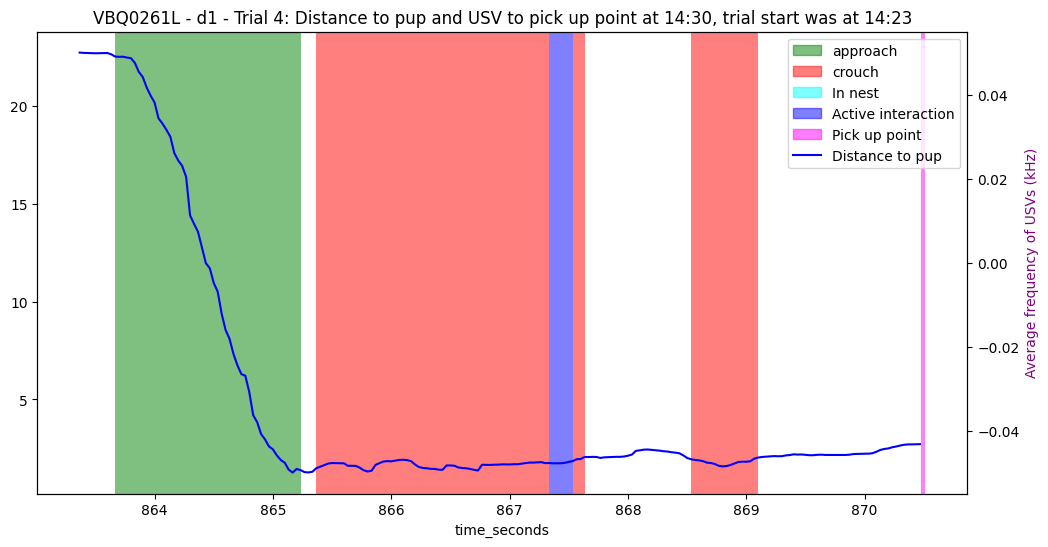

No pick up point for trial 5
No pick up point for trial 6
No pick up point for trial 7
No pick up point for trial 8
VBQ0261L Day d1 - Trial 9 was not successful


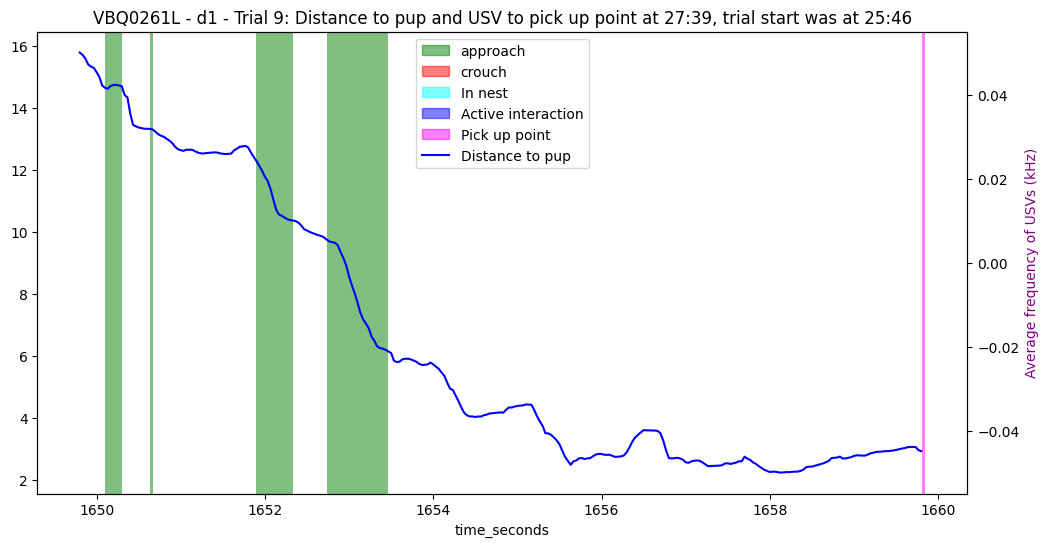

No pick up point for trial 10
No pick up point for trial 1
No pick up point for trial 2
No pick up point for trial 3


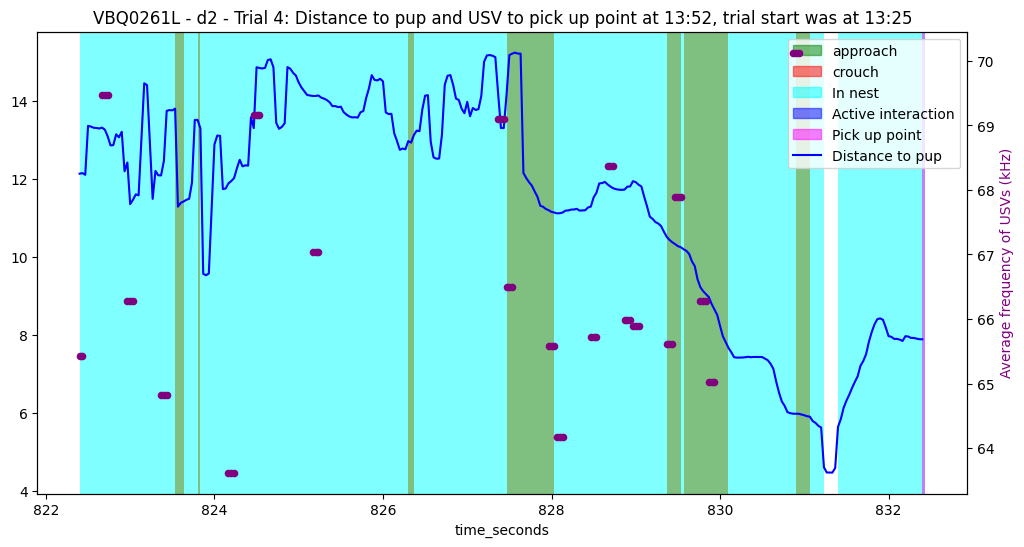

VBQ0261L Day d2 - Trial 5 was not successful


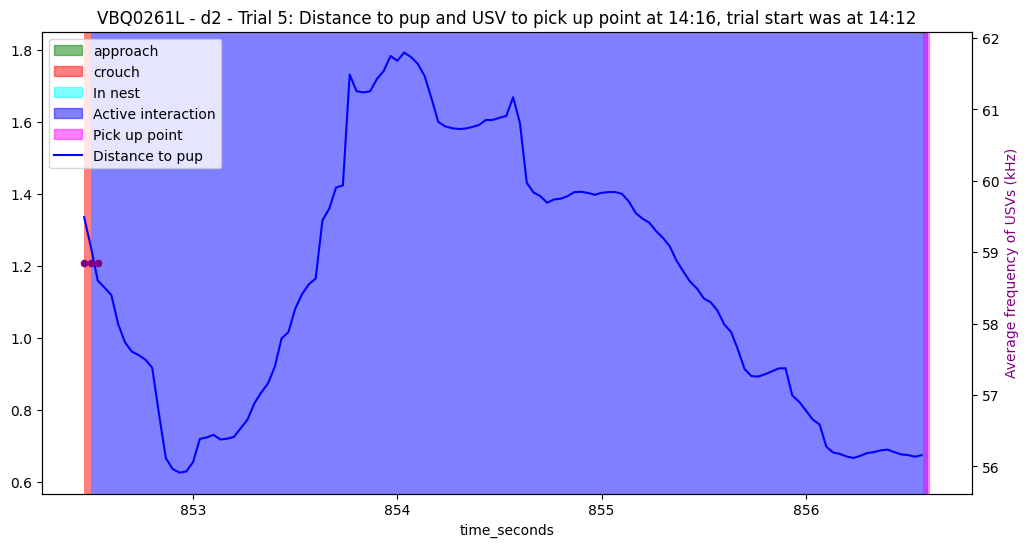

VBQ0261L Day d2 - Trial 6 was not successful


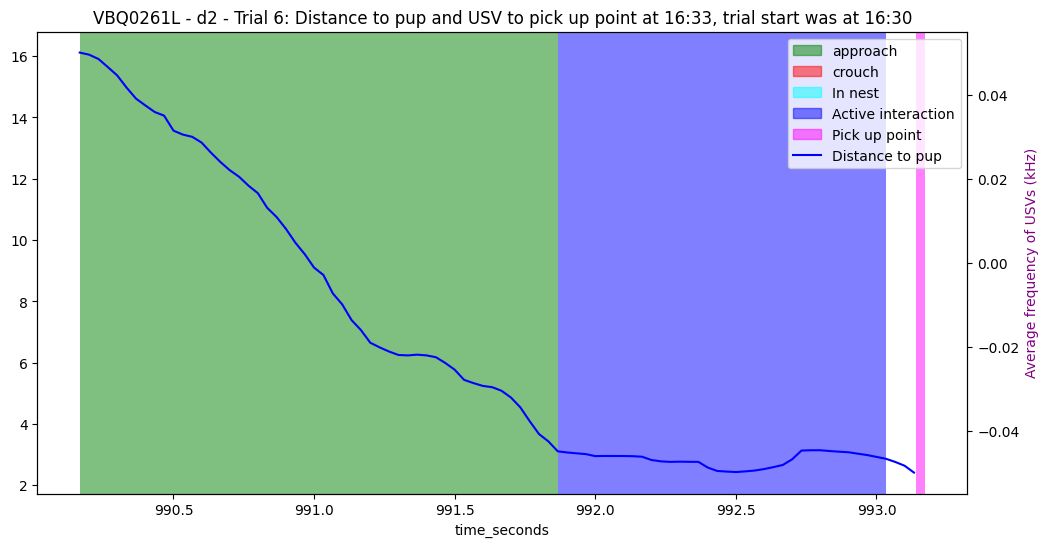

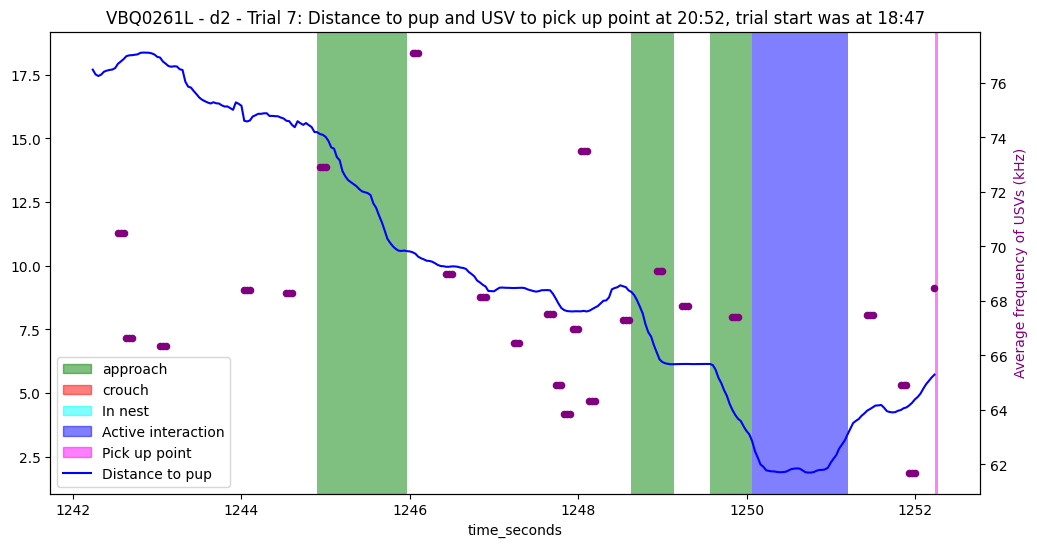

No pick up point for trial 8


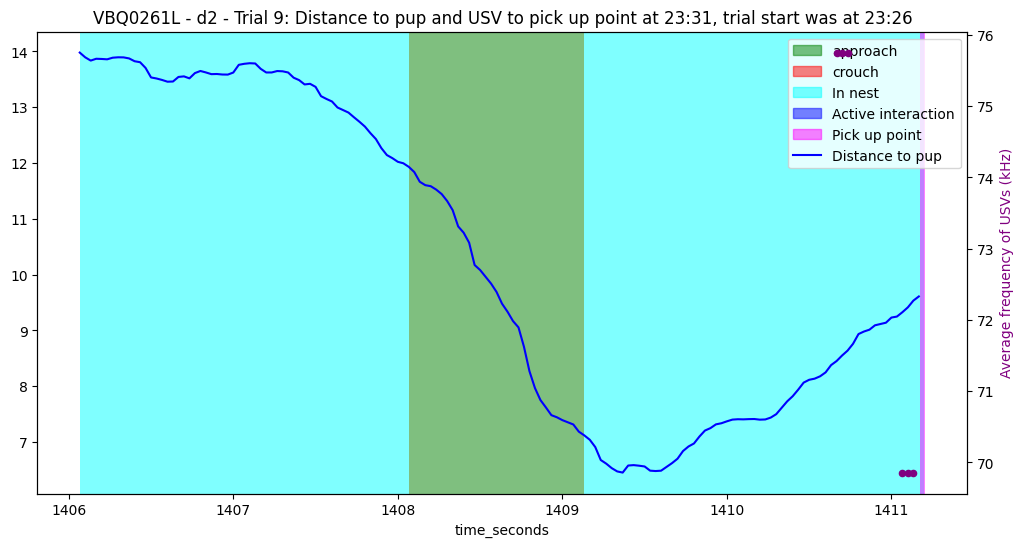

VBQ0261L Day d2 - Trial 10 was not successful


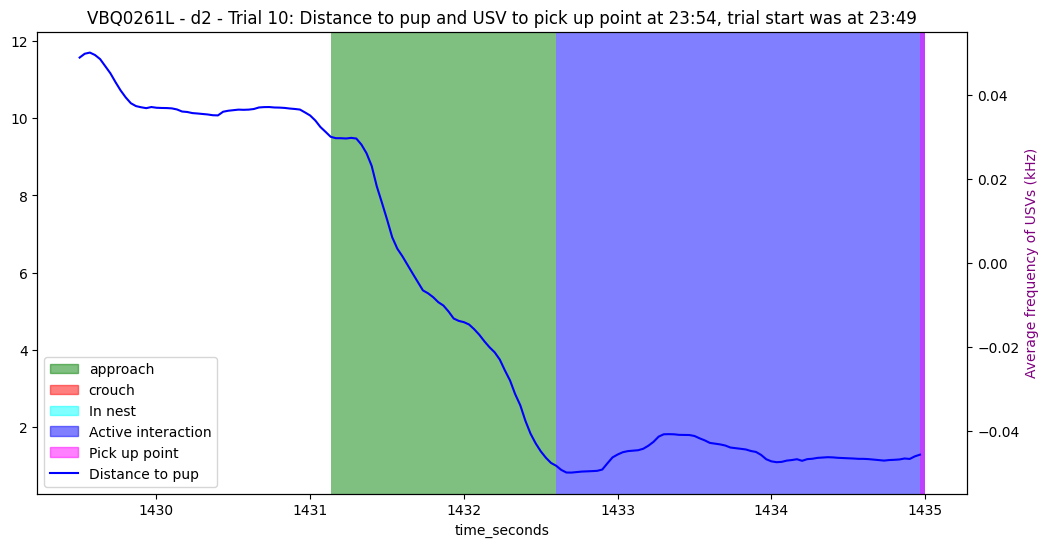

No pick up point for trial 1
No pick up point for trial 2
No pick up point for trial 3


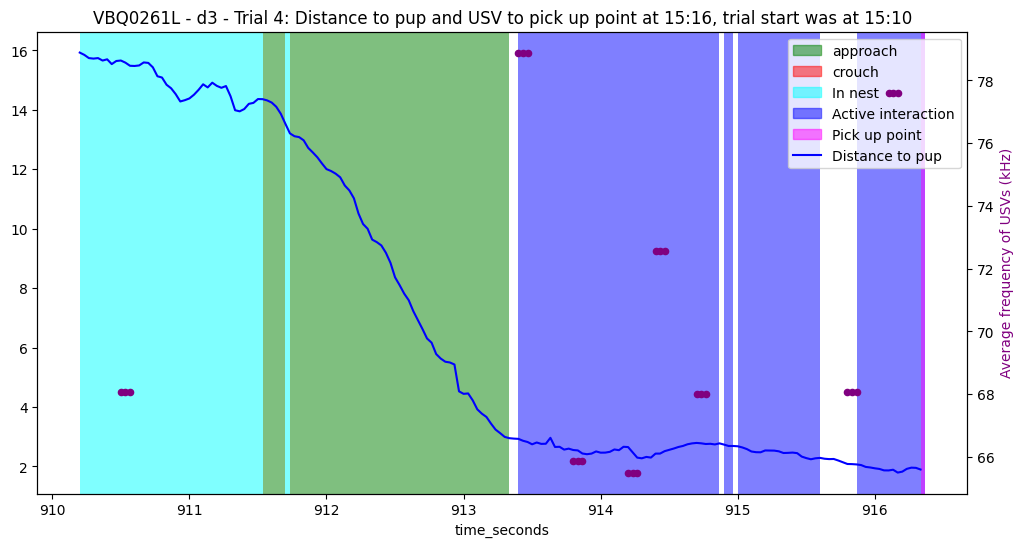

No pick up point for trial 5


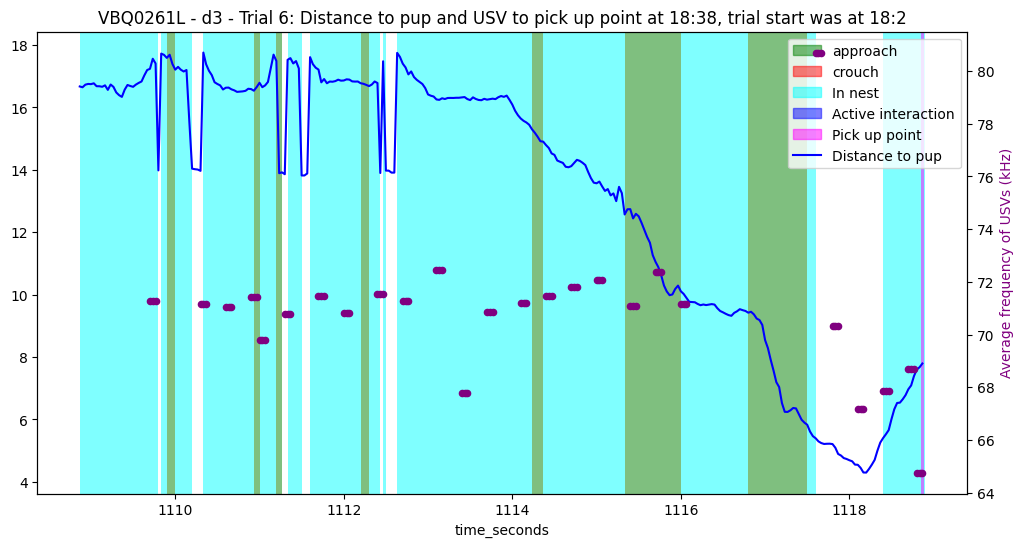

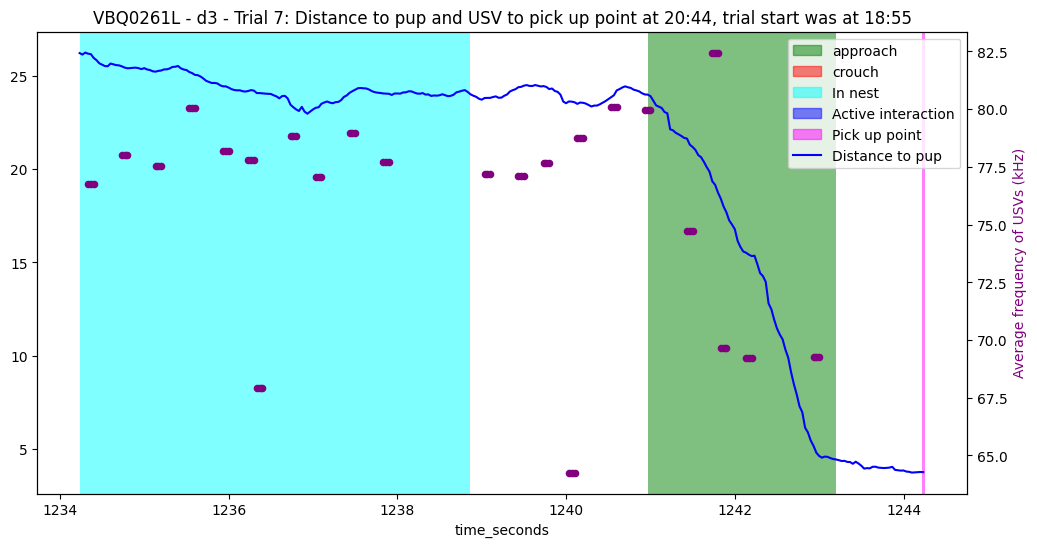

VBQ0261L Day d3 - Trial 8 was not successful


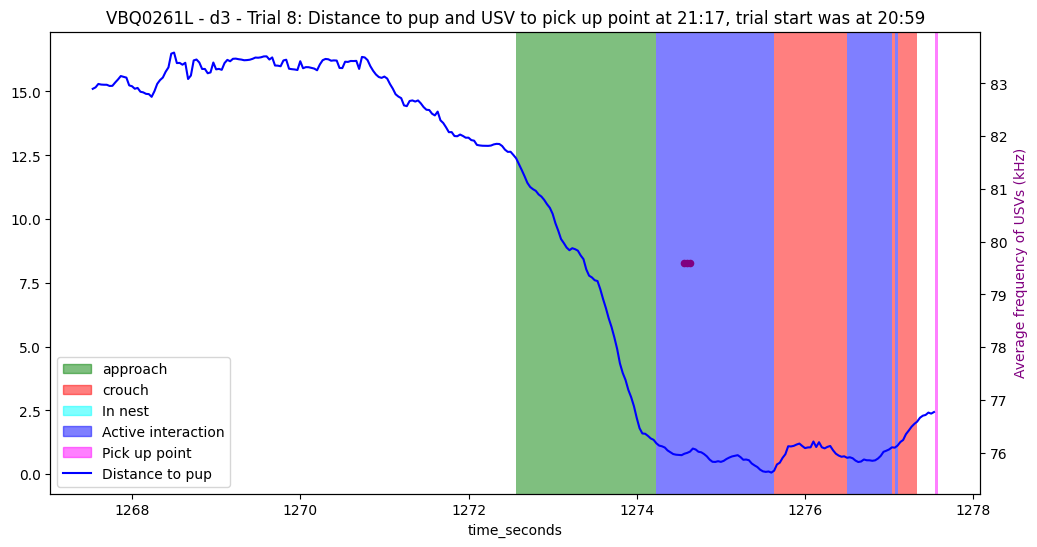

No pick up point for trial 9


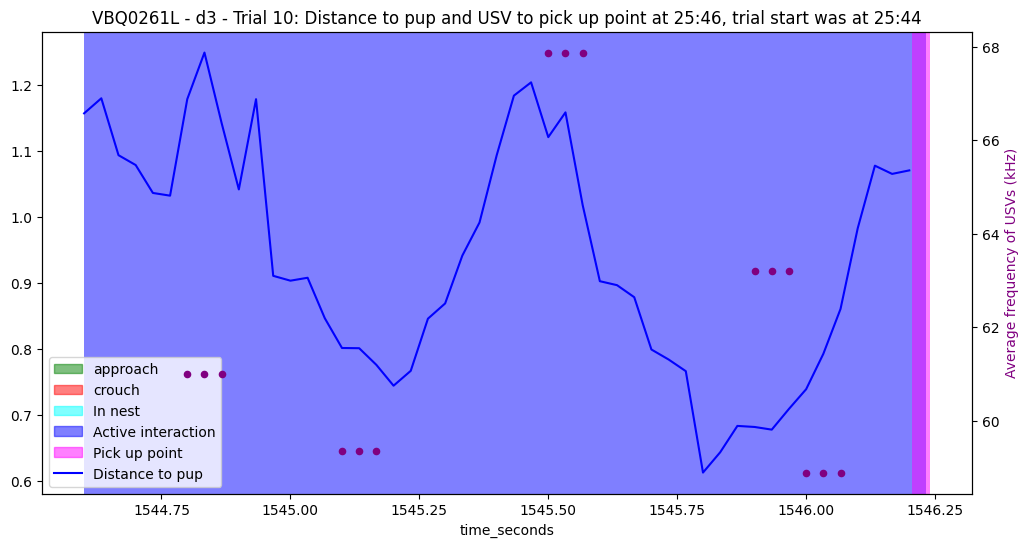

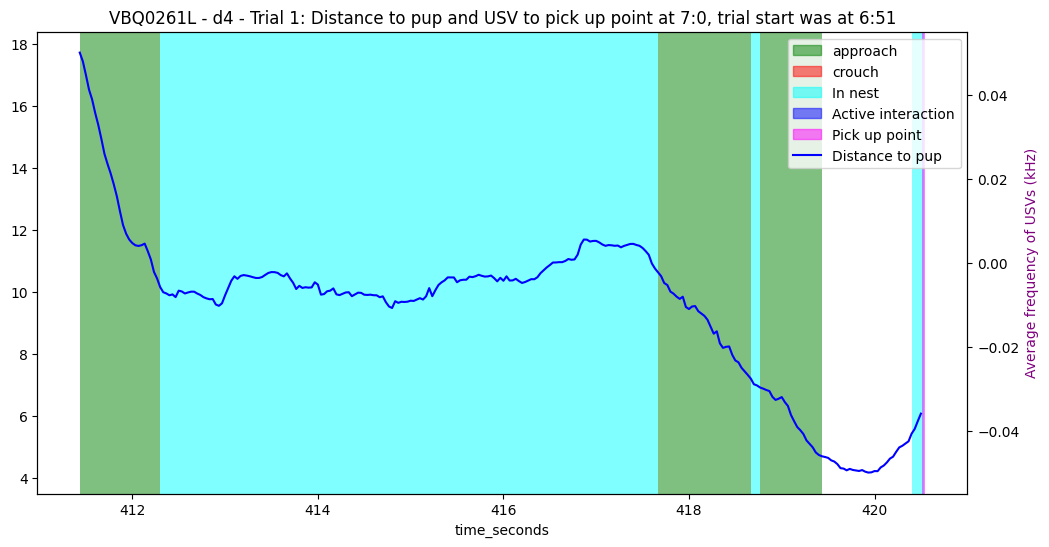

No pick up point for trial 2


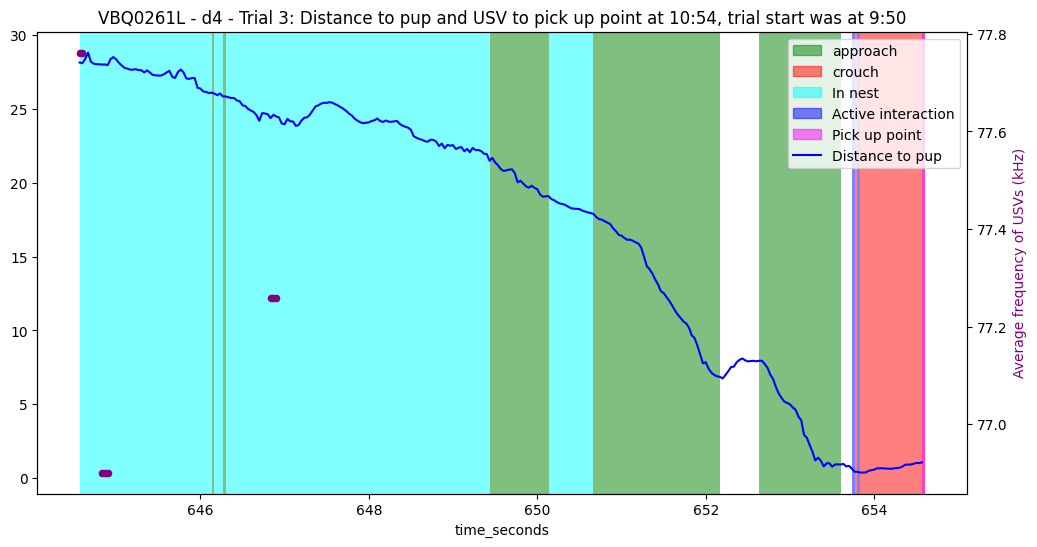

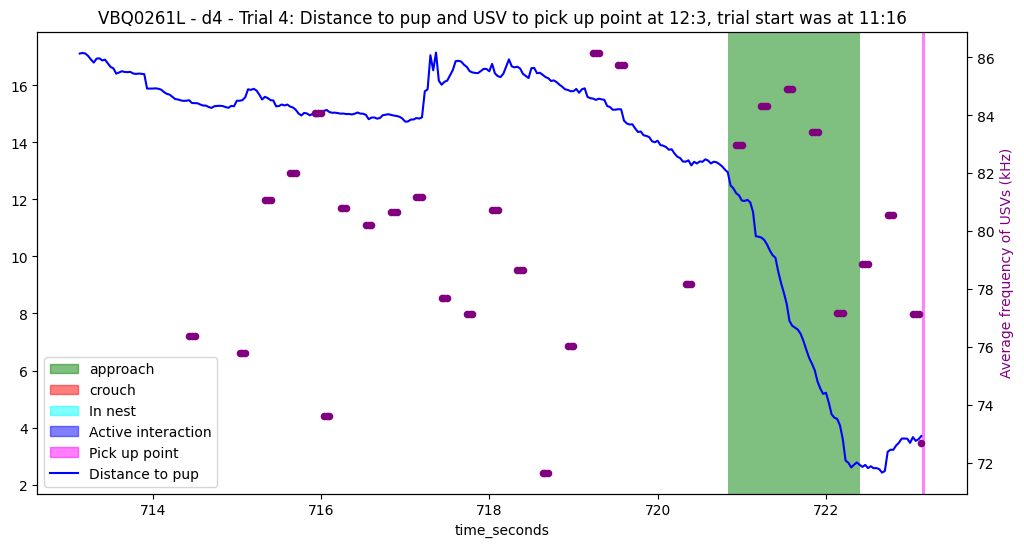

No pick up point for trial 5


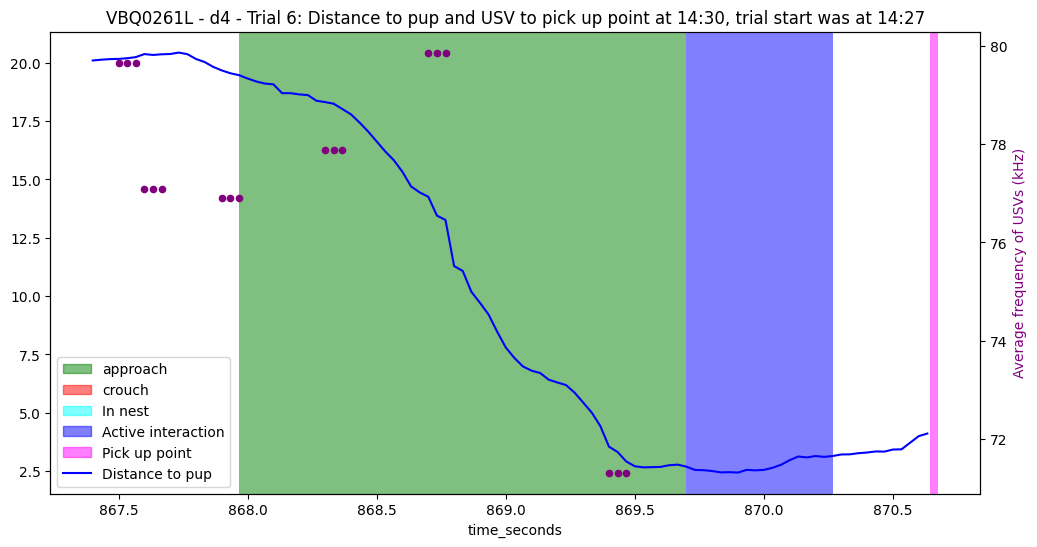

VBQ0261L Day d4 - Trial 7 was not successful


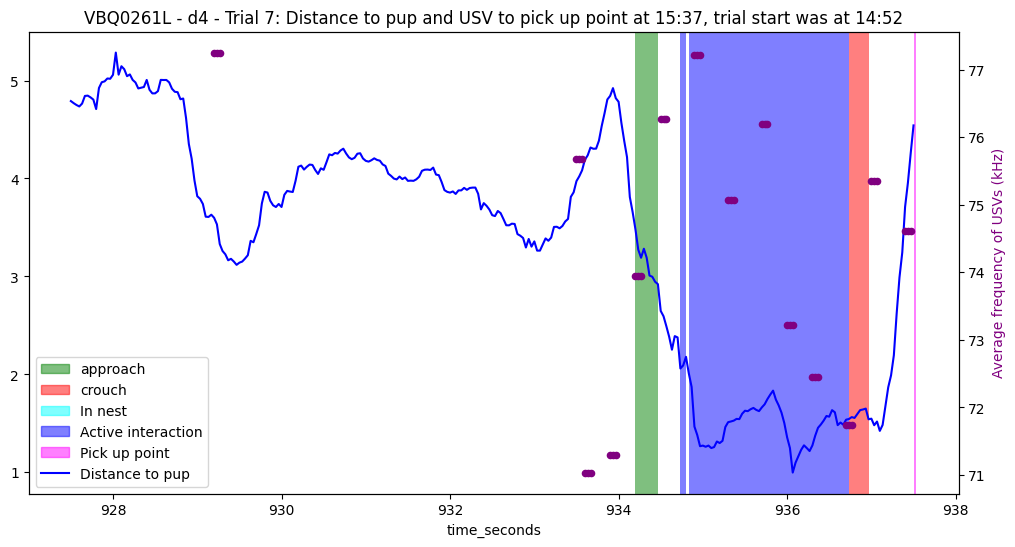

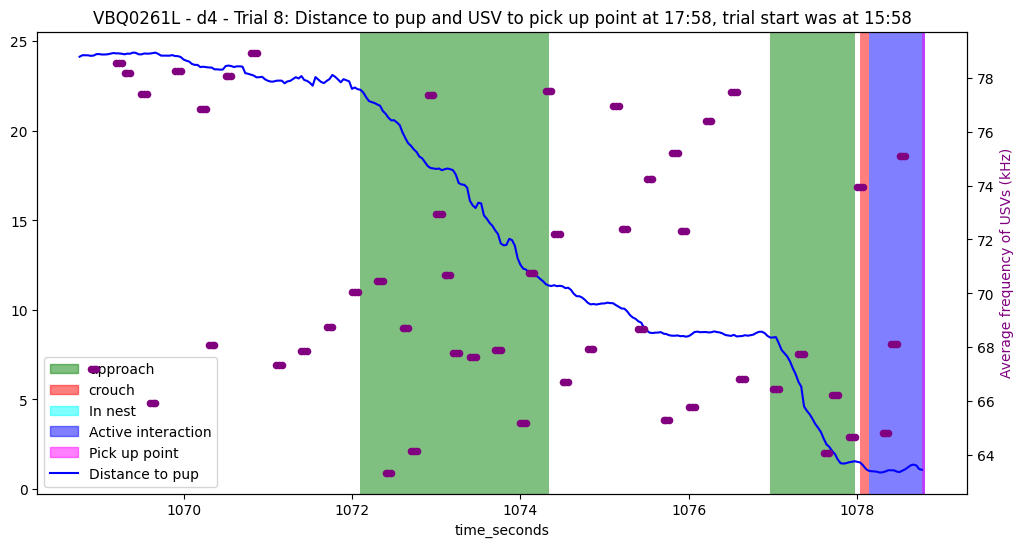

No pick up point for trial 9
No pick up point for trial 10
No pick up point for trial 1
No pick up point for trial 2


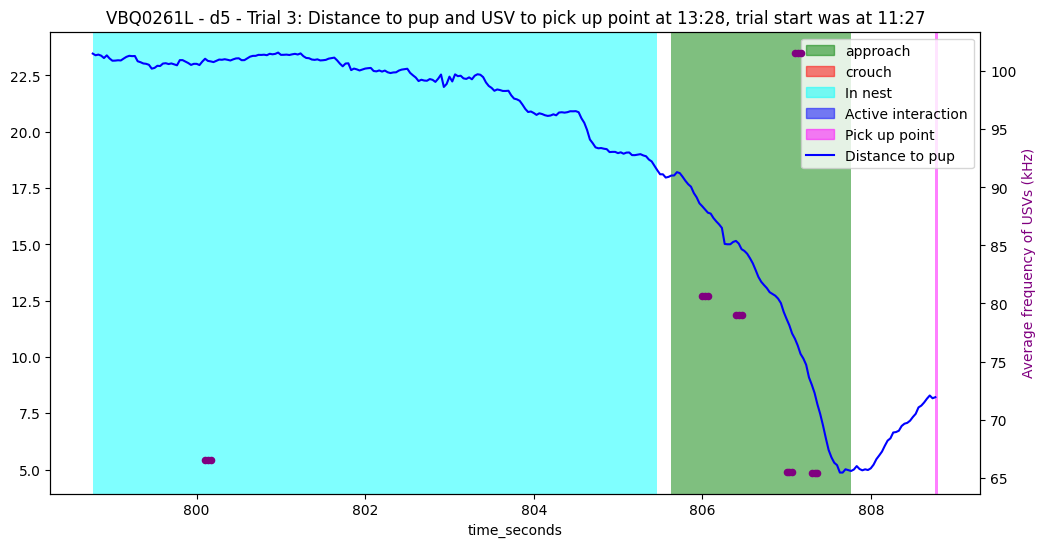

No pick up point for trial 4
No pick up point for trial 5


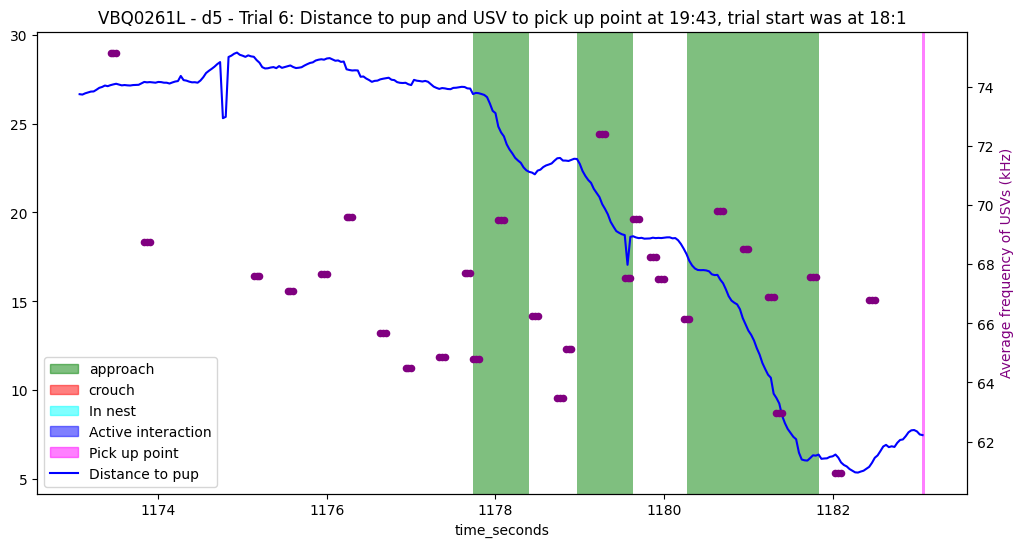

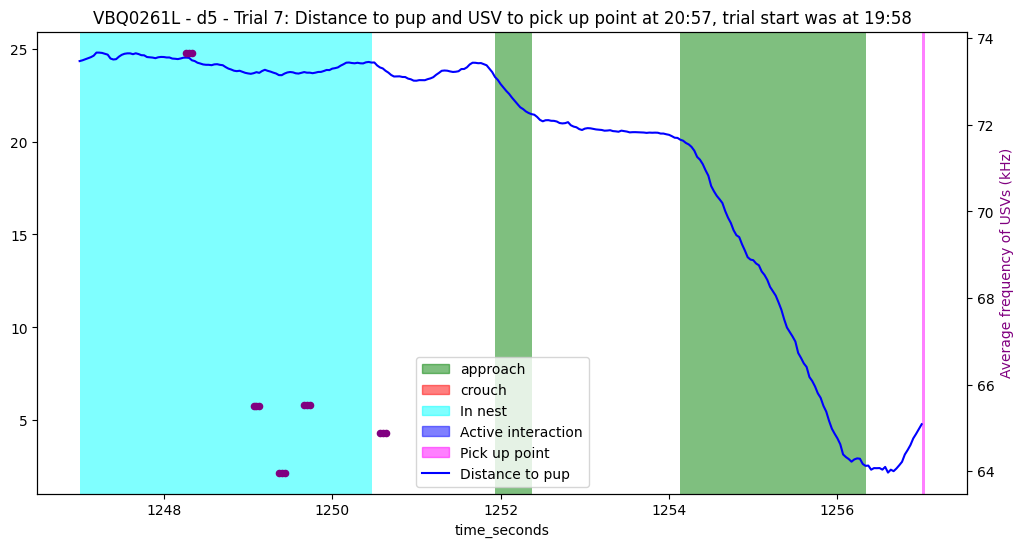

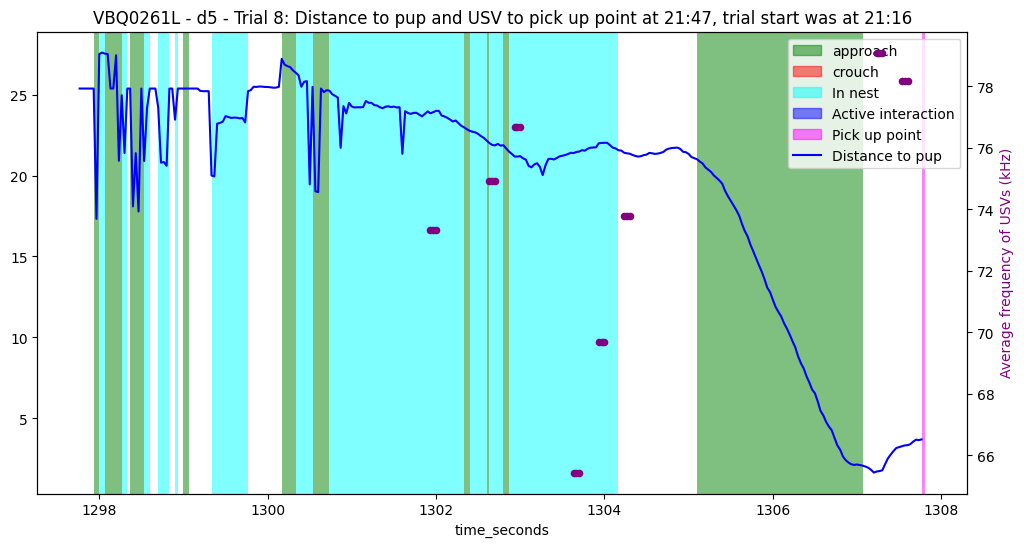

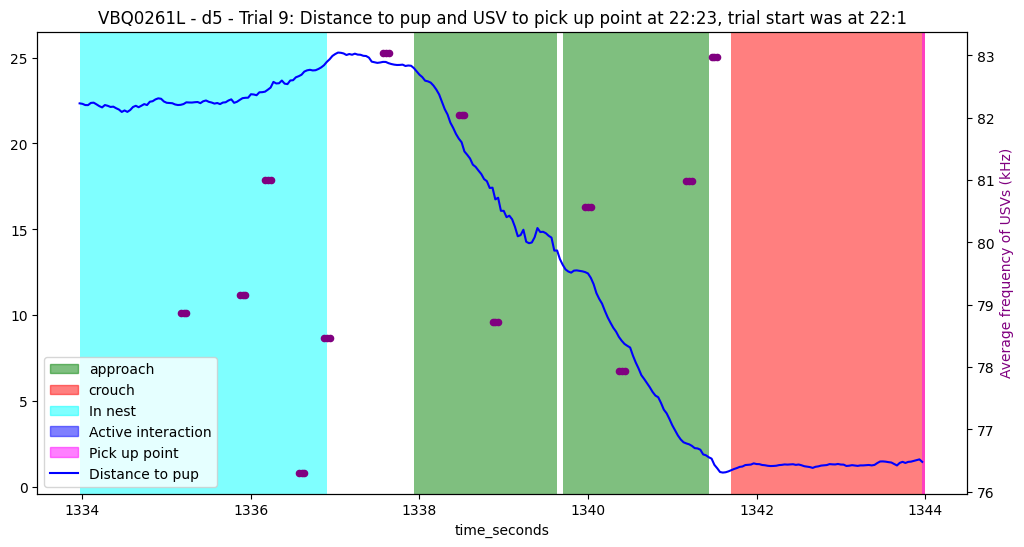

No pick up point for trial 10
No pick up point for trial 1
No pick up point for trial 2
No pick up point for trial 3
No pick up point for trial 4
No pick up point for trial 5
No pick up point for trial 6


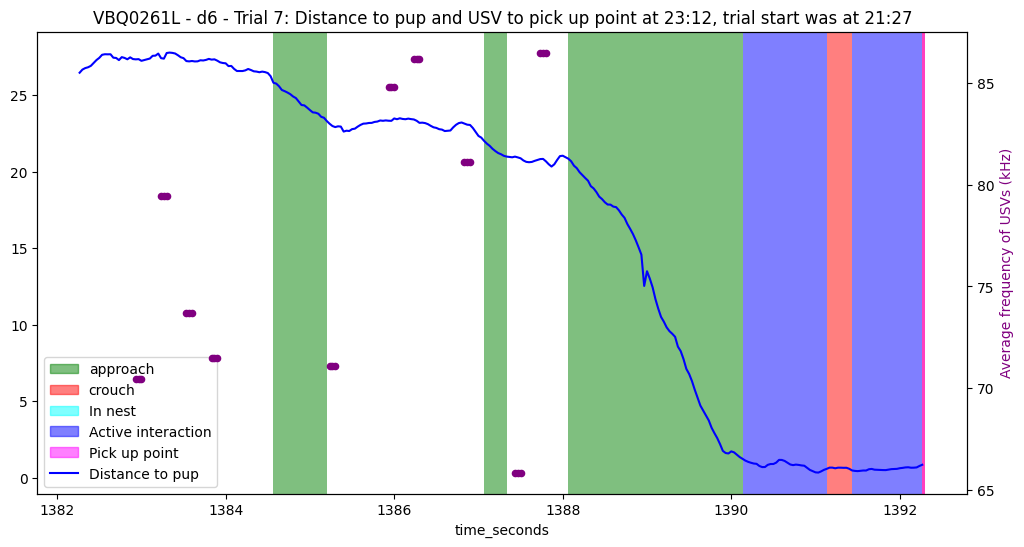

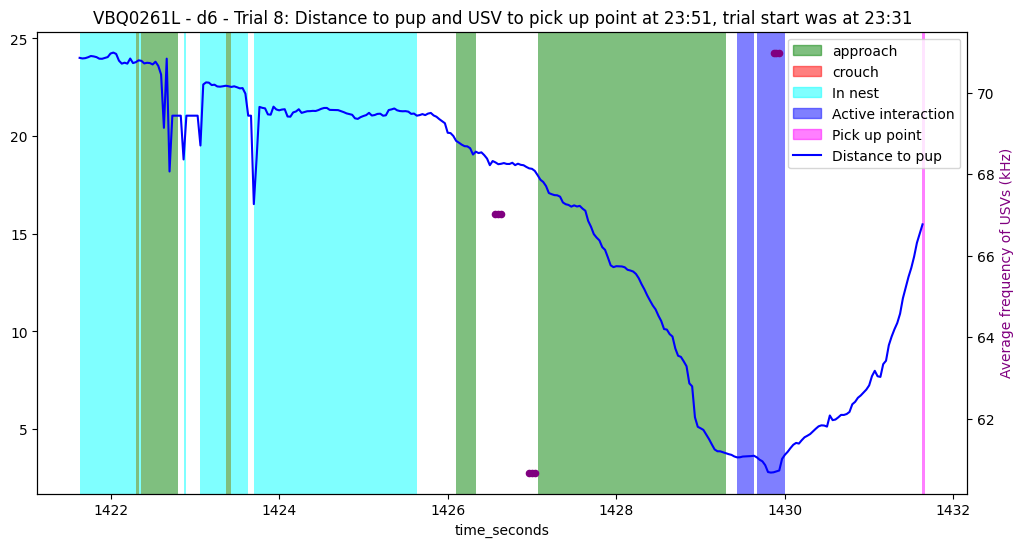

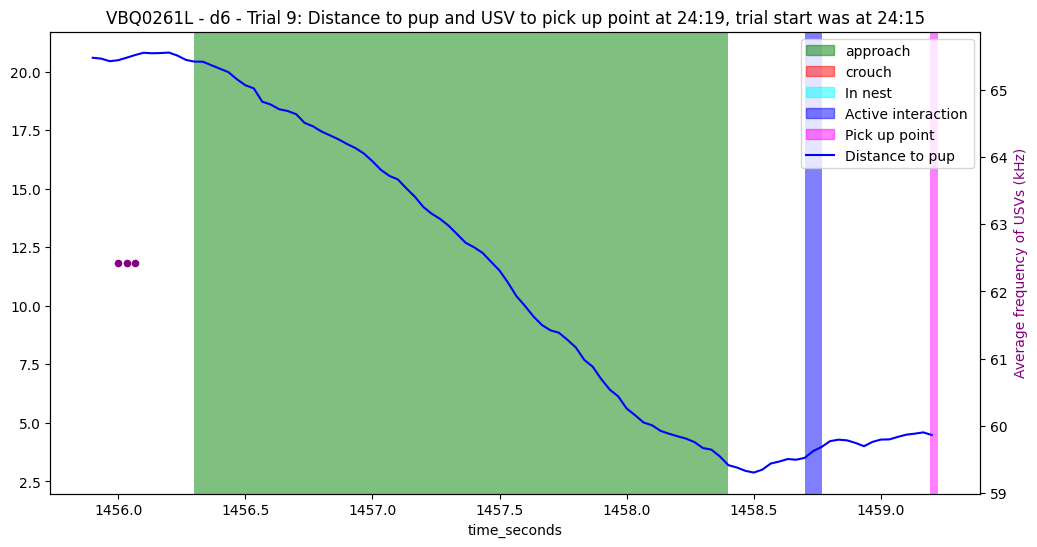

No pick up point for trial 10


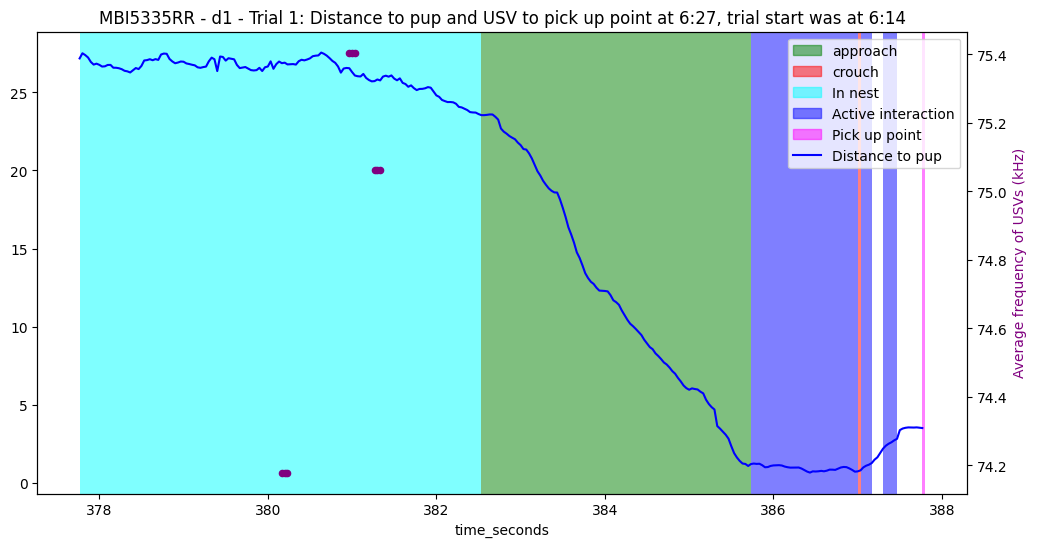

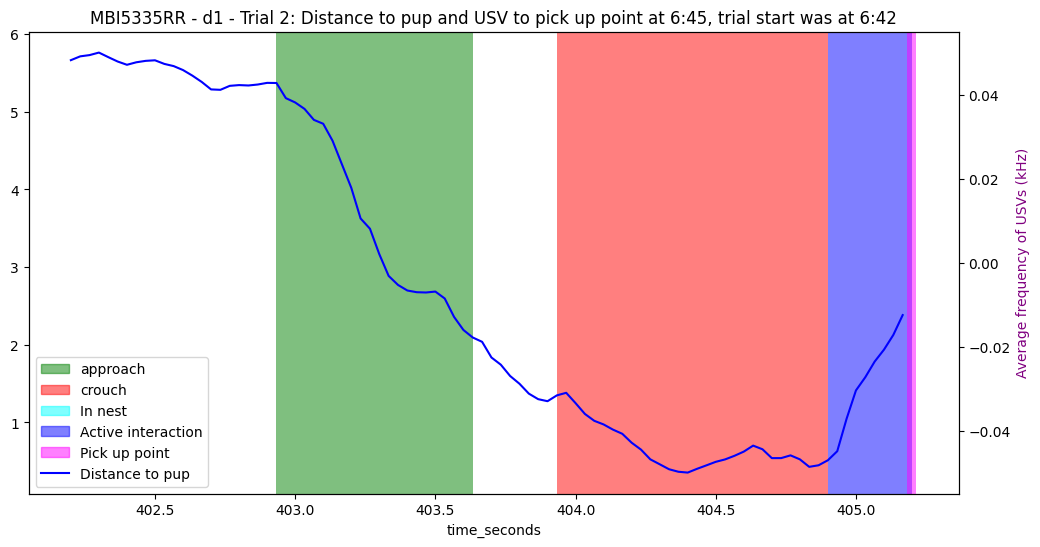

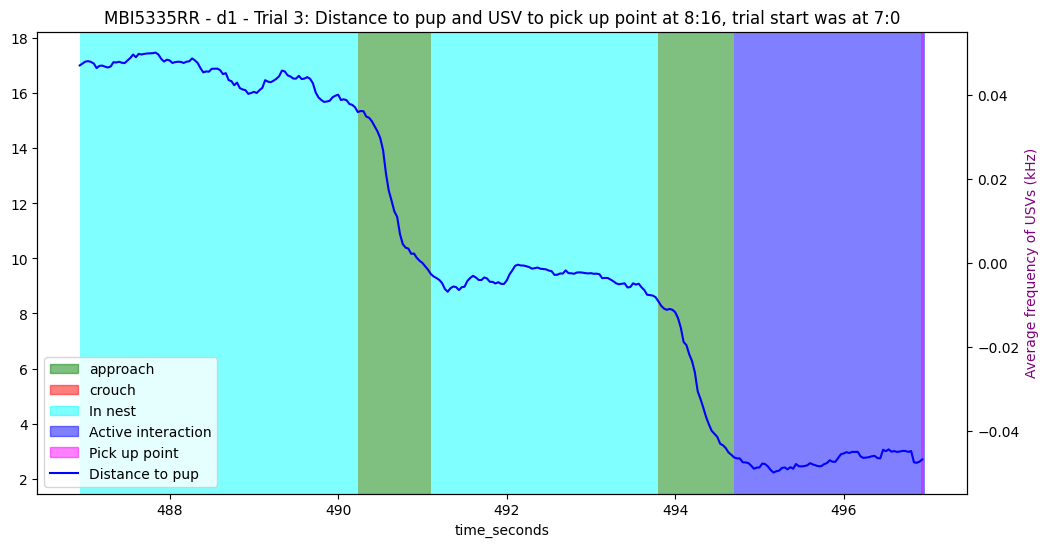

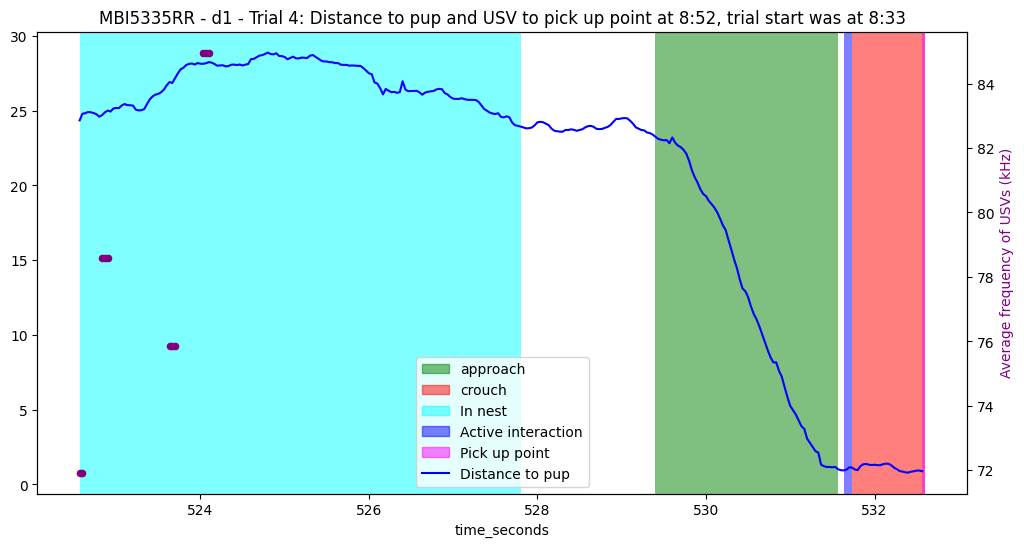

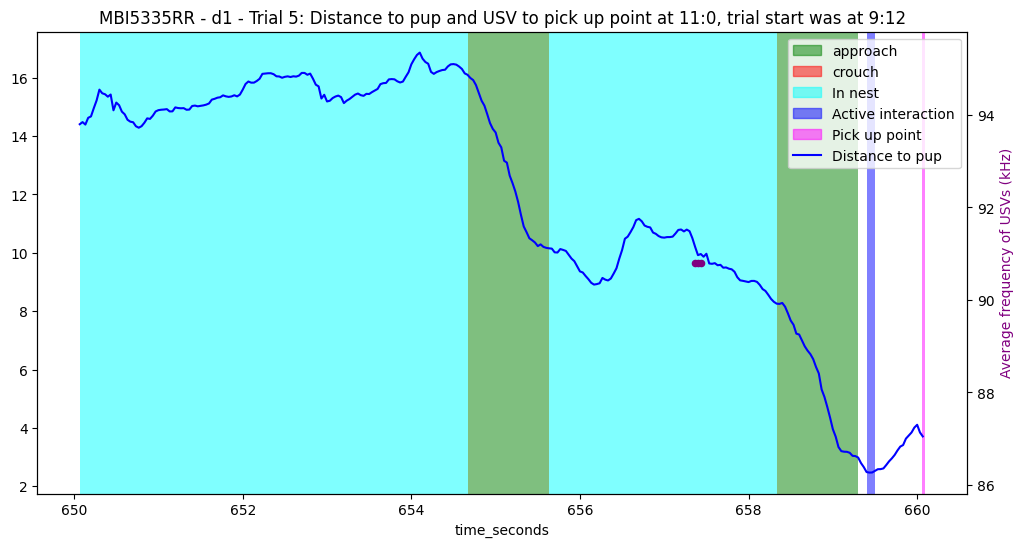

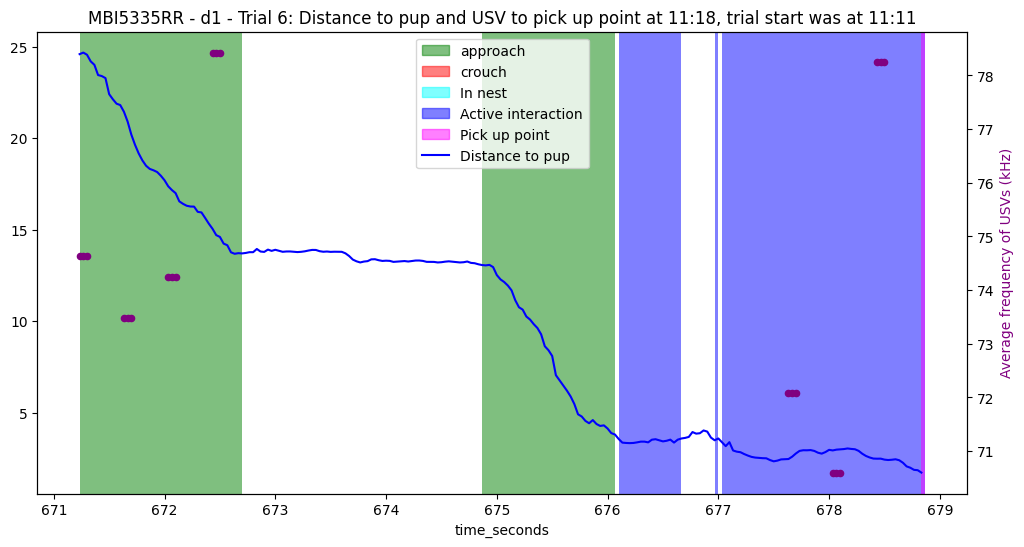

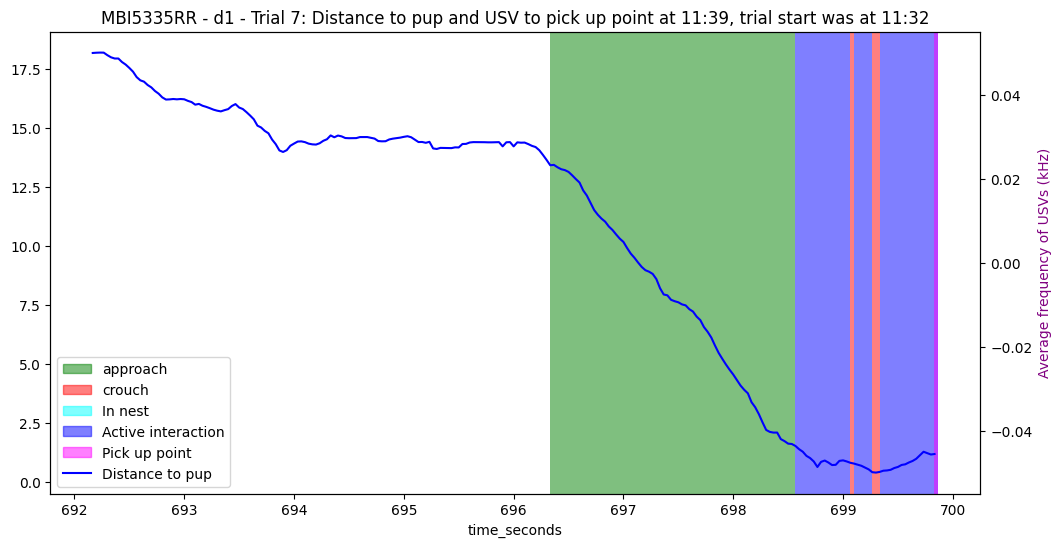

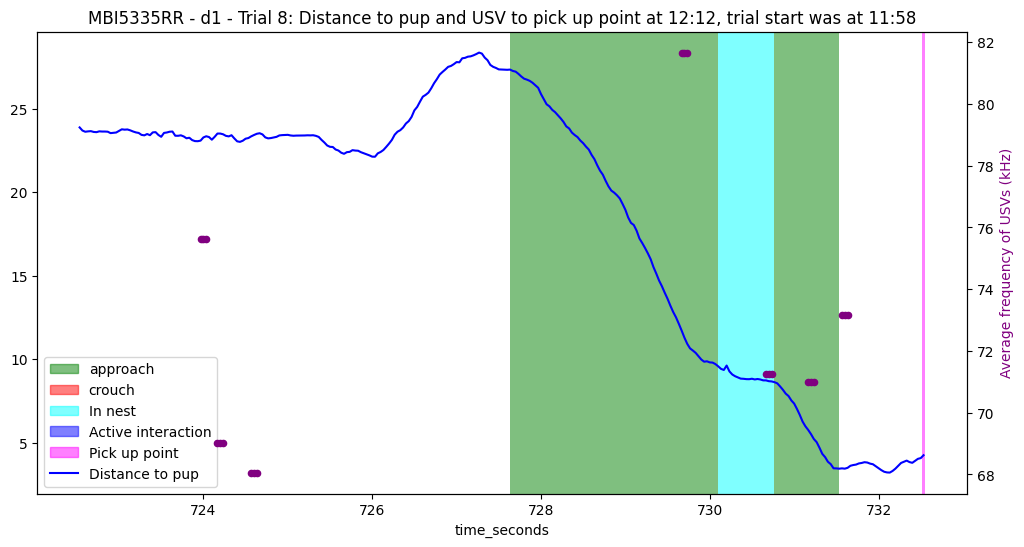

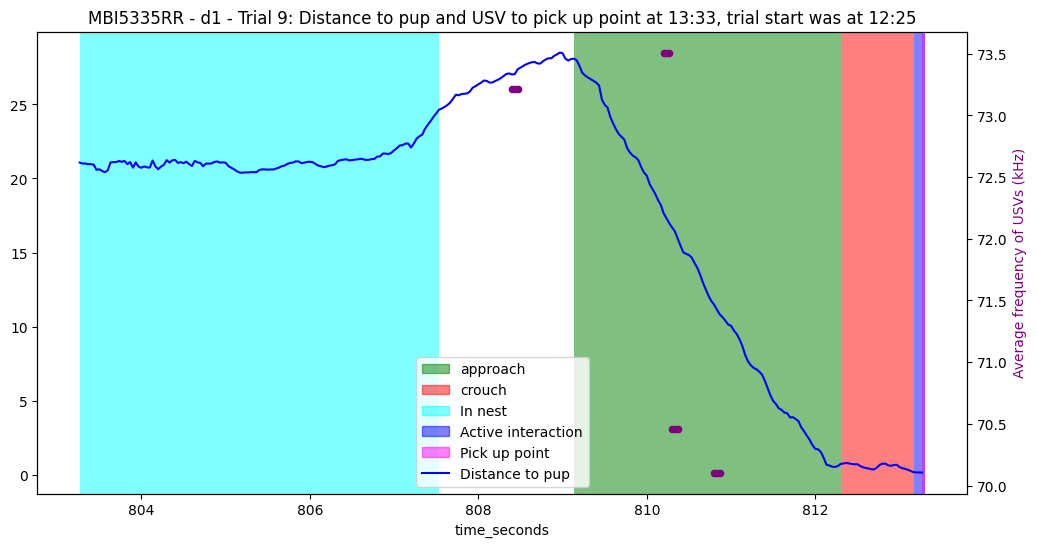

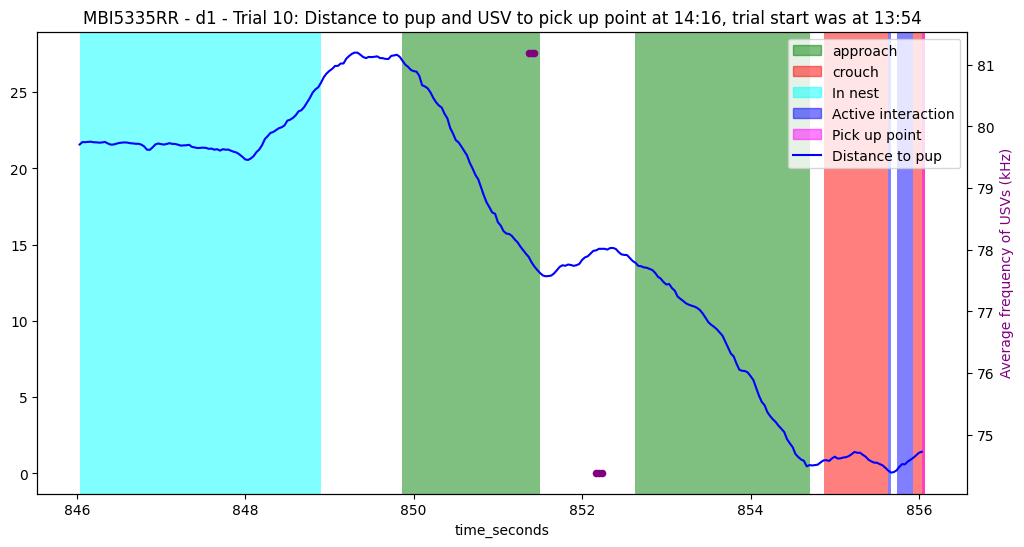

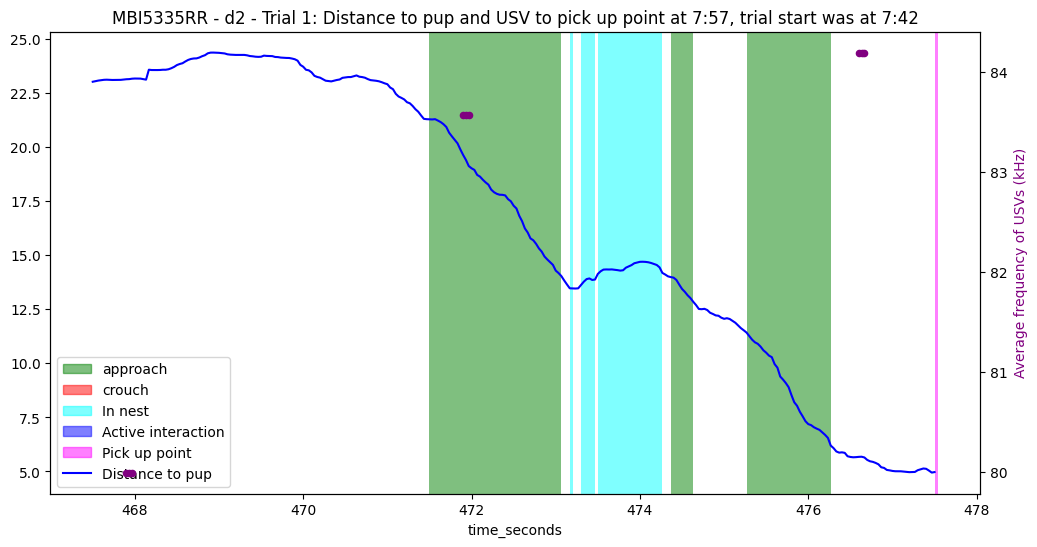

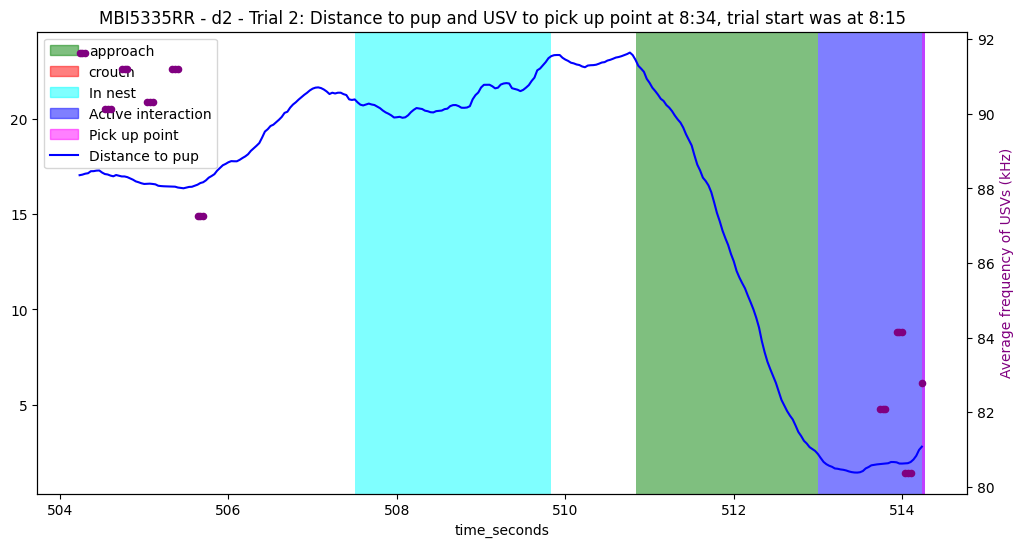

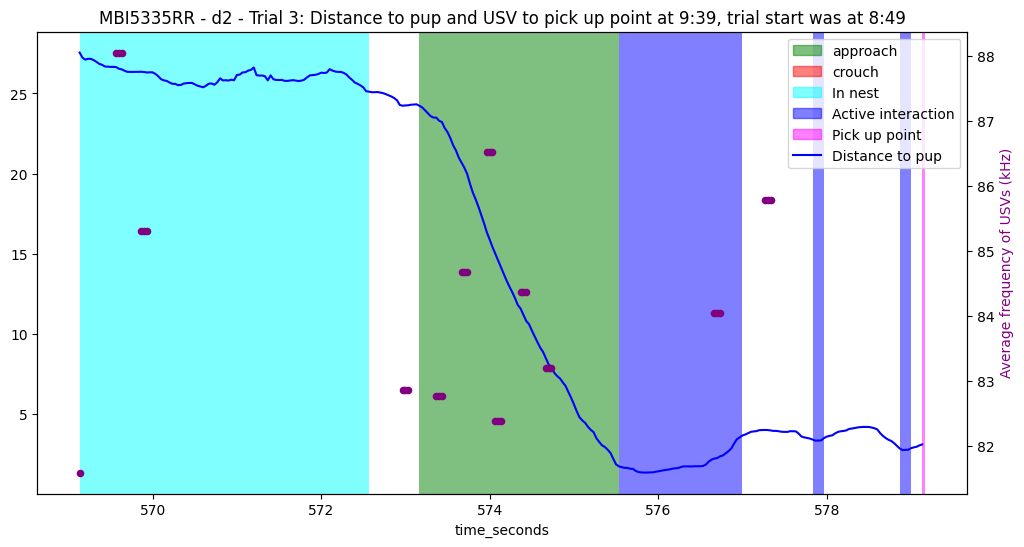

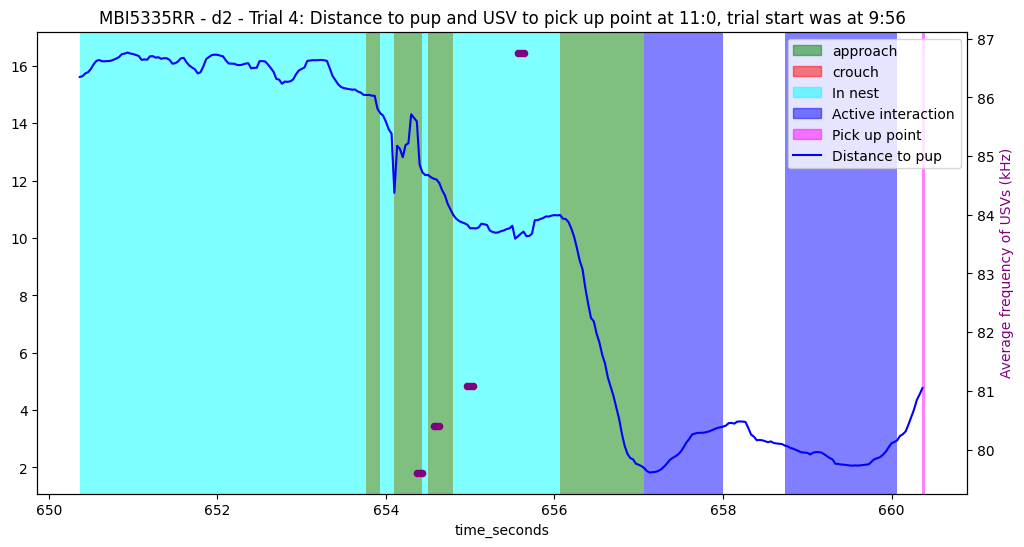

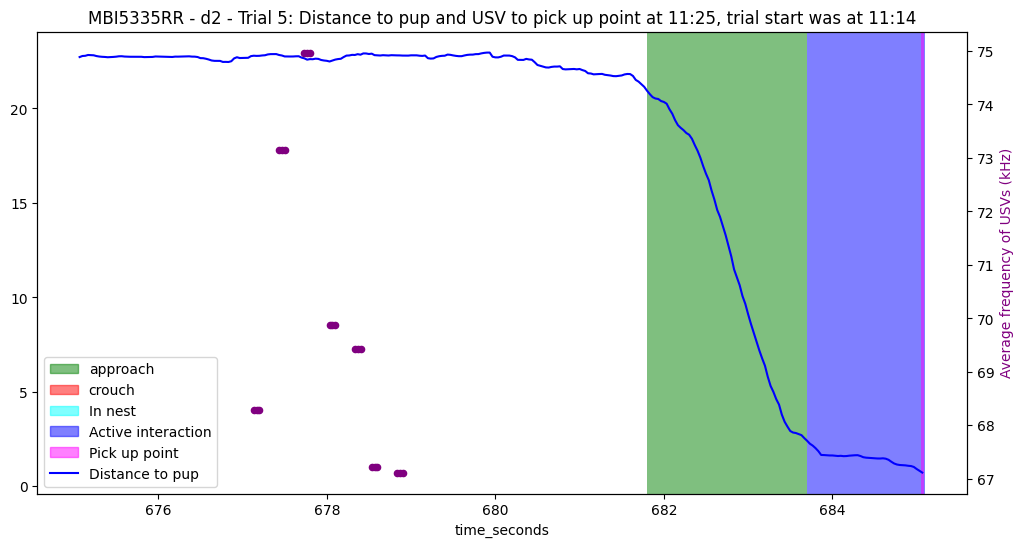

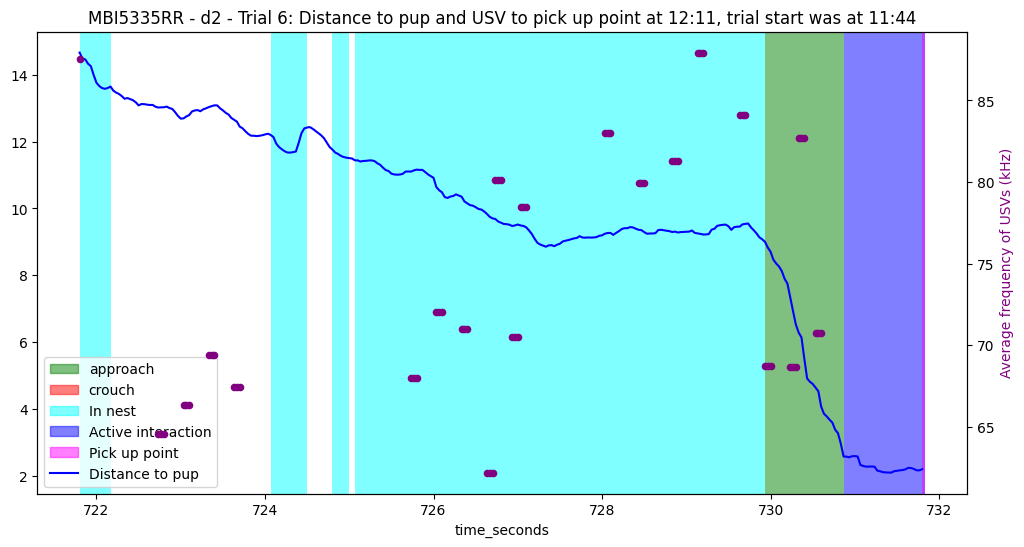

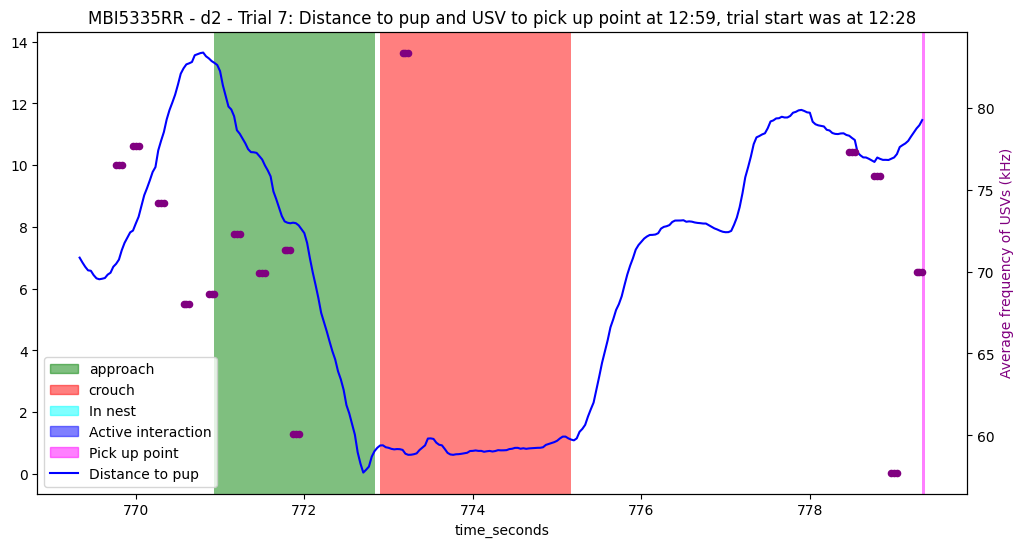

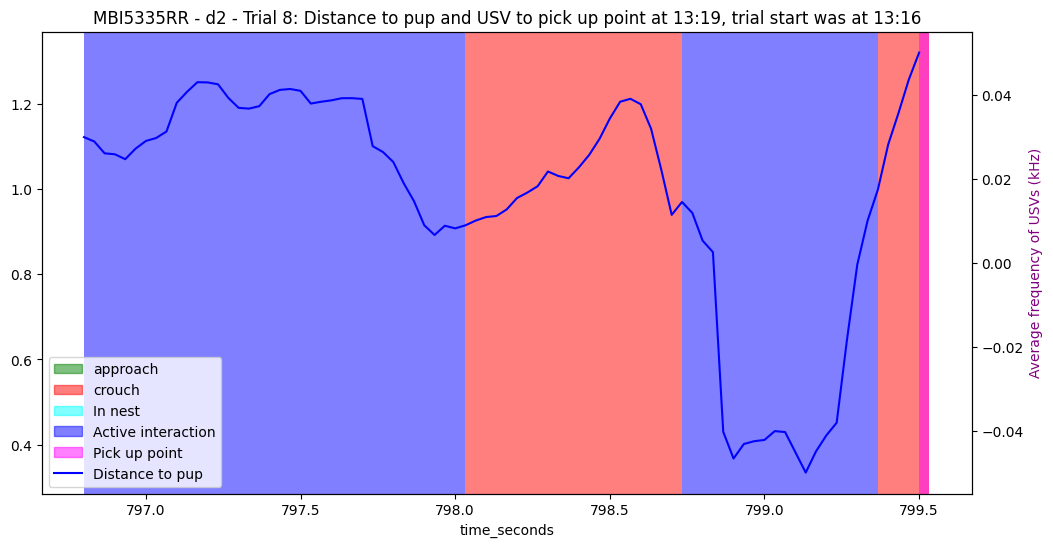

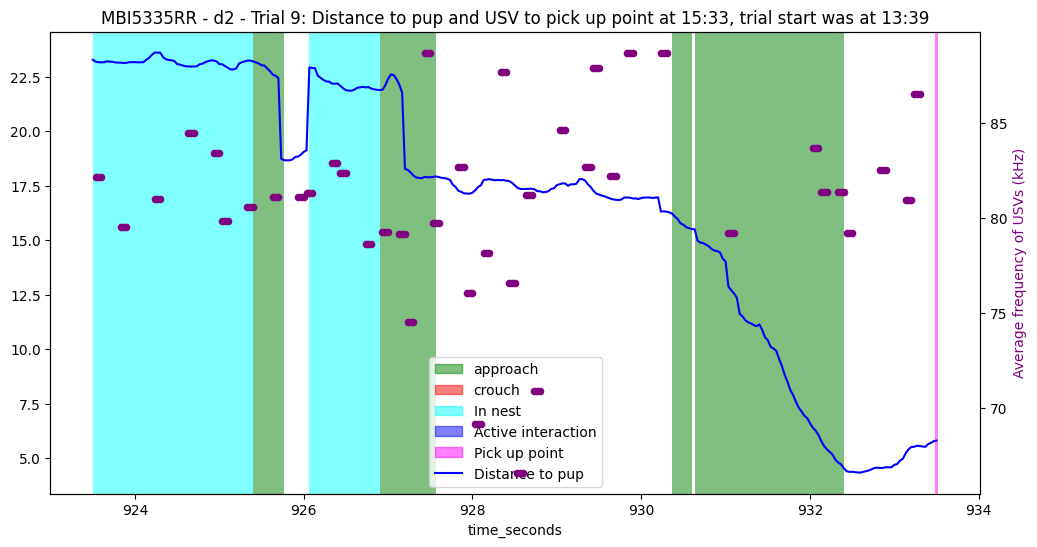

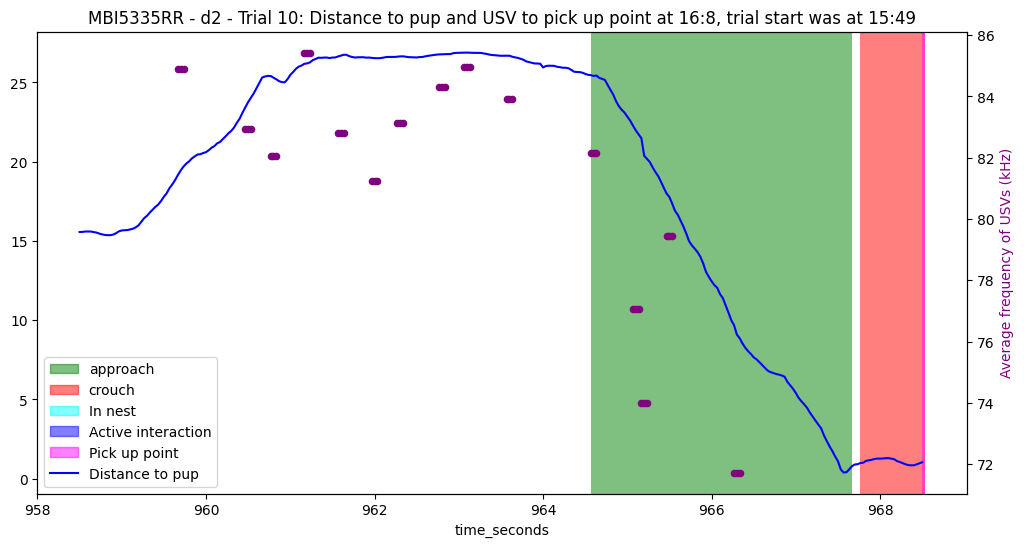

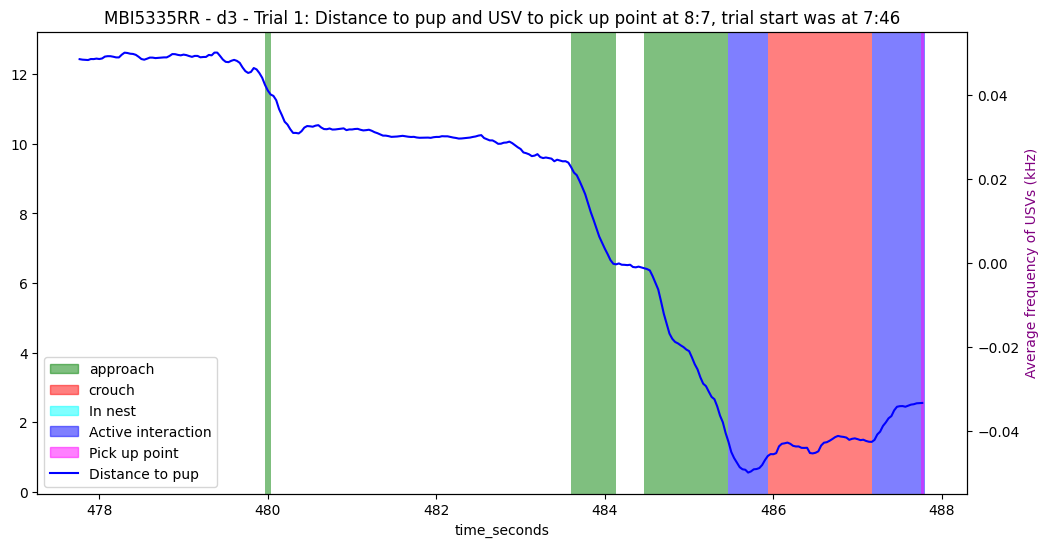

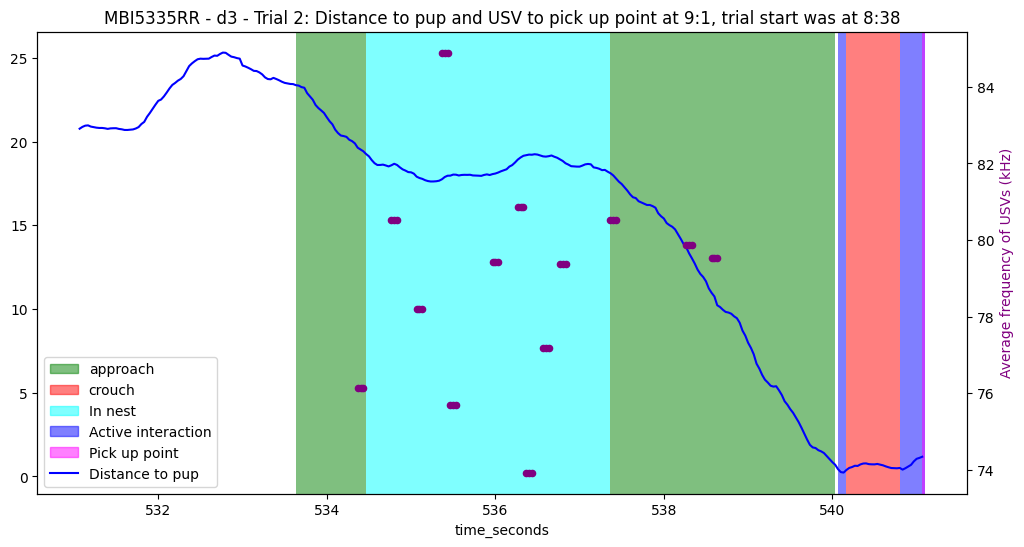

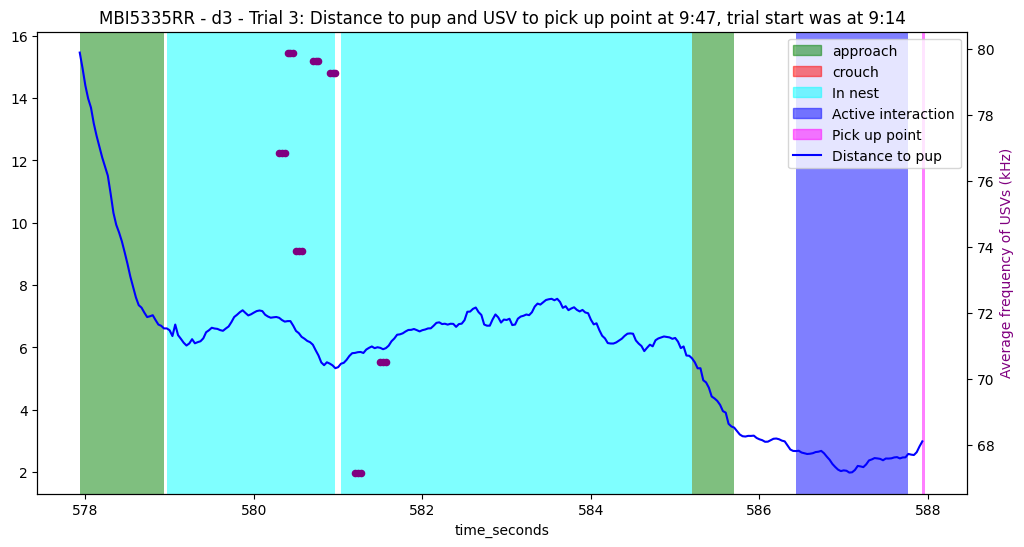

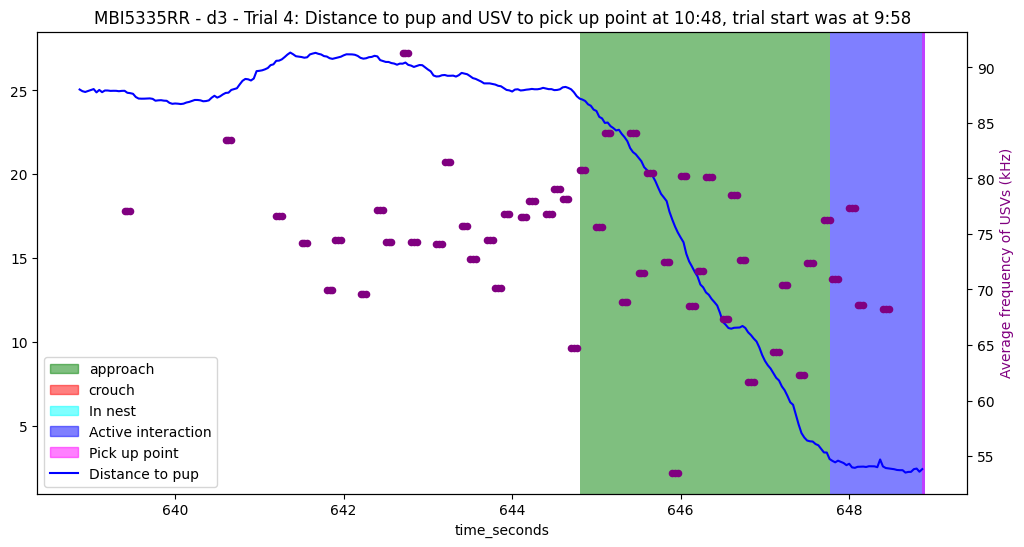

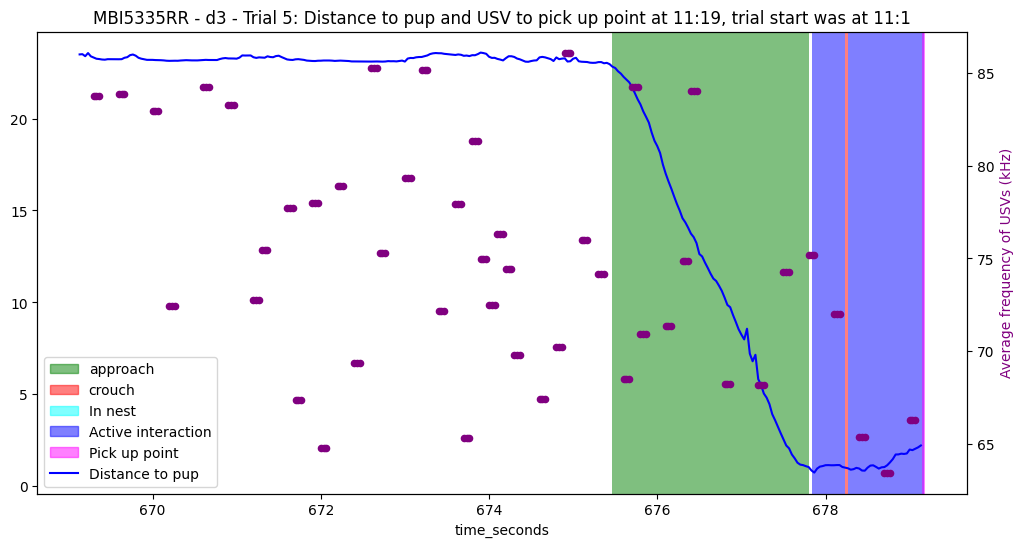

No pick up point for trial 6


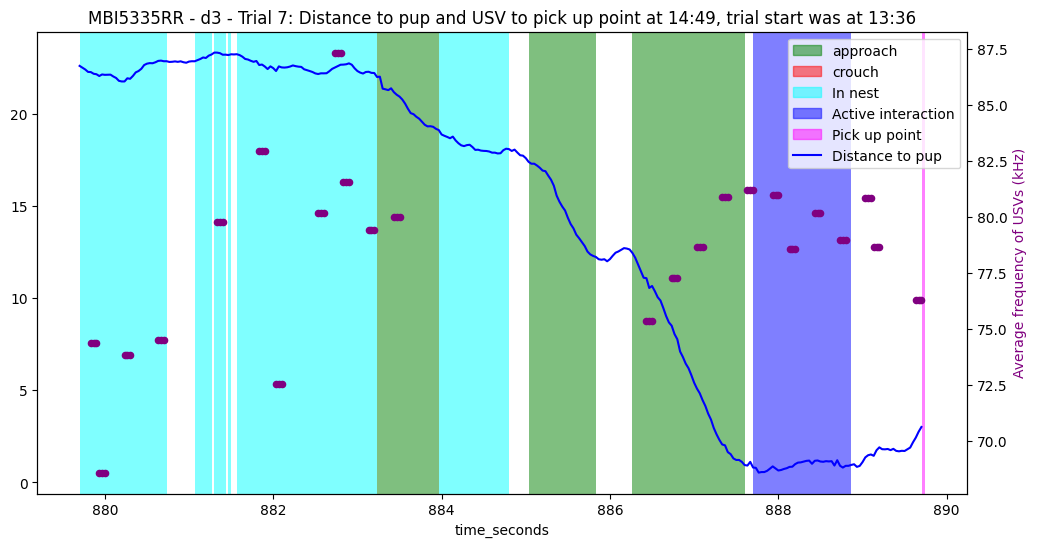

No pick up point for trial 8


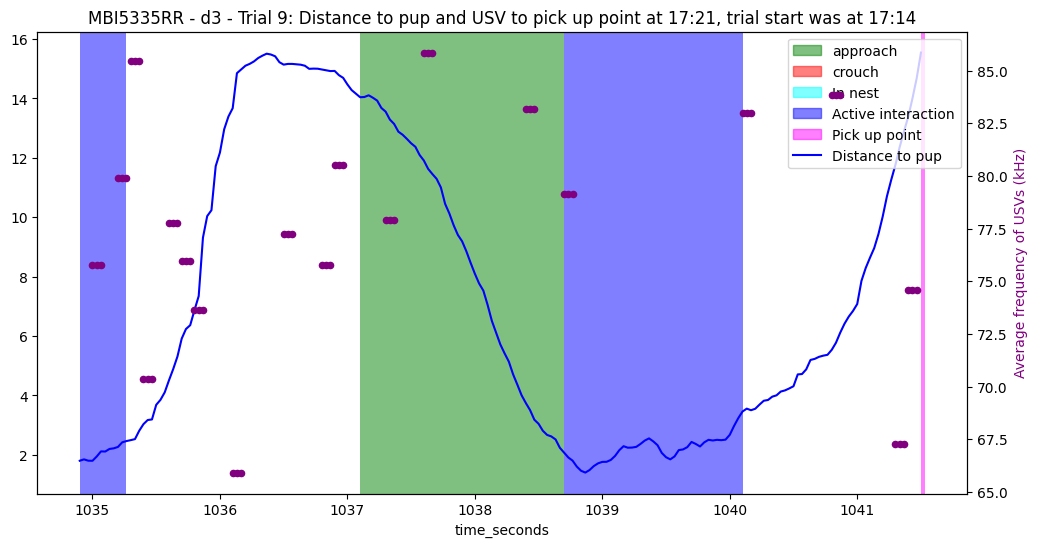

No pick up point for trial 10


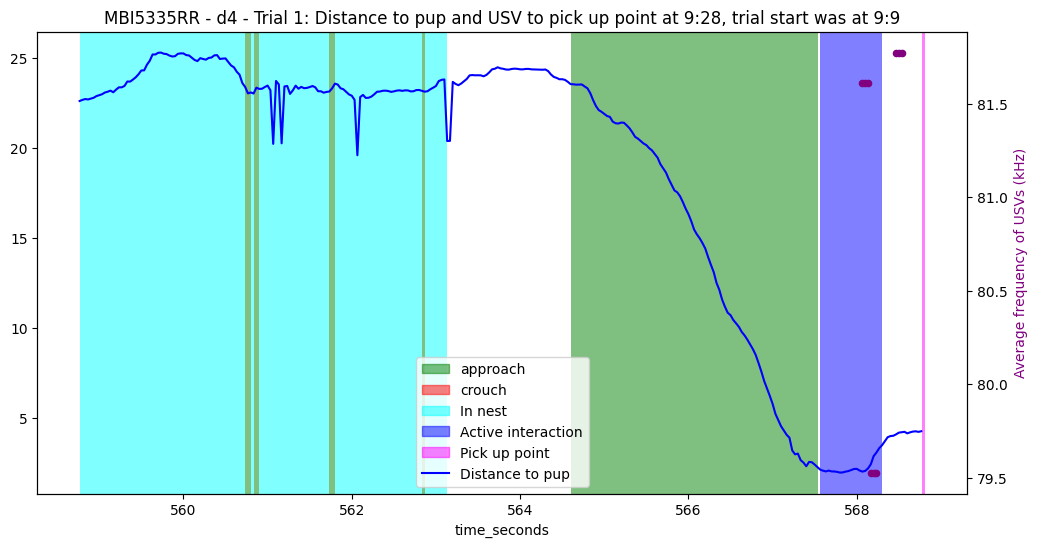

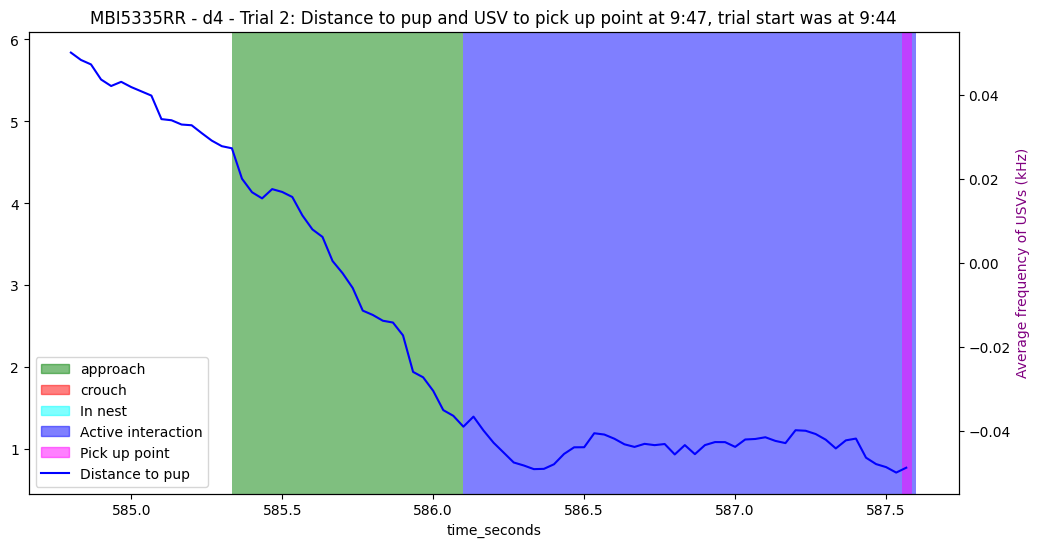

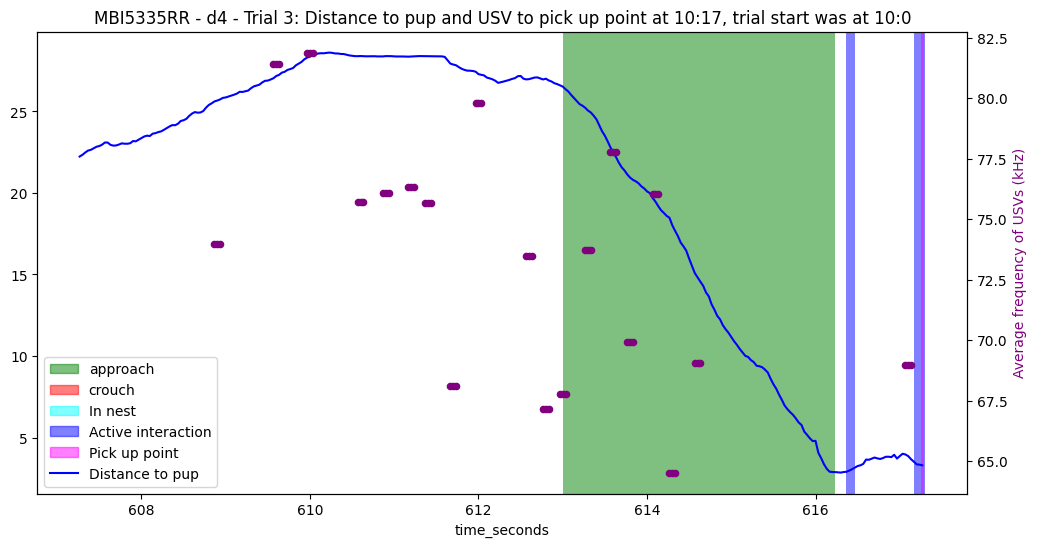

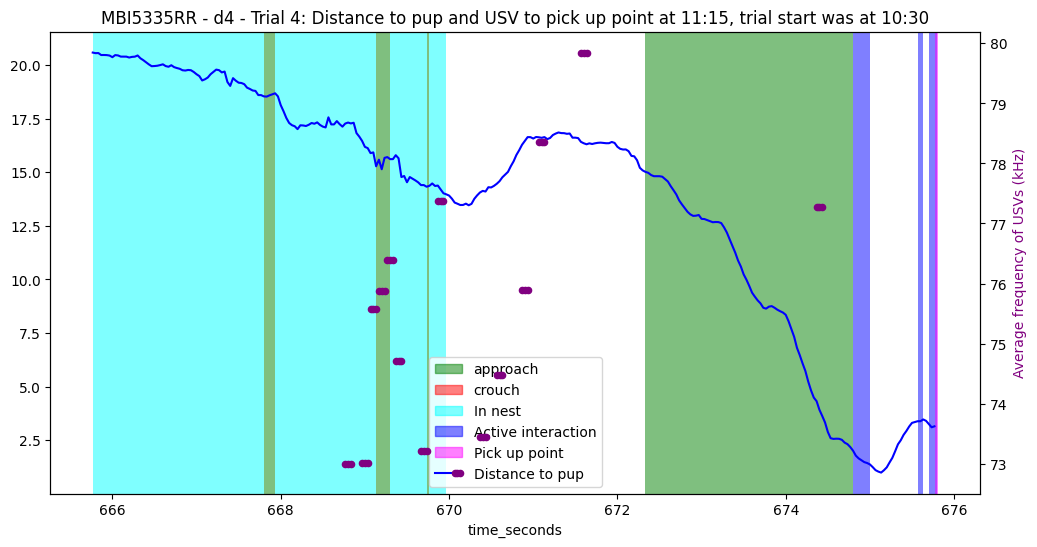

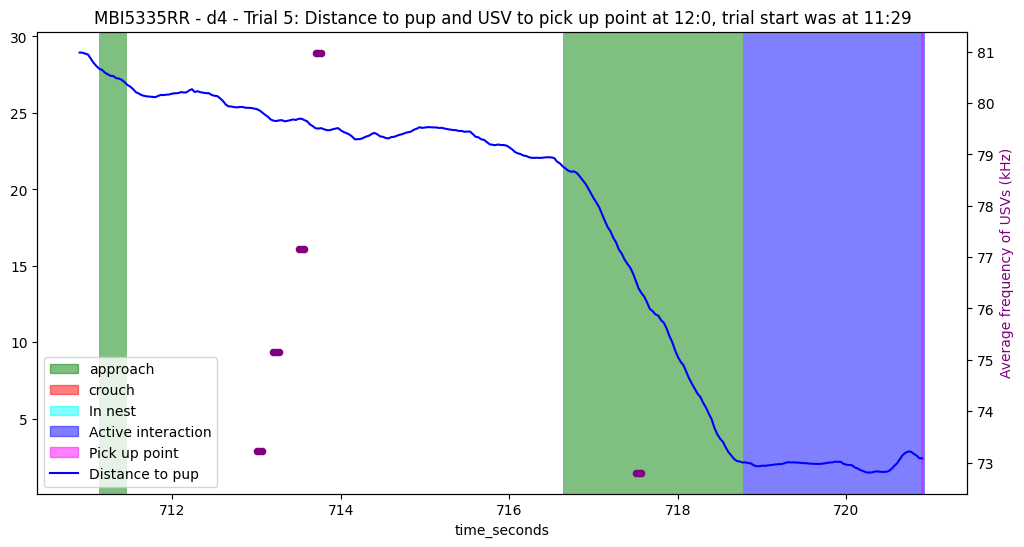

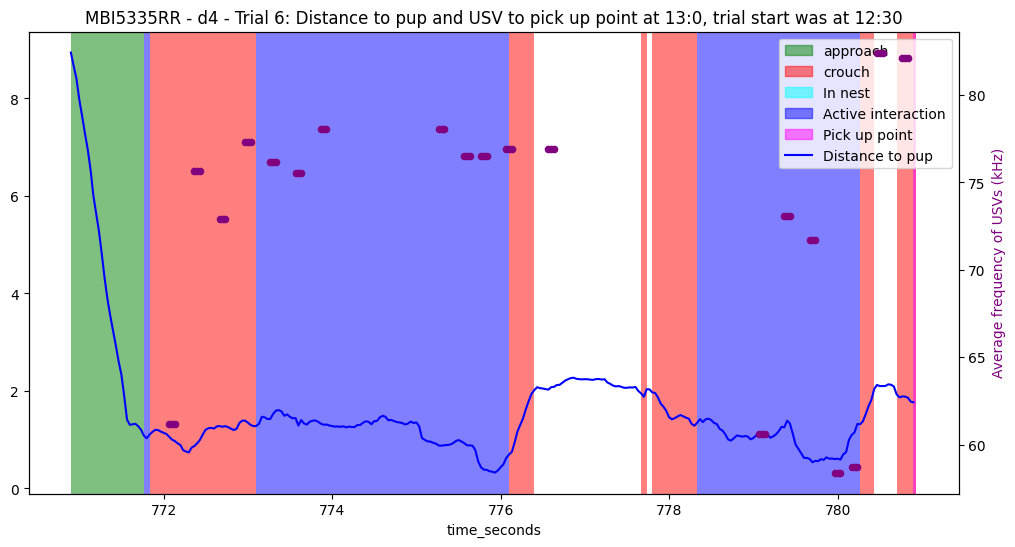

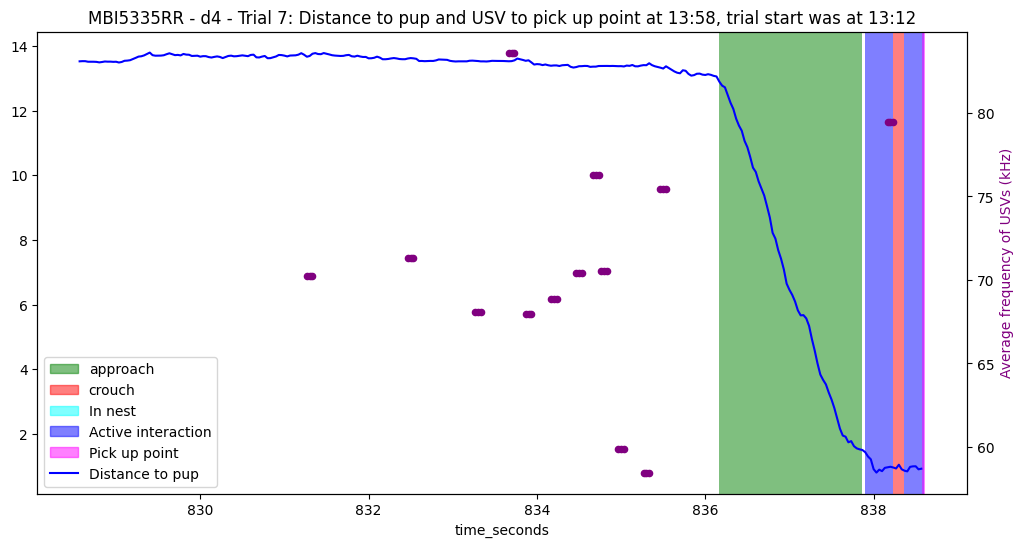

MBI5335RR Day d4 - Trial 8 was not successful


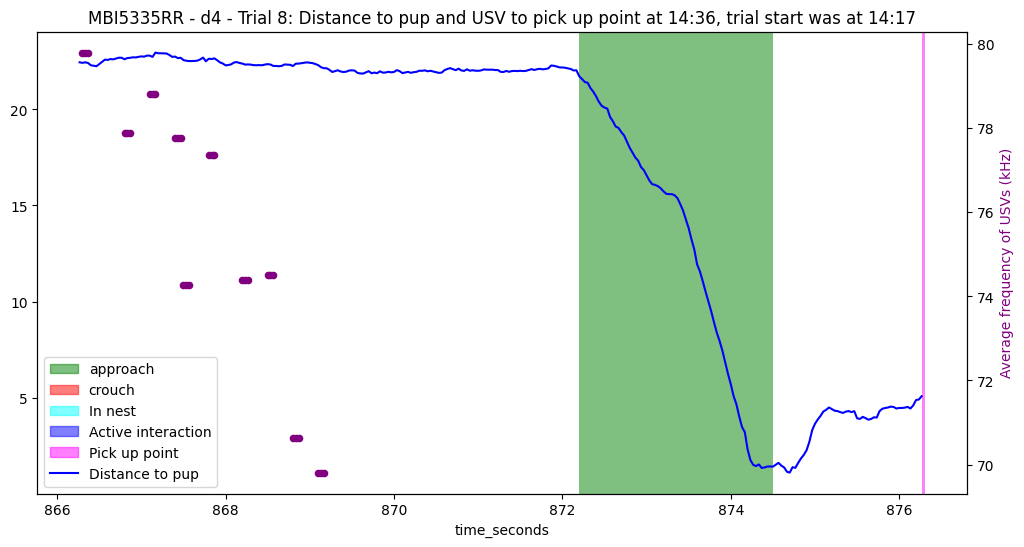

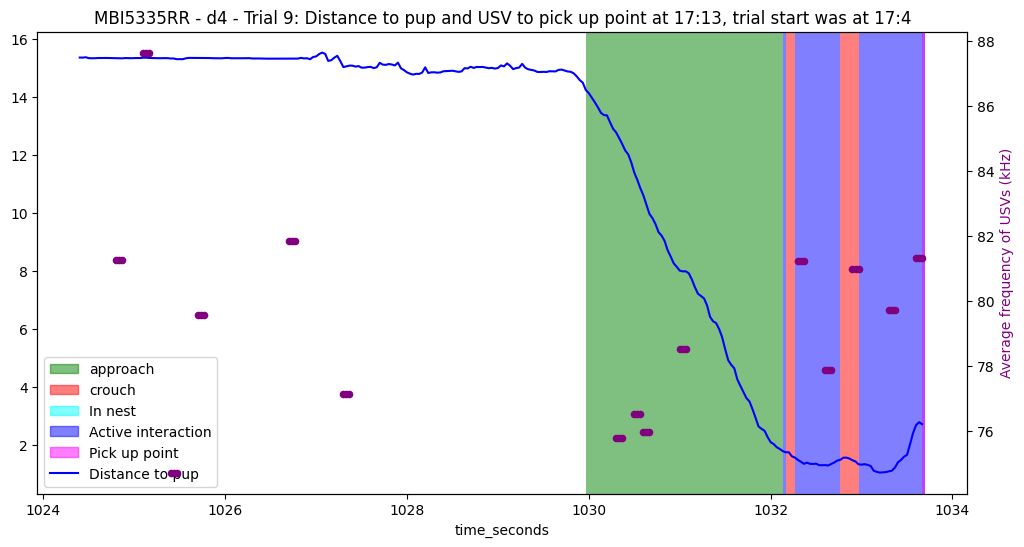

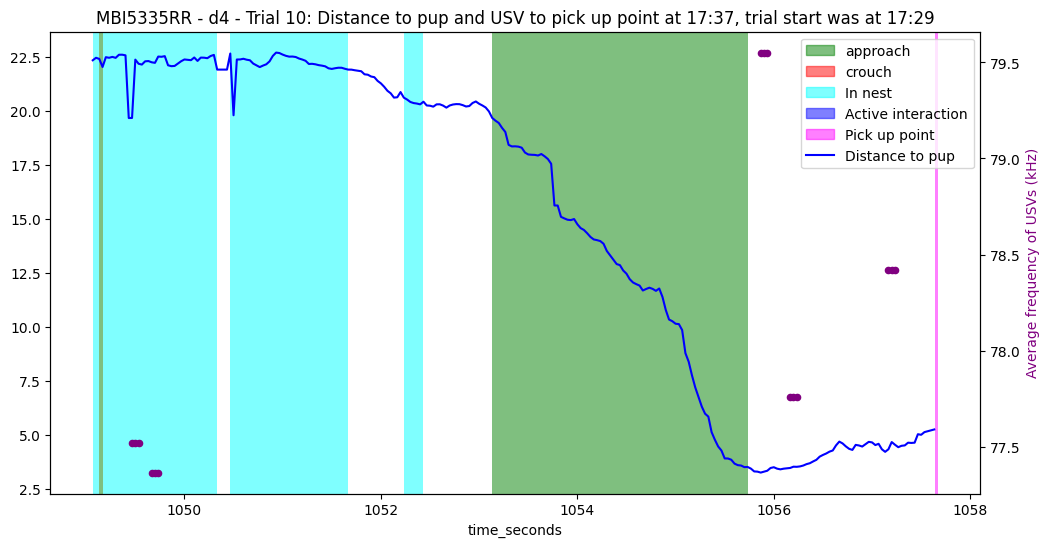

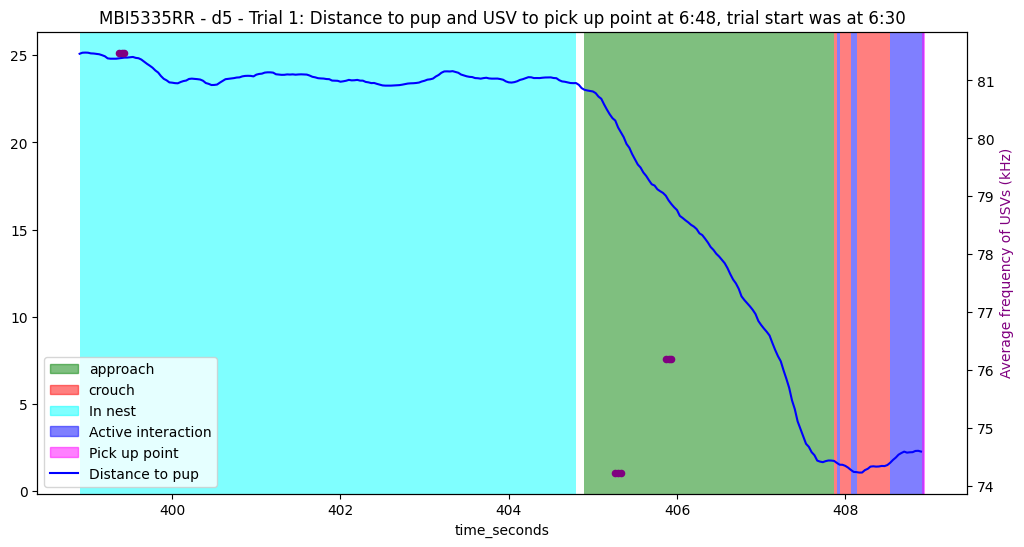

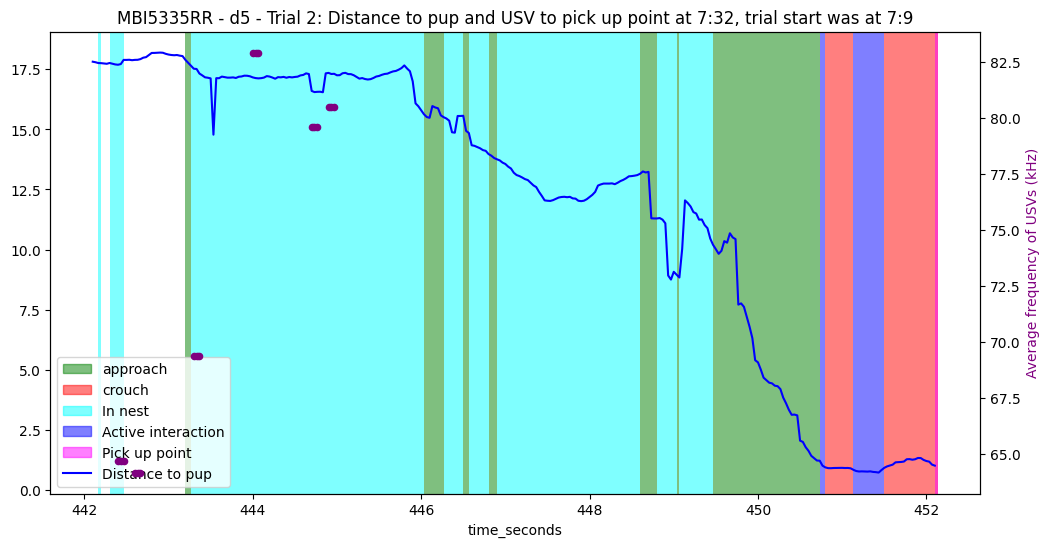

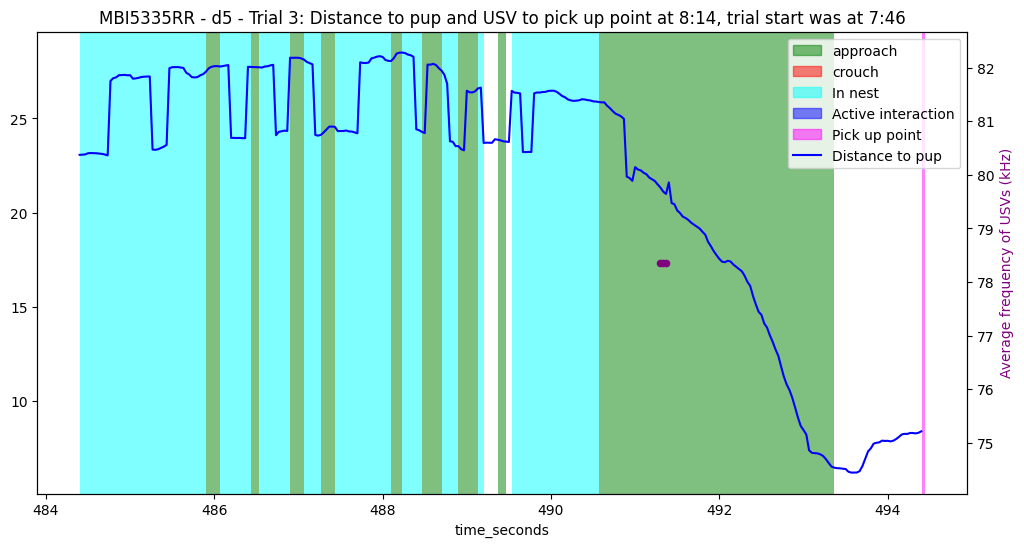

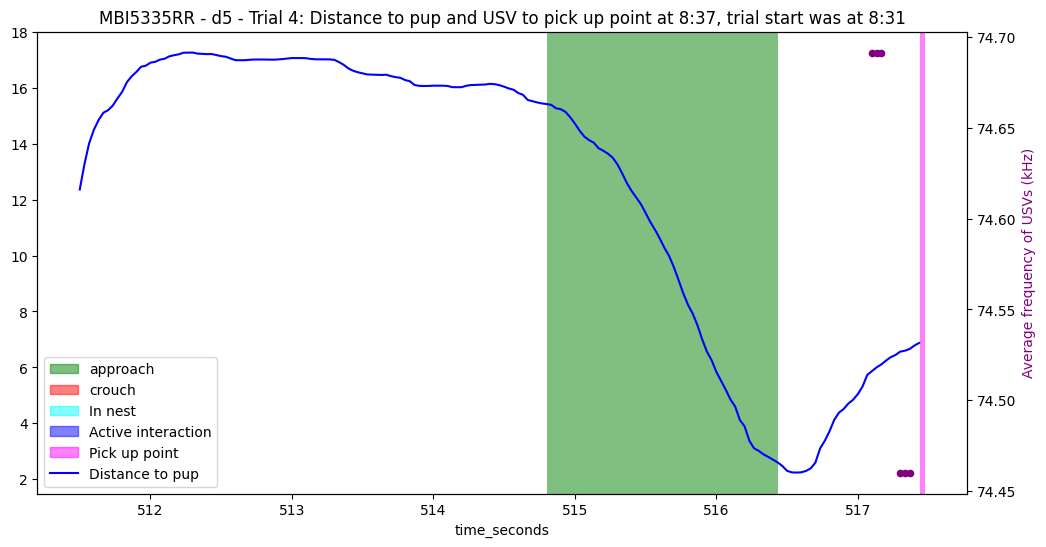

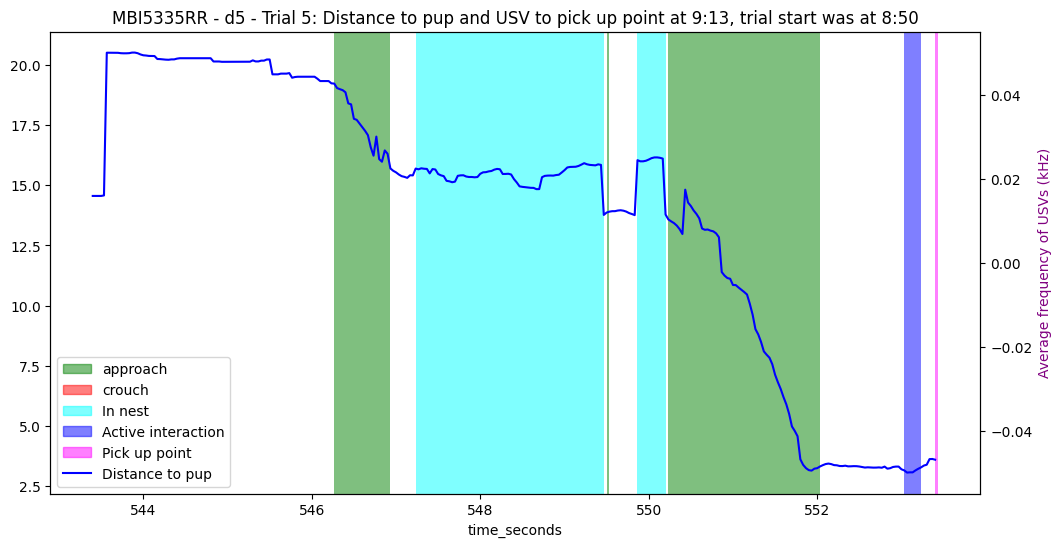

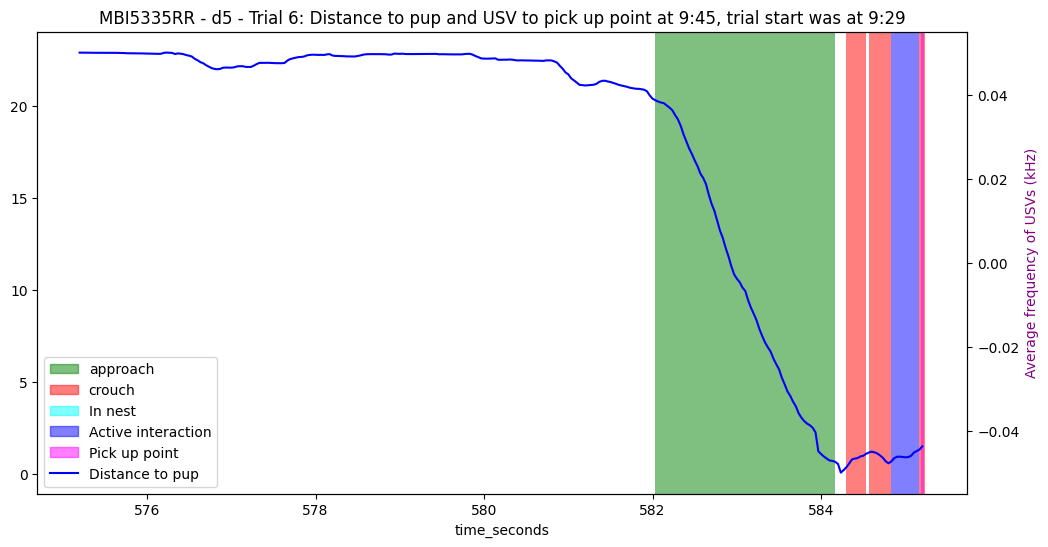

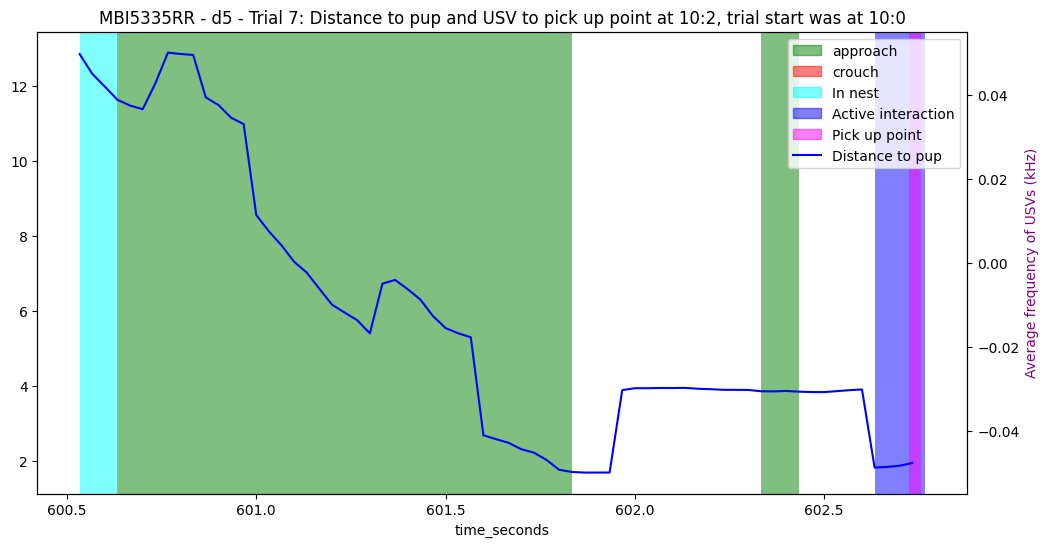

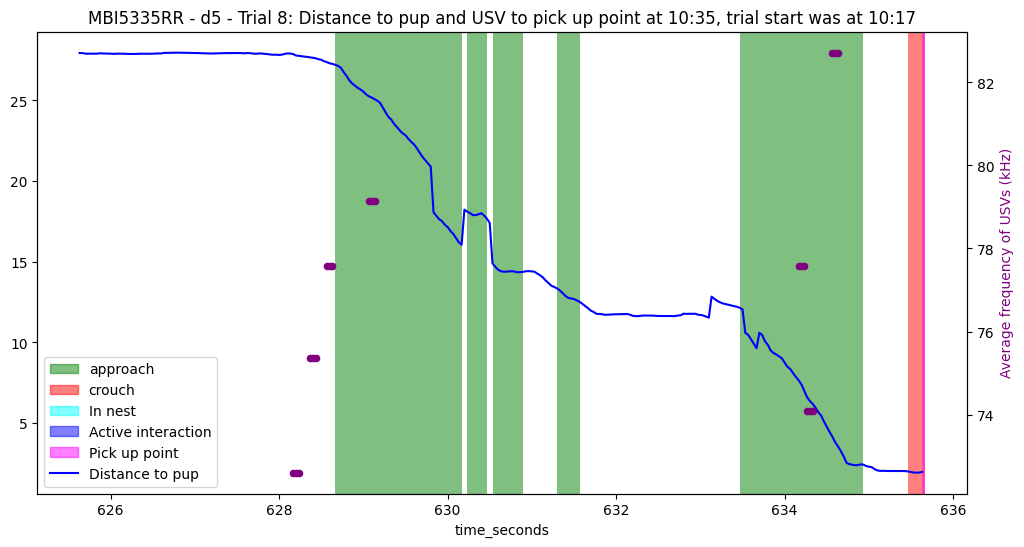

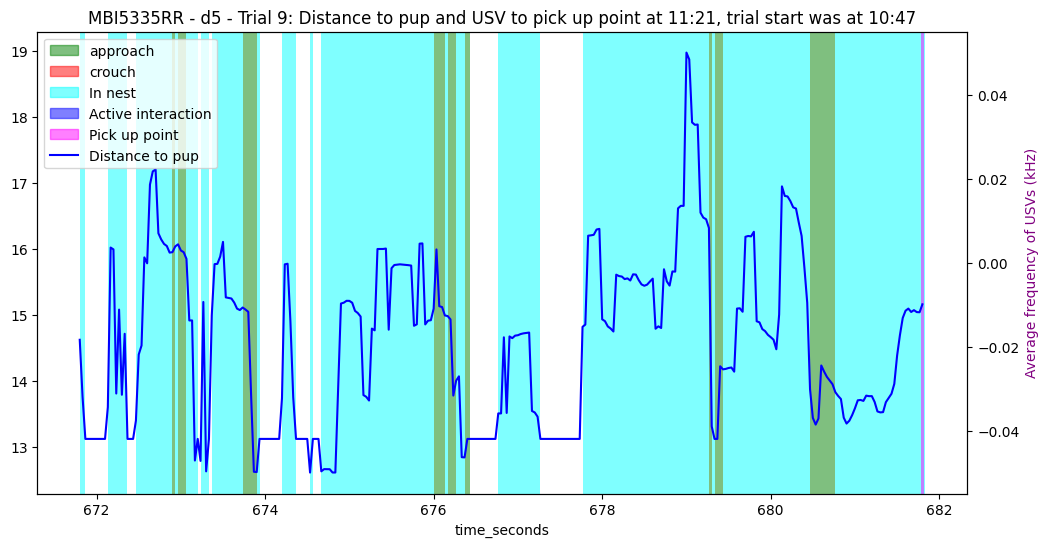

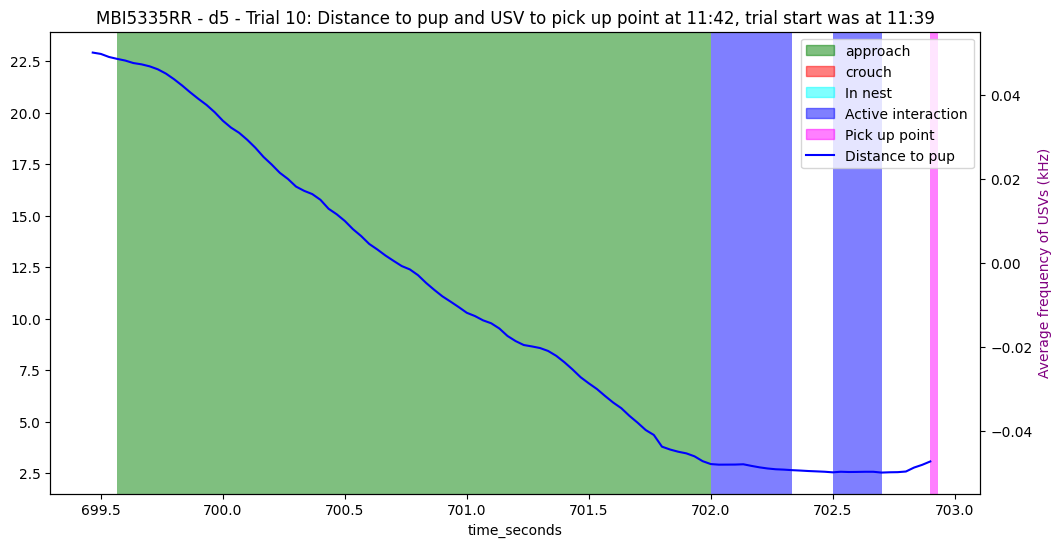

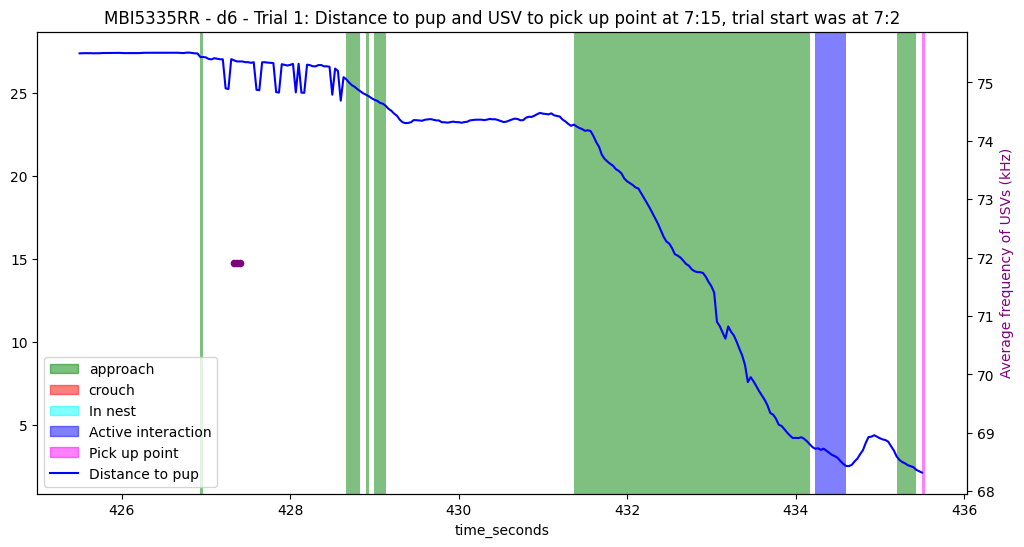

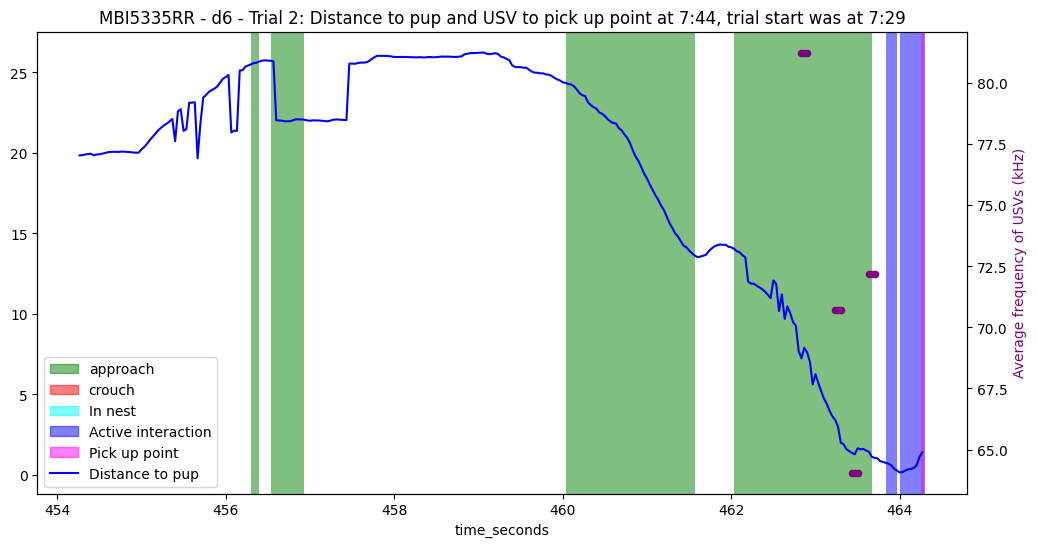

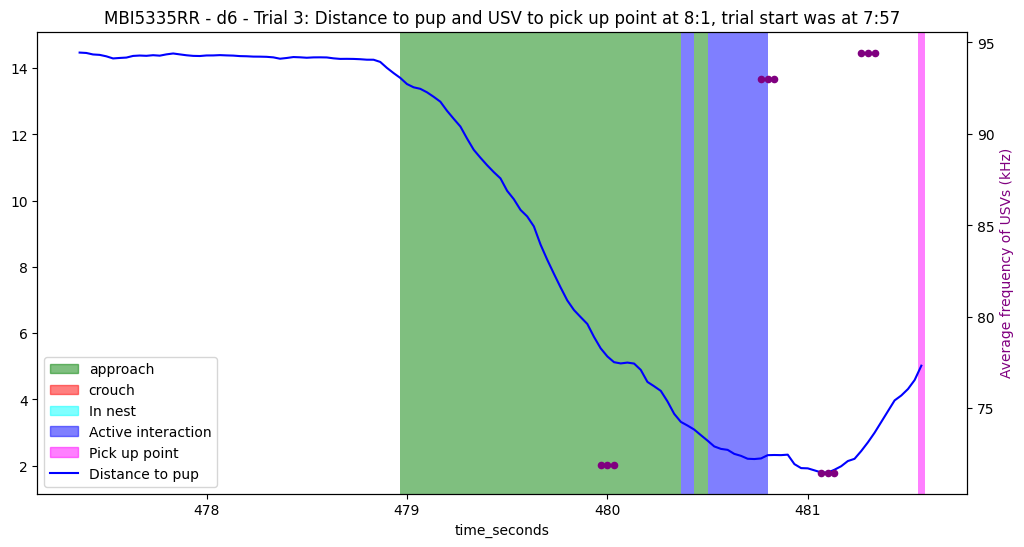

No pick up point for trial 4


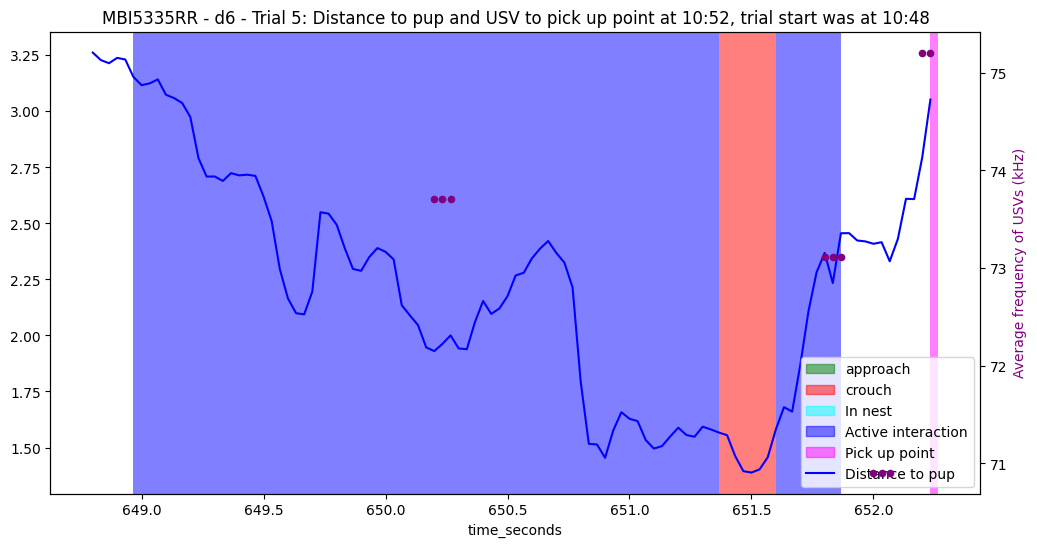

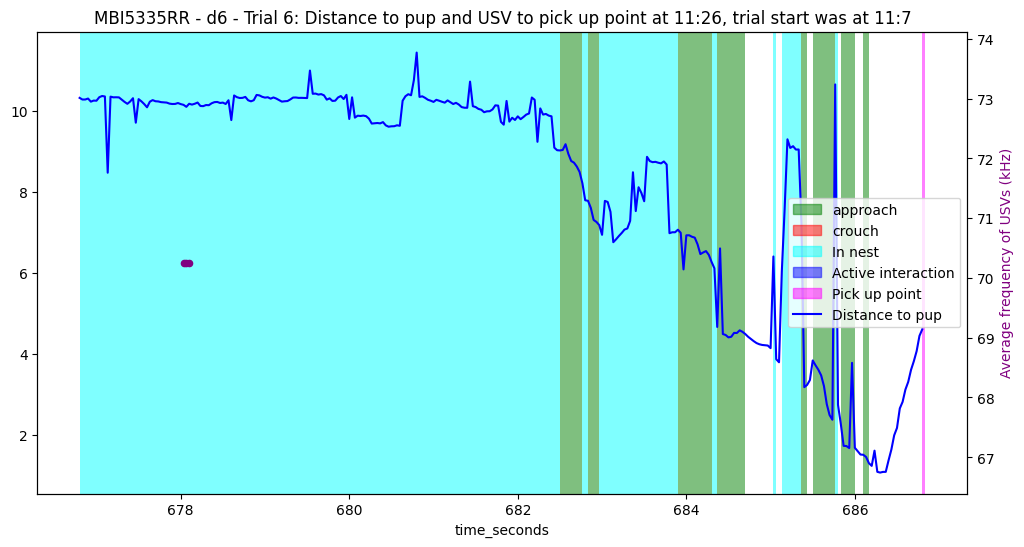

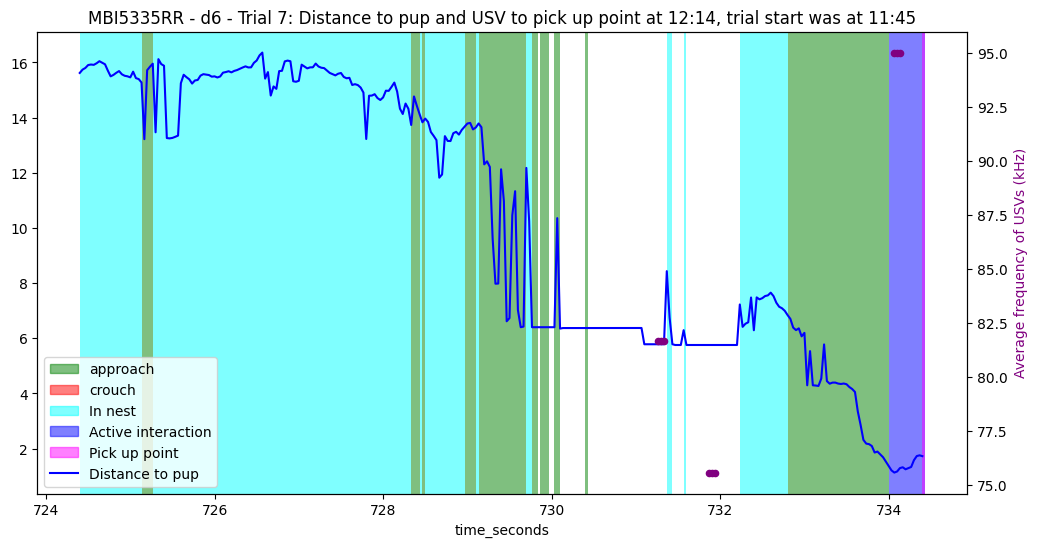

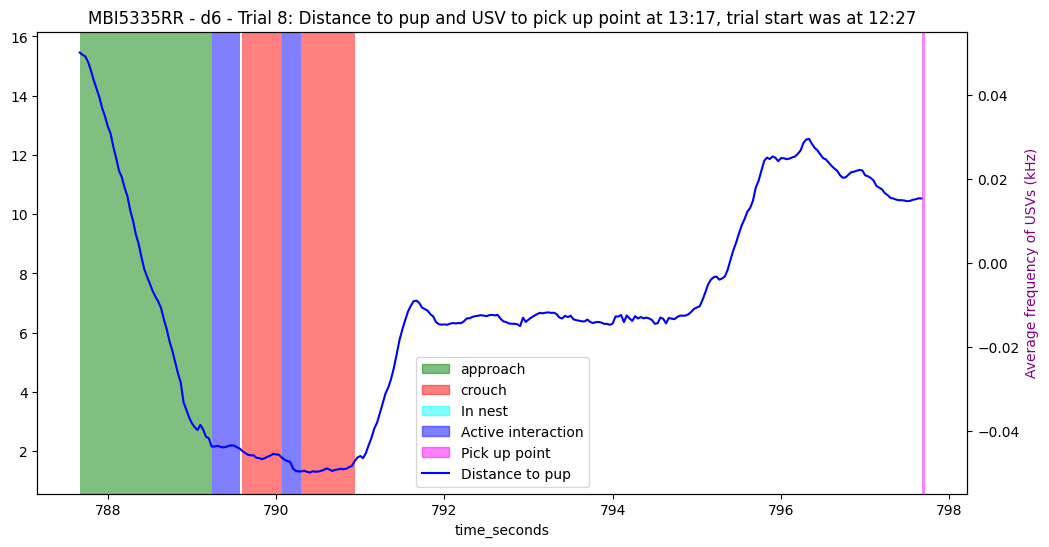

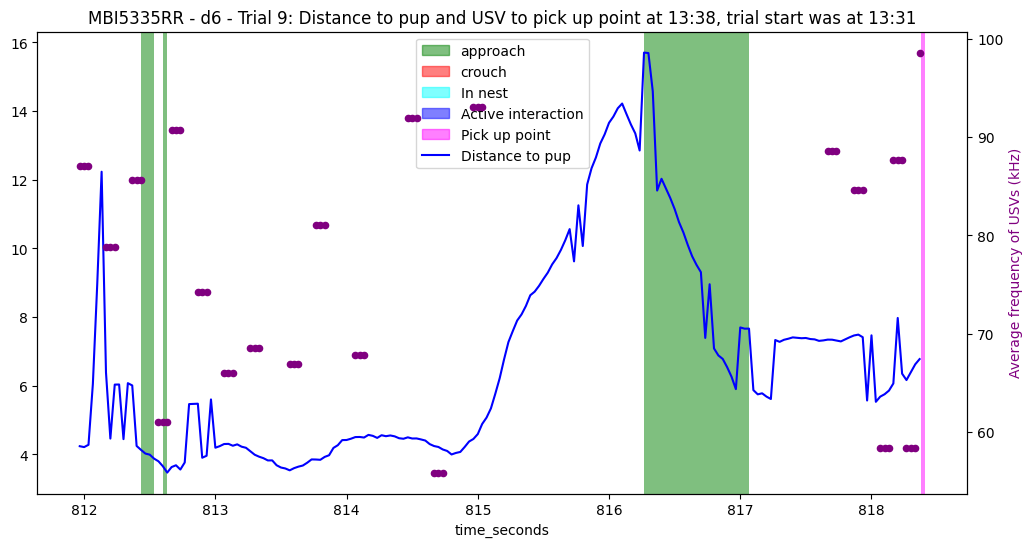

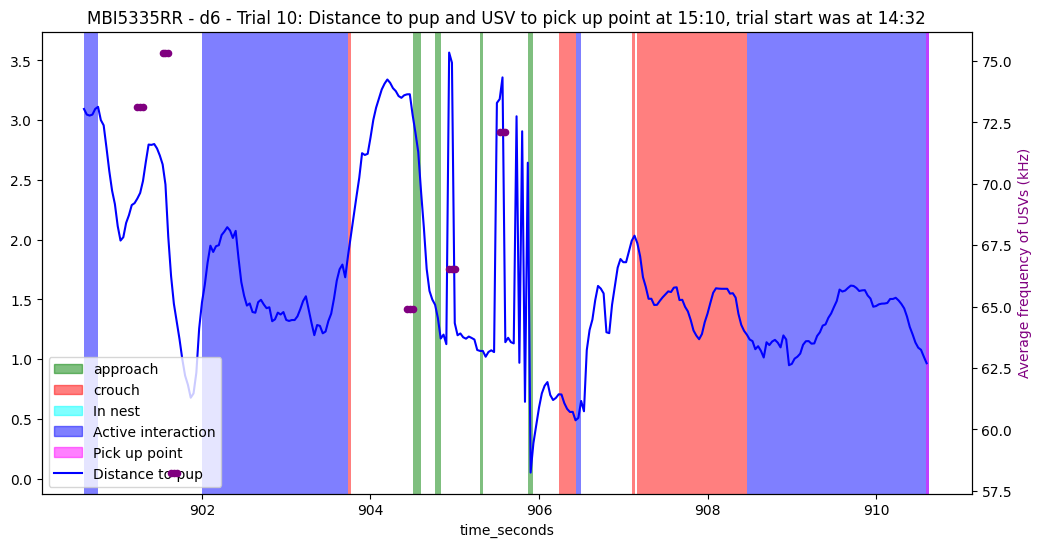

In [4]:
mouse_ids = ["VBQ0261L", "MBI5335RR"]
time_statistics = {ms_id: {time:[] for time in ["active_interaction_time",
                                               "crouching_time",
                                               "approach_time"]} for ms_id in mouse_ids}
for ms_id in mouse_ids:
    for d in days:
        for trial_num in range(1, 11):
            # check that the first pick up point is not nan
            df_summary = experiment_data[ms_id][d]["Behavior"]["df_summary"].copy()

            trial_pickup_time = df_summary.loc[df_summary[BF.DLC_summary_cols["trial_num"]] == trial_num,
                                                          BF.DLC_summary_cols["mouse_first_pick_up"]].values[0]
            trial_success =  df_summary.loc[df_summary[BF.DLC_summary_cols["trial_num"]] == trial_num,
                                                       BF.DLC_summary_cols["trial_success"]].values[0]
            # maybe should filter for successful trials only?
            if np.isnan(trial_pickup_time):
                print("No pick up point for trial", trial_num)
            elif trial_success == 0:
                print(f"{ms_id} Day {d} - Trial {trial_num} was not successful")
                times = plot_pup_usv_to_pickup_point(experiment_data, ms_id, d, trial_num, config_BF=BF.config, BF_instance=BF)
                for key in times:
                    time_statistics[f"{ms_id}"][key] += [times[key]]

                plt.show()
            else:
                times = plot_pup_usv_to_pickup_point(experiment_data, ms_id, d, trial_num, config_BF=BF.config, BF_instance=BF)
                for key in times:
                    time_statistics[f"{ms_id}"][key] += [times[key]] 
                plt.show()

In [ ]:
{ms_id: {"relative_"+k:np.mean(v) for k, v in time_statistics[ms_id].items()} for ms_id in mouse_ids}

Complex trials

In [ ]:
complex_trials = [("MBI5335RR", "d6", 8),
                  ("MBI5335RR", "d5", 9),
                  ("MBI5335RR", "d4", 8)]

for t in complex_trials:
    plot_pup_usv_to_pickup_point(experiment_data, *t)

### Correlation plots over sessions ###

In [211]:
def extract_trial_window(experiment_data, ms_id, d, trial_num, pre_event_window_size_time = 10):
    
    df_summary = experiment_data[ms_id][d]["Behavior"]["df_summary"].copy()
    trials = experiment_data[ms_id][d]["trials"].copy()
    trial_DLC = trials[trial_num]["dlc_data"].copy()

    trial_pickup_time = df_summary.loc[df_summary[BF.DLC_summary_cols["trial_num"]] == trial_num,
                                       BF.DLC_summary_cols["mouse_first_pick_up"]].values[0]
    trial_start_time = trial_DLC["time_seconds"].iloc[0]
    trial_start_frame_index = trial_DLC["frame_index"].iloc[0]

    # conversion to minutes string
    trial_pickup_time_minutes = f"{int(trial_pickup_time//60)}m:{int(trial_pickup_time%60)}s"
    trial_start_time_minutes = f"{int(trial_start_time//60)}m:{int(trial_start_time%60)}s"

    # conversion to frames
    event_time_point_frame = convert_seconds_to_frame(trial_pickup_time, BF.frame_rate)
    pre_event_window_size_frames = convert_seconds_to_frame(pre_event_window_size_time, BF.frame_rate) # convert to frames 
    start_frame_index = event_time_point_frame - pre_event_window_size_frames

    if start_frame_index < trial_start_frame_index:
        warnings.warn(f"Window is too big, spills over trial start, resetting window size to {trial_start_frame_index - start_frame_index}")
        pre_event_window_size_frames = trial_start_frame_index - start_frame_index

    # compute derivatives for columns in "DLC_behaviour_columns" in the BF over window,  ["mouse_speed", "distance_mouse_pup"]
    window = trial_DLC.loc[start_frame_index:event_time_point_frame].copy()

    # distance mouse to pup corner
    pup_corner_bounds = BF.extract_pup_starting_position_bounds(df_summary, trial_num)
    pup_center_x, pup_center_y = pup_corner_bounds["xmin"] + (pup_corner_bounds["xmax"] - pup_corner_bounds["xmin"]) / 2, pup_corner_bounds["ymin"] + (pup_corner_bounds["ymax"] - pup_corner_bounds["ymin"]) / 2
    window["distance_mouse_pup_center"] = np.sqrt((window["mouse_x"] - pup_center_x)**2 + (window["mouse_y"] - pup_center_y)**2)
    window["distance_head_pup_center"] = np.sqrt((window["head_x"] - pup_center_x)**2 + (window["head_y"] - pup_center_y)**2)

    columns = [BF.DLC_behaviour_cols["mouse_speed"], "distance_mouse_pup_center", "distance_head_pup_center"]
    px_cm_ratio = BF.config["pixels_to_cm_ratio"]
    for col in columns:
        window[col+"_cm"] = window[col] / px_cm_ratio
 
    window[BF.DLC_cols["time"]] =   window[BF.DLC_cols["time"]] - window[BF.DLC_cols["time"]].iloc[-1]

    return window


##### Finding suitable files #####

In [ ]:
complex_trials = [("MBI5335RR", "d6", 8),
                  ("MBI5335RR", "d5", 9),
                  ("MBI5335RR", "d2", 7),
                  ("MBI5335RR", "d3", 9)]

successful_trials = []
no_pick_up = []
failed_with_pick_up = []

for ms_id in mouse_ids:
    for session in days:
        for trial_num in range(1, 11):
            df_summary = experiment_data[ms_id][session]["Behavior"]["df_summary"].copy()
            trial_pickup_time =  df_summary.loc[df_summary[BF.DLC_summary_cols["trial_num"]] == trial_num, BF.DLC_summary_cols["mouse_first_pick_up"]].values[0]
            trial_success =  df_summary.loc[df_summary[BF.DLC_summary_cols["trial_num"]] == trial_num, BF.DLC_summary_cols["trial_success"]].values[0]
            if trial_success == 1:
                successful_trials.append((ms_id, session, trial_num))
                window = extract_trial_window(experiment_data, ms_id, session, trial_num)
                window.plot(x = BF.DLC_cols["time"], y = "distance_mouse_pup_center_cm", color = "blue")

            if np.isnan(trial_pickup_time):
                print("No pick up point for trial", trial_num)
                no_pick_up.append((ms_id, session, trial_num))

            elif (ms_id, session, trial_num) in complex_trials:
                print(f"{ms_id} Day {d} - Trial {trial_num} is too complex")

            elif trial_success == 0:
                print(f"{ms_id} Day {d} - Trial {trial_num} was not successful")
                failed_with_pick_up.append((ms_id, session, trial_num))


In [ ]:
# count of sucessful trials
print("Virgin success trials count:", len([t for t in successful_trials if t[0] != "MBI5335RR"]))

print("Mother success trials count:", len([t for t in successful_trials if t[0] == "MBI5335RR"]))

# count of failed trials with attempted pick up
print("Virgin failed trials (with pick up) count:", len([t for t in failed_with_pick_up if t[0] != "MBI5335RR"]))

print("Mother failed trials (with pick up) count:", len([t for t in failed_with_pick_up if t[0] == "MBI5335RR"]))

##### Collecting values from trial data #####

1. Current time correlation

In [ ]:
time_bins = [(i, i+2) for i in range(-10, 0, 2)]

print(time_bins)

input_variables = ["average_power", "average_frequency", "average_duration",
                      "total_call_numbers"]
dependent_variables = ["average_distance", "delta_distance", "head_angle_to_pup_degrees"]

chosen_variable = "average_distance"

bounds = {key: {"min": None, "max": None}
          for key in [input_variables] + [dependent_variables]}

trials = successful_trials + failed_with_pick_up #[successful_trials[8]]

correlation_data = { ms_id: { key: {day:[] for day in days} 
                             for key in input_variables }
                    for ms_id in mouse_ids}

for t in trials:
    # extract window
    df = extract_trial_window(experiment_data, *t)

    ms_id, session, trial_num = t

    for b in time_bins:

        min, max = b
        mask = (df["time_seconds"] >= min) & (df["time_seconds"] <= max)
        window_bin = df[mask]

        if window_bin["time_seconds"].sum() == 0:
            length = df["time_seconds"].iloc[0]
            print(f"Bin {b} is empty, trial too short with total length {length} seconds")
            continue

        else:
            groups = window_bin.groupby("bout_window_index")

            # aggregating call numbers over groups
            call_numbers = [g["call_number"].iloc[0] for name, g in groups if g["call_number"].isna().sum() == 0]
            total_call_numbers = sum(call_numbers)

            # average usv parameters
            combined_values = {"total_call_numbers": total_call_numbers}

            for col in [name for name in  input_variables if name != "total_call_numbers"]: 
                value = np.mean([g[col].iloc[0] for name, g in groups if g[col].isna().sum() == 0])
                combined_values[col] = value

            # compute average distance
            avg_distance = window_bin["distance_mouse_pup_center_cm"].mean()
            combined_values[chosen_variable] = avg_distance

            # storing values in dictionary
            print(f"\n===== Bin {b}, Trial {t}")
            for col, value in combined_values.items():
                if not np.isnan(value):
                    # update max and min bounds
                    print( f"--> x = {col}: {value}")
                    print(bounds[col]["min"], bounds[col]["max"])

                    bounds[col]["min"] = np.min([bounds[col]["min"], value]) if bounds[col]["min"] is not None else value
                    bounds[col]["max"] = np.max([bounds[col]["max"], value]) if bounds[col]["max"] is not None else value

                    # update dictionary
                    if col in correlation_data[ms_id]:
                        correlation_data[ms_id][col][session].append((value, avg_distance))
                        print(f"--> x = {col}: {value})")

            print(f"--> y = {chosen_variable}: {avg_distance}")

print(" * === * Resulting Min and Max bounds * === * ")
print(bounds)


2. Shifted time correlation

In [ ]:
step = 1 # s
bin_separation = 1
time_bins =  [(i, i+step) for i in range(-10, 0, step)]
print(time_bins)
bins_prev = time_bins[:-bin_separation]
bins_next = time_bins[bin_separation:]

bounds_shifted = {key: {"min": None, "max": None}
          for key in ["average_power", "average_frequency", "average_duration",
                      "total_call_numbers", "average_distance", "delta_distance"]}

trials = successful_trials + failed_with_pick_up #[successful_trials[8]]

correlation_future_shifted_data = { ms_id: { key: {day: [] for day in days} 
                             for key in ["total_call_numbers",
                                        "average_power",
                                        "average_frequency",
                                        "average_duration"]}
                    for ms_id in mouse_ids}


for t in trials:
    # extract window
    df = extract_trial_window(experiment_data, *t)

    ms_id, session, trial_num = t

    for b_prev, b_next in zip(bins_prev, bins_next):

        min_prev, max_prev = b_prev
        min_next, max_next = b_next

        mask_prev = (df["time_seconds"] >= min_prev) & (df["time_seconds"] <= max_prev)
        mask_next = (df["time_seconds"] >= min_next) & (df["time_seconds"] <= max_next)

        window_bin_next = df[mask_next]
        window_bin_prev = df[mask_prev]

        if window_bin_next["time_seconds"].sum() == 0 or window_bin_prev["time_seconds"].sum() == 0:
            length = df["time_seconds"].iloc[0]
            print(f"Bin {b_prev} or {b_next} is empty, trial too short with total length {length} seconds")
            continue

        else:
            groups = window_bin_prev.groupby("bout_window_index")

            # aggregating call numbers over groups
            call_numbers = [g["call_number"].iloc[0] for name, g in groups if g["call_number"].isna().sum() == 0]
            total_call_numbers = sum(call_numbers)

            # average usv parameters
            combined_values = {"total_call_numbers": total_call_numbers}
            for col in ["average_power", "average_frequency", "average_duration"]:
                value = np.mean([g[col].iloc[0] for name, g in groups if g[col].isna().sum() == 0])
                combined_values[col] = value

            # compute average distance
            avg_distance_next = window_bin_next["distance_mouse_pup_center_cm"].mean()
            avg_distance_prev = window_bin_prev["distance_mouse_pup_center_cm"].mean()

            delta_distance = avg_distance_next - avg_distance_prev

            # bounds_shifted["delta_distance"]["min"] = np.min([bounds_shifted["delta_distance"]["min"], delta_distance]) if (bounds_shifted["delta_distance"]["min"] is not None) else delta_distance
            # bounds_shifted["delta_distance"]["max"] = np.max([bounds_shifted["delta_distance"]["max"], delta_distance]) if (bounds_shifted["delta_distance"]["max"] is not None) else delta_distance

            combined_values["delta_distance"] = delta_distance
            combined_values["average_distance"] = avg_distance_next

            # storing values in dictionary
            print(f"\n===== Bin {b}, Trial {t}")
            for col, value in combined_values.items():
                if not np.isnan(value):
                    
                    # update max and min bounds
                    print( f"--> x = {col}: {value}")
                    #print(bounds[col]["min"], bounds[col]["max"])

                    bounds_shifted[col]["min"] = np.min([bounds_shifted[col]["min"], value]) if bounds_shifted[col]["min"] is not None else value
                    bounds_shifted[col]["max"] = np.max([bounds_shifted[col]["max"], value]) if bounds_shifted[col]["max"] is not None else value
                    print(f"min: {bounds_shifted[col]['min']}, max: {bounds_shifted[col]['max']}")

                    # update dictionary
                    if col in correlation_future_shifted_data[ms_id]:
                        correlation_future_shifted_data[ms_id][col][session].append((value, delta_distance))
                        print(f"--> in prev bin: x = {col}: {value})")

            print(f"--> in next bin: y = average distance: {avg_distance_next}")
            print(f"--> delta distance d_next - d_prev: {delta_distance}")

In [ ]:
bounds_shifted

3. Twice-shifted and thrice-shifted time correlation

In [237]:
def extract_correlation_data(experiment_data, trials, bins_prev, bins_next, bounds,
                        mouse_ids = mouse_ids, days = days):
    
    correlation_future_shifted_data = { ms_id: { key: {day: [] for day in days} 
                             for key in ["total_call_numbers",
                                        "average_power",
                                        "average_frequency",
                                        "average_duration"]}
                    for ms_id in mouse_ids}
    
    bounds_shifted = {key: {"min": None, "max": None}
          for key in ["average_power", "average_frequency", "average_duration",
                      "total_call_numbers", "average_distance", "delta_distance"]}
    
    for t in trials:
        # extract window
        df = extract_trial_window(experiment_data, *t)

        ms_id, session, trial_num = t

        for b_prev, b_next in zip(bins_prev, bins_next):

            min_prev, max_prev = b_prev
            min_next, max_next = b_next

            mask_prev = (df["time_seconds"] >= min_prev) & (df["time_seconds"] <= max_prev)
            mask_next = (df["time_seconds"] >= min_next) & (df["time_seconds"] <= max_next)

            window_bin_next = df[mask_next]
            window_bin_prev = df[mask_prev]

            if window_bin_next["time_seconds"].sum() == 0 or window_bin_prev["time_seconds"].sum() == 0:
                length = df["time_seconds"].iloc[0]
                print(f"Bin {b_prev} or {b_next} is empty, trial too short with total length {length} seconds")
                continue

            else:
                groups = window_bin_prev.groupby("bout_window_index")

                # aggregating call numbers over groups
                call_numbers = [g["call_number"].iloc[0] for name, g in groups if g["call_number"].isna().sum() == 0]
                total_call_numbers = sum(call_numbers)

                # average usv parameters
                combined_values = {"total_call_numbers": total_call_numbers}
                for col in ["average_power", "average_frequency", "average_duration"]:
                    value = np.mean([g[col].iloc[0] for name, g in groups if g[col].isna().sum() == 0])
                    combined_values[col] = value

                # compute average distance
                avg_distance_next = window_bin_next["distance_mouse_pup_center_cm"].mean()
                avg_distance_prev = window_bin_prev["distance_mouse_pup_center_cm"].mean()

                delta_distance = avg_distance_next - avg_distance_prev

                # bounds_shifted["delta_distance"]["min"] = np.min([bounds_shifted["delta_distance"]["min"], delta_distance]) if (bounds_shifted["delta_distance"]["min"] is not None) else delta_distance
                # bounds_shifted["delta_distance"]["max"] = np.max([bounds_shifted["delta_distance"]["max"], delta_distance]) if (bounds_shifted["delta_distance"]["max"] is not None) else delta_distance

                combined_values["delta_distance"] = delta_distance
                combined_values["average_distance"] = avg_distance_next

                # storing values in dictionary
                print(f"\n===== Bin {b_prev, b_next}, Trial {t}")
                for col, value in combined_values.items():
                    if not np.isnan(value):
                        
                        # update max and min bounds
                        print( f"--> x = {col}: {value}")
                        #print(bounds[col]["min"], bounds[col]["max"])

                        bounds_shifted[col]["min"] = np.min([bounds_shifted[col]["min"], value]) if bounds_shifted[col]["min"] is not None else value
                        bounds_shifted[col]["max"] = np.max([bounds_shifted[col]["max"], value]) if bounds_shifted[col]["max"] is not None else value
                        print(f"min: {bounds_shifted[col]['min']}, max: {bounds_shifted[col]['max']}")

                        # update dictionary
                        if col in correlation_future_shifted_data[ms_id]:
                            correlation_future_shifted_data[ms_id][col][session].append((value, delta_distance))
                            print(f"--> in prev bin: x = {col}: {value})")

                print(f"--> in next bin: y = average distance: {avg_distance_next}")
                print(f"--> delta distance d_next - d_prev: {delta_distance}")

    return correlation_future_shifted_data, bounds_shifted

In [ ]:
step = 1 # s
bin_separation = 1
time_bins =  [(i, i+step) for i in range(-10, 0, step)]
bins_prev = time_bins[:-bin_separation]
bins_next = time_bins[bin_separation:]
trials = successful_trials + failed_with_pick_up

print(time_bins)
print(bins_prev)
print(bins_next)

correlation_shift_1bin, bounds_1bin = extract_correlation_data(experiment_data, trials,
                                                                 bins_prev, bins_next, bounds,
                                                                 mouse_ids = mouse_ids, days = days)

In [ ]:
step = 1 # s
bin_separation = 2
time_bins =  [(i, i+step) for i in range(-10, 0, step)]
bins_prev = time_bins[:-bin_separation]
bins_next = time_bins[bin_separation:]
trials = successful_trials + failed_with_pick_up

print(time_bins)
print(bins_prev)
print(bins_next)

correlation_shift_2bins, bounds_2bins = extract_correlation_data(experiment_data, trials,
                                                                 bins_prev, bins_next, bounds,
                                                                 mouse_ids = mouse_ids, days = days)

In [ ]:
step = 1 # s
bin_separation = 3
time_bins =  [(i, i+step) for i in range(-10, 0, step)]
bins_prev = time_bins[:-bin_separation]
bins_next = time_bins[bin_separation:]

print(time_bins)
print(bins_prev)
print(bins_next)

correlation_shift_3bins, bounds_3bins = extract_correlation_data(experiment_data,
                         trials, bins_prev, bins_next, bounds,
                         mouse_ids = mouse_ids, days = days)

##### Helper functions #####

In [ ]:
def create_matrix(data, bins_distance, bins_variable):

    #bins_distance = [(i, i+5) for i in range(0, 30, 5)]
    #bins_numcalls = [(i, i+2) for i in range(0, 12, 2)]

    data = np.array(data)
    matrix_data = np.zeros((len(bins_variable), len(bins_distance)))

    for i in range(len(bins_variable)):
        for j in range(len(bins_distance)):

            mask = (data[:,1] >= bins_distance[j][0]) & (data[:,1] <= bins_distance[j][1]) & (data[:,0] >= bins_variable[i][0]) & (data[:,0] <= bins_variable[i][1])
            # print("for distance bin {} and numcalls bin {} count is {}".format(bins_distance[j], bins_numcalls[i], mask.sum()))
            matrix_data[i,j] = mask.sum() # count of observations in ith num call bin, in jth distance bin

    return matrix_data


In [256]:
def create_correlation_heatmaps(correlation_data,
                                min_max_bounds,
                                num_bins = 8,
                                title = None,
                                names = {"average_power": "Average power of pup calls (dB)",
                                            "average_frequency": "Average frequency of pup calls (kHz)",
                                            "average_duration": "Average duration of pups calls (ms)",
                                            "total_call_numbers": "Total pup calls",
                                            "average_distance": "Average distance mouse-pup (cm)",
                                            "delta_distance": "Delta distance mouse-pup (cm)"}, 
                                label_y = "total_call_numbers",
                                label_x = "average_distance",
                                mouse_ids = ["VBQ0261L", "MBI5335RR"],
                                days = ["d1", "d2", "d3", "d4", "d5", "d6"]):
    
    fig, axs = plt.subplots(2, 6, figsize = (45*1.2, 15*1.2))
    # add a main title
    if title is None:
        fig.suptitle(f"Correlation between {names[label_y]} and {names[label_x]} for Virgin and Mother mice", fontsize = 25)
    else:
        fig.suptitle(title, fontsize = 25)

    min_val_y, max_val_y = min_max_bounds[label_y]["min"], min_max_bounds[label_y]["max"]
    min_val_x, max_val_x = min_max_bounds[label_x]["min"], min_max_bounds[label_x]["max"]

    x_labels = np.linspace(min_val_x, max_val_x, num = num_bins, endpoint=True)
    x_labels = np.round(x_labels, 0)
    y_labels = np.linspace(min_val_y, max_val_y, num = num_bins, endpoint=True)
    y_labels = np.round(y_labels, 0) if label_y == "total_call_numbers" else np.round(y_labels, 2)

    # create tuples for bins
    bins_distance = [(x_labels[i], x_labels[i+1]) for i in range(len(x_labels) - 1)]
    bins_variable = [(y_labels[i], y_labels[i+1]) for i in range(len(y_labels) - 1)]

    # print(f"X labels: {x_labels}")
    # print(f"Y labels: {y_labels}")

    # print(f"Bins distance: {bins_distance}")
    # print(f"Bins variable: {bins_variable}")

    for i in range(2):
        ms_id = mouse_ids[i]
        for j in range(6):
            session = days[j]

            data = correlation_data[ms_id][label_y][session].copy()

            if len(data) == 0:
                print(f"No data for {ms_id} and {session}")
                continue

            #print(f"For {ms_id} and {session}: ", data)
            data =  np.array(data)
            matrix_data = create_matrix(data, bins_distance, bins_variable)
            #print(f"Matrix data shape: {matrix_data.shape}")

            corr = np.corrcoef(data[:,0], data[:,1]) # compute the correlation of the data
            corr = np.round(corr, 3) # show only 3 digits after the decimal
            print(f"Correlation for {ms_id}, {session} is {corr[0,1]}")

            # create plot
            ax = axs[i, j]

            im = ax.imshow(matrix_data,
                    cmap='viridis',
                    aspect='auto',
                    origin = "lower",
                    vmin = 0, vmax = 10)

            # # Add color bar
            # cbar = ax.colorbar()
            # cbar.set_label('Counts')

            # Set axis ticks and labels with size 15
            ax.set_xticks(ticks=np.arange(0, matrix_data.shape[1] + 1) - 0.5, labels=x_labels, fontsize = 15)
            ax.set_yticks(ticks=np.arange(0, matrix_data.shape[0] + 1) - 0.5, labels=y_labels, fontsize = 15)

            # Add labels to each cell
            for k in range(matrix_data.shape[0]):
                for l in range(matrix_data.shape[1]):
                    ax.text(l, k, str(matrix_data[k, l]), ha='center',
                            va='center', color='white', fontsize = 15)

            # Add axis labels
            ax.set_xlabel(names[label_x], fontsize = 20)
            ax.set_ylabel(names[label_y], fontsize = 20)
            ax.set_title(f'{ms_id} - {session}; Correlation = {corr[0,1]}', fontsize = 17)
        
    # add a colorbar at the end of the row
    cbar_ax = fig.add_axes([0.92, 0.15, 0.02, 0.7])  # Position of the colorbar
    fig.colorbar(im, cax=cbar_ax, label='Counts')


##### Single file example #####

In [ ]:
# data_d1_M = correlation_data['MBI5335RR']["total_call_numbers"]['d4'].copy()
# data_d1_M = np.array(data_d1_M)


# #### Matrix plot ####
# # show matrix_data as heatmap of colors
# # Define x and y axis labels
# x_labels = [0, 5, 10, 15, 20, 25, 30]
# y_labels = [0, 2, 4, 6, 8, 10, 12]

# bins_distance = [(i, i+5) for i in range(0, 30, 5)]
# bins_variable = [(i, i+2) for i in range(0, 12, 2)]

# matrix_data = create_matrix(data_d1_M, bins_distance, bins_variable)

# # Create the plot
# plt.figure(figsize=(8, 6))
# plt.imshow(matrix_data,
#         cmap='viridis',
#         aspect='auto',
#         origin = "lower")

# # Add color bar
# cbar = plt.colorbar()
# cbar.set_label('Counts')

# # Set axis ticks and labels
# plt.xticks(ticks=np.arange(0, matrix_data.shape[1] + 1) - 0.5, labels=x_labels)
# plt.yticks(ticks=np.arange(0, matrix_data.shape[0] + 1) - 0.5, labels=y_labels)

# # Add labels to each cell
# for i in range(matrix_data.shape[0]):
#     for j in range(matrix_data.shape[1]):
#         plt.text(j, i, str(matrix_data[i, j]), ha='center',
#                 va='center', color='white')

# # Add axis labels
# plt.xlabel('Distance (cm)')
# plt.ylabel('Number of calls')
# plt.title('Heatmap of observation counts')

# # Show the plot
# plt.show()


# plt.show()

# plt.scatter(data_d1_M[:,1], data_d1_M[:,0])
# plt.title("Scatter plot of observations for session 1 - Distance to pup VS. Number of calls")
# plt.xlabel("Distance to pup (cm)")
# plt.ylabel("Number of calls")

##### Overview plots #####

Correlation plots of number of pup calls VS distance to pup

In [ ]:
create_correlation_heatmaps(correlation_data, bounds,
                            label_y = "total_call_numbers",
                            label_x = "average_distance")

create_correlation_heatmaps(correlation_data, bounds,
                            label_y = "average_power",
                            label_x = "average_distance")

create_correlation_heatmaps(correlation_data, bounds,
                            label_y = "average_frequency",
                            label_x = "average_distance")

create_correlation_heatmaps(correlation_data, bounds,
                            label_y = "average_duration",
                            label_x = "average_distance")

Time-shifted correlation of pup calls VS distance to pup

In [ ]:
# # create a 2 x 6 plots, each plot is a matrix of counts

# fig, axs = plt.subplots(2, 6, figsize = (45*1.2, 15*1.2))

# x_labels = [0, 5, 10, 15, 20, 25, 30]
# y_labels = [0, 2, 4, 6, 8, 10, 12]

# for i in range(2):
#     ms_id = mouse_ids[i]
#     for j in range(6):
#         session = days[j]

#         data = correlation_future_shifted_data[ms_id][session].copy()
#         data =  np.array(data)

#         # compute the correlation of the data
#         corr = np.corrcoef(data[:,0], data[:,1])
#         # show only 3 digits after the decimal
#         corr = np.round(corr, 3)
#         print(f"Correlation for {ms_id}, {session} is {corr[0,1]}")

#         matrix_data = create_matrix(data)

#         # create plot
#         ax = axs[i, j]

#         im = ax.imshow(matrix_data,
#                 cmap='viridis',
#                 aspect='auto',
#                 origin = "lower",
#                 vmin = 0, vmax = 10)

#         # # Add color bar
#         # cbar = ax.colorbar()
#         # cbar.set_label('Counts')

#         # Set axis ticks and labels
#         ax.set_xticks(ticks=np.arange(0, matrix_data.shape[1] + 1) - 0.5, labels=x_labels)
#         ax.set_yticks(ticks=np.arange(0, matrix_data.shape[0] + 1) - 0.5, labels=y_labels)

#         # Add labels to each cell
#         for k in range(matrix_data.shape[0]):
#             for l in range(matrix_data.shape[1]):
#                 ax.text(l, k, str(matrix_data[k, l]), ha='center',
#                         va='center', color='white')

#         # Add axis labels
#         ax.set_xlabel('Distance (cm) in next time bin')
#         ax.set_ylabel('Number of calls in previous time bin')
#         ax.set_title(f'Observations for {ms_id} - {session}; Correlation = {corr[0,1]}', fontsize = 15)
    

# # add a colorbar at the end of the row
# cbar_ax = fig.add_axes([0.92, 0.15, 0.02, 0.7])  # Position of the colorbar
# fig.colorbar(im, cax=cbar_ax, label='Counts')



In [ ]:
# create_correlation_heatmaps(correlation_future_shifted_data, bounds,
#                             label_y = "total_call_numbers",
#                             label_x = "average_distance")

new_bounds = bounds_1bin.copy()
new_bounds["delta_distance"] = {"min": -12, "max": 8}
new_bounds["total_call_numbers"] = {"min": 0, "max": 12}

create_correlation_heatmaps(correlation_shift_1bin, bounds_1bin,
                            num_bins = 6,
                            label_y = "total_call_numbers",
                            label_x = "delta_distance")

# create_correlation_heatmaps(correlation_future_shifted_data, bounds,
#                             label_y = "average_power",
#                             label_x = "average_distance")

# create_correlation_heatmaps(correlation_future_shifted_data, bounds,
#                             label_y = "average_frequency",
#                             label_x = "average_distance")

# create_correlation_heatmaps(correlation_future_shifted_data, bounds,
                            # label_y = "average_duration",
                            # label_x = "average_distance")

In [ ]:
create_correlation_heatmaps(correlation_shift_2bins, bounds_2bins,
                            num_bins = 6,
                            title = "Correlation between total call numbers and delta distance (across 2 bins) for Virgin and Mother mice",
                            label_y = "total_call_numbers",
                            label_x = "delta_distance")

In [ ]:
bounds_3bins["delta_distance"] = {"min": -24, "max": 16}

create_correlation_heatmaps(correlation_shift_3bins, bounds_3bins,
                            num_bins = 6,
                            title = "Correlation between total call numbers and delta distance (across 3 bins) for Virgin and Mother mice",
                            label_y = "total_call_numbers",
                            label_x = "delta_distance")